In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *
from vst_function import *
from stattools.resampling import PermutationTest

In [2]:
## Read and merge files 
anotation = pd.read_csv('../data/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['SAMPLE'] = anotation['3-Illumina_ID']
ids_hg19['REGION'] = anotation['10-Region']


In [3]:
def read_file(file):
    """
    Read a file to a dict of lists.

    :param str file: Path to a sample file.
    :return: dict of lists of records
    :rtype: dict
    """
    vcf_dict = []
    #df = pd.DataFrame()
    with open(file, 'r') as invcf:
        for line in invcf:
            if line.startswith('track'):
                continue
                
    
    
            line = line.strip().split()
            CHR = line[0]
            START = line[1]
            END = line[2]
            SCORE = line[3]
            name = str(file.split('/')[-1]) 
            
            if SCORE == '2':
                continue
            
            vcf_dict.append([name, CHR, START,END, SCORE])
            
            
    return vcf_dict



def read_multiple_files(path_of_files):
    """
    Read the path of vcf files to a dataframe.
    :param str file: Path to a files.
    :return: dict of lists of  records
    :rtype: dict
    """
    files = glob.glob(path_of_files+'*')
    chm13list = []
    for file in files:
        #return pd.DataFrame(read_vcf(file))
        chm13list.append(read_file(file))
    
    return (chm13list)


df = read_multiple_files('../data/CHM13_SGDP/')


In [6]:
Output = []
  
# Using iteration
for temp in df:
    for elem in temp:
        Output.append(elem)

chm13 = pd.DataFrame(Output)

chm13.columns = ['SAMPLE', 'CHR', 'START', 'END', 'SCORE']
chm13['START'] = chm13['START'].astype(int)
chm13['END'] = chm13['END'].astype(int)
chm13['SCORE'] = chm13['SCORE'].astype(int)


## Keeping only samples that are on old cnvs 
chm13 = chm13.merge(ids_hg19, on=['SAMPLE'])

chm13


KeyboardInterrupt: 

In [ ]:
chm13 = pd.DataFrame(Output)

chm13.columns = ['SAMPLE', 'CHR', 'START', 'END', 'SCORE']
chm13['START'] = chm13['START'].astype(int)
chm13['END'] = chm13['END'].astype(int)
chm13['SCORE'] = chm13['SCORE'].astype(int)


## Keeping only samples that are on old cnvs 
chm13 = chm13.merge(ids_hg19, on=['SAMPLE'])

chm13


In [ ]:
## ADDING DUPLICATION/DELETION COLUMN 

deletions = chm13[chm13['SCORE'] < 2 ] 
deletions['TYPE'] = 'DELETION'
duplications= chm13[chm13['SCORE'] > 2] 
duplications['TYPE'] = 'DUPLICATION'

frames = [deletions,duplications]

chm13 = pd.concat(frames)
chm13

In [ ]:
### Getting gene anotation to filtering 
header_list = ['CHR','START', 'END', 'NAME', 'SCORE', 'STRAND', 'END-2', 'END-3', 'TYPE_CODE','BLOCKS', 'LENGTH', 'NORELATIVE'] 
gene_anotation = pd.read_table('../data/gene_anotation_chm13', names = header_list)
#gene_anotation = gene_anotation[gene_anotation['TYPE']=='76,85,212'] # only selecting protein-coding genes

feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chr

report = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
gene_anotation = pd.DataFrame()
gene_anotation['CHR'] = chm13_gene_anotation['GenBank-Accn']
gene_anotation['START'] = chm13_gene_anotation['start']
gene_anotation['END'] = chm13_gene_anotation['end']
gene_anotation['CHR_2'] = chm13_gene_anotation['chromosome'] 





In [ ]:
#chm13 = pd.read_csv('../data/chm13_gene_regions.csv', index_col=0)
chm13['LENGHT'] = chm13['END'] - chm13['START']
chm13['TYPE'].value_counts()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

df_plot= chm13.groupby(['TYPE'])['LENGHT']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df_plot = chm13.groupby(['TYPE'])['LENGHT']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency

plt.show()

In [ ]:
#subsetting deletions and duplications
deletions = chm13[chm13['TYPE'] =='DELETION']
duplications = chm13[chm13['TYPE'] == 'DUPLICATION']

In [ ]:
#change to df when using telomeres and centromeres filtration
final_cnv = deletions.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


final_cnv

In [ ]:
from scipy import stats
#final_cnv = final_cnv.iloc[new]
final = final_cnv.iloc[:,3:284]
counts = final
counts = counts.fillna(2)

#counts = counts[counts.columns.intersection(counts_a.columns)]

#counts = counts.drop(columns=['LP6005592-DNA_G03',
#                     'LP6005443-DNA_E10',
#                     'LP6005442-DNA_E04'])

counts = counts.T
counts = counts.sort_index()
counts

In [ ]:
features = ids_hg19.set_index('SAMPLE').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['REGION']]
features = features.sort_index()
features 

In [ ]:
#PCA
pca = PCA(n_components=10)
pca_results = pca.fit_transform(counts)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

In [ ]:
pca.explained_variance_ratio_

In [ ]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='REGION', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

In [ ]:
freq = final_cnv.iloc[:,3:283]
freq_input = freq.rename(columns=features['REGION'])
df = freq_input.T
#df = df.reset_index()

#df.groupby('SAMPLE').count().div(df.groupby('SAMPLE').size(),0)


df = df.notnull().groupby(level=0).mean()

df = df.T

lut = dict(zip(df.columns.unique(), "rbgymck"))
lut

seaborn.set(font_scale=5)
corrmatrix = df.corr(method='pearson')
row_colors = df.columns.map(lut)
seaborn.clustermap(corrmatrix, row_colors=row_colors, row_cluster=True, figsize=(40,40))
#plt.savefig('clustermap_regions.pdf')

In [ ]:

feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chr

report = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

In [ ]:
chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
chm13_gene_anotation


<h1> VST

In [ ]:
#change to df when using telomeres and centromeres filtration
input_vst = chm13.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


input_vst

In [ ]:
coordinates = input_vst.iloc[:,0:2]
cnvs = final_cnv.iloc[:,3:284]
cnvs = cnvs.T
cnvs = cnvs.fillna(2)
cnvs

In [ ]:
dt = features.merge(cnvs, left_index=True, right_index=True)
dt

In [24]:
####### Groupby regions #######
dt_group = dt.groupby('REGION')

dt_groupped = []
regions = features['REGION'].unique()
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

#### Names to pair-population
regions = dt['REGION'].unique()
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])

In [25]:
## VST for pair-population
vst_dt = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2))
for region in combination_regions:
        statistic = vst((dt_groupped[region[0]]), (dt_groupped[region[1]]))
        vst_dt.append(statistic)

vst_dt = pd.DataFrame(vst_dt).set_axis(combination_names)
#vst_dt = vst_dt.T
vst_dt

/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/vst_function.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vt = pd.concat([x,y]).var()
/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ret

/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/vst_function.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vt = pd.concat([x,y]).var()
/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/vst_function.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vt = pd.concat([x,y]).v

0         1         2         3       \
WestEurasia-Oceania                  NaN  0.149631  0.014829  0.020694   
WestEurasia-America                  NaN  0.019331  0.011426  0.019787   
WestEurasia-Africa                   NaN  0.010377  0.012677  0.009093   
WestEurasia-EastAsia            0.021739  0.020936  0.041581  0.011116   
WestEurasia-SouthAsia                NaN  0.012011  0.020799  0.023338   
WestEurasia-CentralAsiaSiberia       NaN  0.015304  0.033372  0.021325   
Oceania-America                      NaN  0.216594  0.035705       NaN   
Oceania-Africa                       NaN  0.151765  0.015648  0.033682   
Oceania-EastAsia                0.021739  0.102156  0.041667  0.021739   
Oceania-SouthAsia                    NaN  0.142829  0.017891       NaN   
Oceania-CentralAsiaSiberia           NaN  0.215170  0.041667       NaN   
America-Africa                       NaN  0.044121  0.025674  0.032658   
America-EastAsia                0.021739  0.056703  0.085938  0.021739   
America-SouthAsia                    NaN  0.050875  0.041818       NaN   
America-CentralAsiaSiberia           NaN  0.023597  0.080000       NaN   
Africa-EastAsia                 0.021739  0.017654  0.037590  0.016904   
Africa-SouthAsia                     NaN  0.012965  0.016063  0.036427   
Africa-CentralAsiaSiberia            NaN  0.033897  0.034368  0.034368   
EastAsia-SouthAsia              0.021739  0.015747  0.026316  0.021739   
EastAsia-CentralAsiaSiberia     0.021739  0.049739       NaN  0.021739   
SouthAsia-CentralAsiaSiberia         NaN  0.039698  0.026316       NaN   

                                  4         5         6         7       \
WestEurasia-Oceania             0.022105  0.024304  0.036474  0.020694   
WestEurasia-America             0.014313  0.022934  0.046533  0.019787   
WestEurasia-Africa              0.014814  0.013804  0.028765  0.023818   
WestEurasia-EastAsia            0.021082  0.009032  0.010312  0.011261   
WestEurasia-SouthAsia           0.070752  0.013216  0.023416  0.010412   
WestEurasia-CentralAsiaSiberia  0.040584  0.025257  0.028082  0.021325   
Oceania-America                 0.025781       NaN  0.026965       NaN   
Oceania-Africa                  0.017471  0.024390  0.110155       NaN   
Oceania-EastAsia                0.014423  0.029412  0.035439  0.037313   
Oceania-SouthAsia               0.038559  0.026316  0.021554  0.026316   
Oceania-CentralAsiaSiberia      0.025673       NaN  0.021739       NaN   
America-Africa                  0.016449  0.024390  0.128150       NaN   
America-EastAsia                0.016757  0.028533  0.049476  0.035542   
America-SouthAsia               0.058221  0.026316  0.033173  0.026316   
America-CentralAsiaSiberia      0.038870       NaN  0.032752       NaN   
Africa-EastAsia                 0.012742  0.014190  0.047213  0.042961   
Africa-SouthAsia                0.050538  0.012695  0.084207  0.026316   
Africa-CentralAsiaSiberia       0.029243  0.024390  0.093351       NaN   
EastAsia-SouthAsia              0.037253  0.013998  0.019140  0.020073   
EastAsia-CentralAsiaSiberia     0.021069  0.030006  0.025659  0.038509   
SouthAsia-CentralAsiaSiberia    0.020663  0.026316  0.016313  0.026316   

                                  8         9       ...    623952    623953  \
WestEurasia-Oceania             0.010849  0.020694  ...  0.020694  0.017159   
WestEurasia-America             0.015437  0.019787  ...  0.019787  0.016709   
WestEurasia-Africa              0.009168  0.009093  ...  0.023818  0.018713   
WestEurasia-EastAsia            0.008609  0.008437  ...  0.011116  0.008710   
WestEurasia-SouthAsia           0.024081  0.010412  ...  0.010412  0.018474   
WestEurasia-CentralAsiaSiberia  0.018634  0.014468  ...  0.021325  0.017473   
Oceania-America                 0.034367       NaN  ...       NaN       NaN   
Oceania-Africa                  0.017471  0.033682  ...       NaN       NaN   
Oceania-EastAsia                0.014423  0.029412  ...  0.021739

In [26]:
filtering_vst = pd.DataFrame(vst_dt)>=0.2
filtering_vst = filtering_vst.loc[:, filtering_vst.any()]
#filtering_vst = filtering_vst.set_axis(combination_names)
filtering_vst


1       17      67      230     234     \
WestEurasia-Oceania              False   False   False   False   False   
WestEurasia-America              False   False   False   False   False   
WestEurasia-Africa               False   False   False   False   False   
WestEurasia-EastAsia             False   False   False   False   False   
WestEurasia-SouthAsia            False   False   False   False   False   
WestEurasia-CentralAsiaSiberia   False   False   False   False   False   
Oceania-America                   True    True    True    True   False   
Oceania-Africa                   False   False    True   False   False   
Oceania-EastAsia                 False   False   False   False   False   
Oceania-SouthAsia                False   False   False   False   False   
Oceania-CentralAsiaSiberia        True   False   False   False   False   
America-Africa                   False    True   False   False   False   
America-EastAsia                 False   False   False   False   False   
America-SouthAsia                False    True   False   False   False   
America-CentralAsiaSiberia       False   False   False    True   False   
Africa-EastAsia                  False   False   False   False   False   
Africa-SouthAsia                 False   False   False   False   False   
Africa-CentralAsiaSiberia        False   False   False   False   False   
EastAsia-SouthAsia               False   False   False   False   False   
EastAsia-CentralAsiaSiberia      False   False   False   False   False   
SouthAsia-CentralAsiaSiberia     False   False   False   False    True   

                                236     352     400     452     564     ...  \
WestEurasia-Oceania              False   False   False   False   False  ...   
WestEurasia-America              False   False   False   False   False  ...   
WestEurasia-Africa               False   False   False   False   False  ...   
WestEurasia-EastAsia             False   False   False   False   False  ...   
WestEurasia-SouthAsia            False   False   False   False   False  ...   
WestEurasia-CentralAsiaSiberia   False   False   False   False   False  ...   
Oceania-America                  False   False   False   False   False  ...   
Oceania-Africa                   False   False   False   False   False  ...   
Oceania-EastAsia                 False   False   False   False   False  ...   
Oceania-SouthAsia                False   False   False   False   False  ...   
Oceania-CentralAsiaSiberia       False    True   False   False   False  ...   
America-Africa                   False   False   False   False   False  ...   
America-EastAsia                 False   False   False   False   False  ...   
America-SouthAsia                False   False   False   False    True  ...   
America-CentralAsiaSiberia       False   False   False   False   False  ...   
Africa-EastAsia                  False   False   False   False   False  ...   
Africa-SouthAsia                 False   False   False   False   False  ...   
Africa-CentralAsiaSiberia        False   False   False    True   False  ...   
EastAsia-SouthAsia               False   False   False   False   False  ...   
EastAsia-CentralAsiaSiberia      False   False   False   False   False  ...   
SouthAsia-CentralAsiaSiberia      True   False    True   False   False  ...   

                                623839  623840  623841  623842  623843  \
WestEurasia-Oceania              False   False   False   False   False   
WestEurasia-America              False   False   False   False   False   
WestEurasia-Africa               False   False   False   False   False   
WestEurasia-EastAsia             False   False   False   False   False   
WestEurasia-SouthAsia            False   False   False   False   False   
WestEurasia-CentralAsiaSiberia   False   False   False   False   False   
Oceania-America                  False   False   False   False   False   
Oceania-Africa                   False   False   False   False   False  

In [27]:
## Coordinates anotation 
vst_dt = vst_dt.T
vst_dt.insert (0, 'chr', final_cnv['CHR'])
vst_dt.insert (1, 'start', final_cnv['START'])
vst_dt.insert (2, 'end', final_cnv['END'])
vst_dt = vst_dt.round(5)
vst_dt = vst_dt.replace(np.NaN, 0)
vst_dt

chr     start       end  WestEurasia-Oceania  \
0       CP068254.1     14661     15778              0.00000   
1       CP068255.2         0      3514              0.14963   
2       CP068255.2      3514      8916              0.01483   
3       CP068255.2      8916     12222              0.02069   
4       CP068255.2     12222     70111              0.02210   
...            ...       ...       ...                  ...   
623957  CP086569.2  62380980  62392131              0.01370   
623958  CP086569.2  62392131  62403013              0.02069   
623959  CP086569.2  62411230  62422895              0.01716   
623960  CP086569.2  62422895  62423895              0.01716   
623961  CP086569.2  62423895  62425307              0.01716   

        WestEurasia-America  WestEurasia-Africa  WestEurasia-EastAsia  \
0                   0.00000             0.00000               0.02174   
1                   0.01933             0.01038               0.02094   
2                   0.01143             0.01268               0.04158   
3                   0.01979             0.00909               0.01112   
4                   0.01431             0.01481               0.02108   
...                     ...                 ...                   ...   
623957              0.01370             0.01370               0.00932   
623958              0.01979             0.02382               0.01112   
623959              0.01671             0.01871               0.00871   
623960              0.01671             0.01871               0.00871   
623961              0.01671             0.01871               0.00871   

        WestEurasia-SouthAsia  WestEurasia-CentralAsiaSiberia  \
0                     0.00000                         0.00000   
1                     0.01201                         0.01530   
2                     0.02080                         0.03337   
3                     0.02334                         0.02132   
4                     0.07075                         0.04058   
...                       ...                             ...   
623957                0.01370                         0.01370   
623958                0.01041                         0.02132   
623959                0.00902                         0.01747   
623960                0.00902                         0.01747   
623961                0.00902                         0.01747   

        Oceania-America  ...  America-Africa  America-EastAsia  \
0               0.00000  ...         0.00000           0.02174   
1               0.21659  ...         0.04412           0.05670   
2               0.03570  ...         0.02567           0.08594   
3               0.00000  ...         0.03266           0.02174   
4               0.02578  ...         0.01645           0.01676   
...                 ...  ...             ...               ...   
623957          0.00000  ...         0.00000           0.02174   
623958          0.00000  ...         0.00000           0.02174   
623959          0.00000  ...         0.00000           0.02174   
623960          0.00000  ...         0.00000           0.02174   
623961          0.00000  ...         0.00000           0.02174   

        America-SouthAsia  America-CentralAsiaSiberia  Africa-EastAsia  \
0                 0.00000                     0.00000          0.02174   
1                 0.05088                     0.02360          0.01765   
2                 0.04182                     0.08000          0.03759   
3                 0.00000                     0.00000          0.01690   
4                 0.05822                     0.03887          0.01274   
...                   ...                         ...              ...   
623957            0.00000                     0.00000          0.02174   
623958            0.02632                     0.00000          0.02174   
623959            0.02632                     0.00000          0.02174   
623960            0.02632                     0.00000          0.02

In [28]:
cnv_passed_vst = cnvs.T.iloc[filtering_vst.T.index]
cnv_passed_vst

SAMPLE  LP6005441-DNA_A01  LP6005441-DNA_A03  LP6005441-DNA_A04  \
1                     2.0                0.0                2.0   
17                    2.0                2.0                2.0   
67                    2.0                1.0                2.0   
230                   2.0                1.0                2.0   
234                   1.0                2.0                1.0   
...                   ...                ...                ...   
623844                2.0                1.0                1.0   
623853                2.0                2.0                1.0   
623857                2.0                2.0                2.0   
623894                2.0                1.0                2.0   
623895                2.0                1.0                1.0   

SAMPLE  LP6005441-DNA_A05  LP6005441-DNA_A06  LP6005441-DNA_A08  \
1                     2.0                2.0                2.0   
17                    2.0                2.0                2.0   
67                    2.0                1.0                2.0   
230                   2.0                1.0                1.0   
234                   2.0                1.0                1.0   
...                   ...                ...                ...   
623844                2.0                2.0                2.0   
623853                2.0                2.0                2.0   
623857                2.0                2.0                2.0   
623894                2.0                2.0                2.0   
623895                2.0                2.0                2.0   

SAMPLE  LP6005441-DNA_A09  LP6005441-DNA_A10  LP6005441-DNA_A11  \
1                     2.0                2.0                2.0   
17                    2.0                2.0                2.0   
67                    2.0                1.0                2.0   
230                   1.0                2.0                2.0   
234                   1.0                1.0                2.0   
...                   ...                ...                ...   
623844                2.0                2.0                2.0   
623853                2.0                2.0                2.0   
623857                2.0                2.0                2.0   
623894                2.0                2.0                2.0   
623895                2.0                2.0                2.0   

SAMPLE  LP6005441-DNA_A12  ...  LP6005677-DNA_D03  LP6005677-DNA_E01  \
1                     2.0  ...                2.0                2.0   
17                    1.0  ...                2.0                2.0   
67                    2.0  ...                2.0                2.0   
230                   1.0  ...                2.0                2.0   
234                   1.0  ...                2.0                2.0   
...                   ...  ...                ...                ...   
623844                1.0  ...                1.0                2.0   
623853                2.0  ...                1.0                2.0   
623857                2.0  ...                2.0                2.0   
623894                2.0  ...                1.0                2.0   
623895                2.0  ...                1.0                2.0   

SAMPLE  LP6005677-DNA_F01  LP6005677-DNA_G01  LP6007068-DNA_A01  \
1                     2.0                2.0                2.0   
17                    2.0                2.0                2.0   
67                    1.0                2.0                1.0   
230                   2.0                2.0                2.0   
234                   2.0                1.0                1.0   
...                   ...                ...                ...   
623844                1.0                2.0                2.0   
623853                1.0                2.0                2.0   
623857                2.0                2.0                2.0   
623894                2.0                2.0      

In [29]:
counts = cnv_passed_vst.T
counts = counts.sort_index()
counts

1       17      67      230     234     236     352     \
SAMPLE                                                                      
LP6005441-DNA_A01     2.0     2.0     2.0     2.0     1.0     2.0     2.0   
LP6005441-DNA_A03     0.0     2.0     1.0     1.0     2.0     2.0     2.0   
LP6005441-DNA_A04     2.0     2.0     2.0     2.0     1.0     2.0     2.0   
LP6005441-DNA_A05     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A06     2.0     2.0     1.0     1.0     1.0     2.0     2.0   
...                   ...     ...     ...     ...     ...     ...     ...   
LP6007069-DNA_A01     2.0     2.0     1.0     1.0     1.0     1.0     2.0   
SS6004471             2.0     2.0     2.0     1.0     1.0     2.0     1.0   
SS6004477             2.0     2.0     1.0     1.0     1.0     2.0     2.0   
SS6004478             2.0     2.0     1.0     1.0     1.0     2.0     1.0   
SS6004480             1.0     2.0     1.0     1.0     1.0     2.0     1.0   

                   400     452     564     ...  623839  623840  623841  \
SAMPLE                                     ...                           
LP6005441-DNA_A01     1.0     2.0     1.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A03     1.0     1.0     2.0  ...     0.0     0.0     0.0   
LP6005441-DNA_A04     2.0     2.0     2.0  ...     0.0     0.0     0.0   
LP6005441-DNA_A05     2.0     2.0     1.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A06     2.0     2.0     1.0  ...     2.0     2.0     2.0   
...                   ...     ...     ...  ...     ...     ...     ...   
LP6007069-DNA_A01     2.0     1.0     2.0  ...     0.0     0.0     0.0   
SS6004471             1.0     1.0     1.0  ...     2.0     2.0     2.0   
SS6004477             2.0     1.0     1.0  ...     2.0     2.0     2.0   
SS6004478             2.0     1.0     2.0  ...     0.0     0.0     0.0   
SS6004480             1.0     1.0     1.0  ...     2.0     2.0     2.0   

                   623842  623843  623844  623853  623857  623894  623895  
SAMPLE                                                                     
LP6005441-DNA_A01     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
LP6005441-DNA_A03     0.0     0.0     1.0     2.0     2.0     1.0     1.0  
LP6005441-DNA_A04     0.0     0.0     1.0     1.0     2.0     2.0     1.0  
LP6005441-DNA_A05     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
LP6005441-DNA_A06     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
...                   ...     ...     ...     ...     ...     ...     ...  
LP6007069-DNA_A01     0.0     0.0     1.0     2.0     1.0     2.0     1.0  
SS6004471             2.0     2.0     2.0     2.0     2.0     2.0     2.0  
SS6004477             2.0     2.0     2.0     2.0     2.0     2.0     2.0  
SS6004478             0.0     0.0     1.0     2.0     2.0     1.0     1.0  
SS6004480             2.0     2.0     2.0     2.0     2.0     2.0     2.0  

[269 rows x 46080 columns]

In [30]:
from sklearn.decomposition import PCA
from pca_plot import *

#PCA
pca = PCA(n_components=10)
pca_results = pca.fit_transform(counts)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

REGION  component_1  component_2  component_3  \
SAMPLE                                                                  
LP6005441-DNA_A01  WestEurasia   -85.951383    -0.222791    -2.661491   
LP6005441-DNA_A03      Oceania   140.607080     1.569682    -8.500151   
LP6005441-DNA_A04      America   141.027545     0.959824    -2.695427   
LP6005441-DNA_A05  WestEurasia   -86.085351    -1.506906    -2.298961   
LP6005441-DNA_A06  WestEurasia   -86.158900    -0.898306    -3.672399   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01  WestEurasia   135.275830    -0.557779    11.131423   
SS6004471               Africa   -85.964657    -0.014211   -10.145685   
SS6004477              Oceania   -85.852126    -0.720492    -3.886354   
SS6004478              Oceania   137.887378     1.163511    -3.053734   
SS6004480               Africa   -85.958915    -2.963735     4.446370   

                   component_4  component_5  component_6  component_7  \
SAMPLE                                                                  
LP6005441-DNA_A01     3.362867    -4.851865    10.501770     5.047101   
LP6005441-DNA_A03     1.230249    10.985225    -1.674434     5.401992   
LP6005441-DNA_A04     2.072516     1.202396     7.118412     0.480548   
LP6005441-DNA_A05     1.964707    -5.522704     1.871717     1.955145   
LP6005441-DNA_A06     2.743286    -7.523592     0.754510     1.998110   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01    -5.554120    -5.039271     0.062518    -2.604941   
SS6004471             2.802409     1.442862    -9.791326    -4.666173   
SS6004477            -1.041762     9.809678    -2.245707     2.479770   
SS6004478            -2.512439    12.903814     1.479536     9.452885   
SS6004480            -0.432737    -5.329660    -7.253438    -0.225148   

                   component_8  component_9  component_10  
SAMPLE                                                     
LP6005441-DNA_A01    -0.331506     5.280529     -2.855039  
LP6005441-DNA_A03     0.616546     5.189362      0.075812  
LP6005441-DNA_A04     0.371648    -3.145178     -7.848423  
LP6005441-DNA_A05    -0.858899    -7.574981      0.361091  
LP6005441-DNA_A06    -0.733019    -5.642263      2.209346  
...                        ...          ...           ...  
LP6007069-DNA_A01    -5.310212     6.491793     10.765085  
SS6004471             4.400195     8.714366      1.348213  
SS6004477             0.744222     7.348692      4.544974  
SS6004478            -3.440307     7.172200      4.955988  
SS6004480            -6.050338     6.156901     -3.734623  

[269 rows x 11 columns]

In [31]:
pca.explained_variance_ratio_

array([9.37177748e-01, 5.13223293e-03, 4.56858265e-03, 3.82729792e-03,
       2.78768904e-03, 2.12979017e-03, 1.34450813e-03, 1.18488798e-03,
       1.05724598e-03, 9.21673806e-04])

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -85.951383    -0.222791    -2.661491     3.362867    -4.851865   
Oceania       140.607080     1.569682    -8.500151     1.230249    10.985225   
America       141.027545     0.959824    -2.695427     2.072516     1.202396   
WestEurasia   -86.085351    -1.506906    -2.298961     1.964707    -5.522704   
WestEurasia   -86.158900    -0.898306    -3.672399     2.743286    -7.523592   
...                  ...          ...          ...          ...          ...   
WestEurasia   135.275830    -0.557779    11.131423    -5.554120    -5.039271   
Africa        -85.964657    -0.014211   -10.145685     2.802409     1.442862   
Oceania       -85.852126    -0.720492    -3.886354    -1.041762     9.809678   
Oceania       137.887378     1.163511    -3.053734    -2.512439    12.903814   
Africa        -85.958915    -2.963735   

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -85.951383    -0.222791    -2.661491     3.362867    -4.851865   
Oceania       140.607080     1.569682    -8.500151     1.230249    10.985225   
America       141.027545     0.959824    -2.695427     2.072516     1.202396   
WestEurasia   -86.085351    -1.506906    -2.298961     1.964707    -5.522704   
WestEurasia   -86.158900    -0.898306    -3.672399     2.743286    -7.523592   
...                  ...          ...          ...          ...          ...   
WestEurasia   135.275830    -0.557779    11.131423    -5.554120    -5.039271   
Africa        -85.964657    -0.014211   -10.145685     2.802409     1.442862   
Oceania       -85.852126    -0.720492    -3.886354    -1.041762     9.809678   
Oceania       137.887378     1.163511    -3.053734    -2.512439    12.903814   
Africa        -85.958915    -2.963735   

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -85.951383    -0.222791    -2.661491     3.362867    -4.851865   
Oceania       140.607080     1.569682    -8.500151     1.230249    10.985225   
America       141.027545     0.959824    -2.695427     2.072516     1.202396   
WestEurasia   -86.085351    -1.506906    -2.298961     1.964707    -5.522704   
WestEurasia   -86.158900    -0.898306    -3.672399     2.743286    -7.523592   
...                  ...          ...          ...          ...          ...   
WestEurasia   135.275830    -0.557779    11.131423    -5.554120    -5.039271   
Africa        -85.964657    -0.014211   -10.145685     2.802409     1.442862   
Oceania       -85.852126    -0.720492    -3.886354    -1.041762     9.809678   
Oceania       137.887378     1.163511    -3.053734    -2.512439    12.903814   
Africa        -85.958915    -2.963735   

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -85.951383    -0.222791    -2.661491     3.362867    -4.851865   
Oceania       140.607080     1.569682    -8.500151     1.230249    10.985225   
America       141.027545     0.959824    -2.695427     2.072516     1.202396   
WestEurasia   -86.085351    -1.506906    -2.298961     1.964707    -5.522704   
WestEurasia   -86.158900    -0.898306    -3.672399     2.743286    -7.523592   
...                  ...          ...          ...          ...          ...   
WestEurasia   135.275830    -0.557779    11.131423    -5.554120    -5.039271   
Africa        -85.964657    -0.014211   -10.145685     2.802409     1.442862   
Oceania       -85.852126    -0.720492    -3.886354    -1.041762     9.809678   
Oceania       137.887378     1.163511    -3.053734    -2.512439    12.903814   
Africa        -85.958915    -2.963735   

/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = matplotlib.pyplot.figure(


             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -85.951383    -0.222791    -2.661491     3.362867    -4.851865   
Oceania       140.607080     1.569682    -8.500151     1.230249    10.985225   
America       141.027545     0.959824    -2.695427     2.072516     1.202396   
WestEurasia   -86.085351    -1.506906    -2.298961     1.964707    -5.522704   
WestEurasia   -86.158900    -0.898306    -3.672399     2.743286    -7.523592   
...                  ...          ...          ...          ...          ...   
WestEurasia   135.275830    -0.557779    11.131423    -5.554120    -5.039271   
Africa        -85.964657    -0.014211   -10.145685     2.802409     1.442862   
Oceania       -85.852126    -0.720492    -3.886354    -1.041762     9.809678   
Oceania       137.887378     1.163511    -3.053734    -2.512439    12.903814   
Africa        -85.958915    -2.963735   

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -85.951383    -0.222791    -2.661491     3.362867    -4.851865   
Oceania       140.607080     1.569682    -8.500151     1.230249    10.985225   
America       141.027545     0.959824    -2.695427     2.072516     1.202396   
WestEurasia   -86.085351    -1.506906    -2.298961     1.964707    -5.522704   
WestEurasia   -86.158900    -0.898306    -3.672399     2.743286    -7.523592   
...                  ...          ...          ...          ...          ...   
WestEurasia   135.275830    -0.557779    11.131423    -5.554120    -5.039271   
Africa        -85.964657    -0.014211   -10.145685     2.802409     1.442862   
Oceania       -85.852126    -0.720492    -3.886354    -1.041762     9.809678   
Oceania       137.887378     1.163511    -3.053734    -2.512439    12.903814   
Africa        -85.958915    -2.963735   

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -85.951383    -0.222791    -2.661491     3.362867    -4.851865   
Oceania       140.607080     1.569682    -8.500151     1.230249    10.985225   
America       141.027545     0.959824    -2.695427     2.072516     1.202396   
WestEurasia   -86.085351    -1.506906    -2.298961     1.964707    -5.522704   
WestEurasia   -86.158900    -0.898306    -3.672399     2.743286    -7.523592   
...                  ...          ...          ...          ...          ...   
WestEurasia   135.275830    -0.557779    11.131423    -5.554120    -5.039271   
Africa        -85.964657    -0.014211   -10.145685     2.802409     1.442862   
Oceania       -85.852126    -0.720492    -3.886354    -1.041762     9.809678   
Oceania       137.887378     1.163511    -3.053734    -2.512439    12.903814   
Africa        -85.958915    -2.963735   

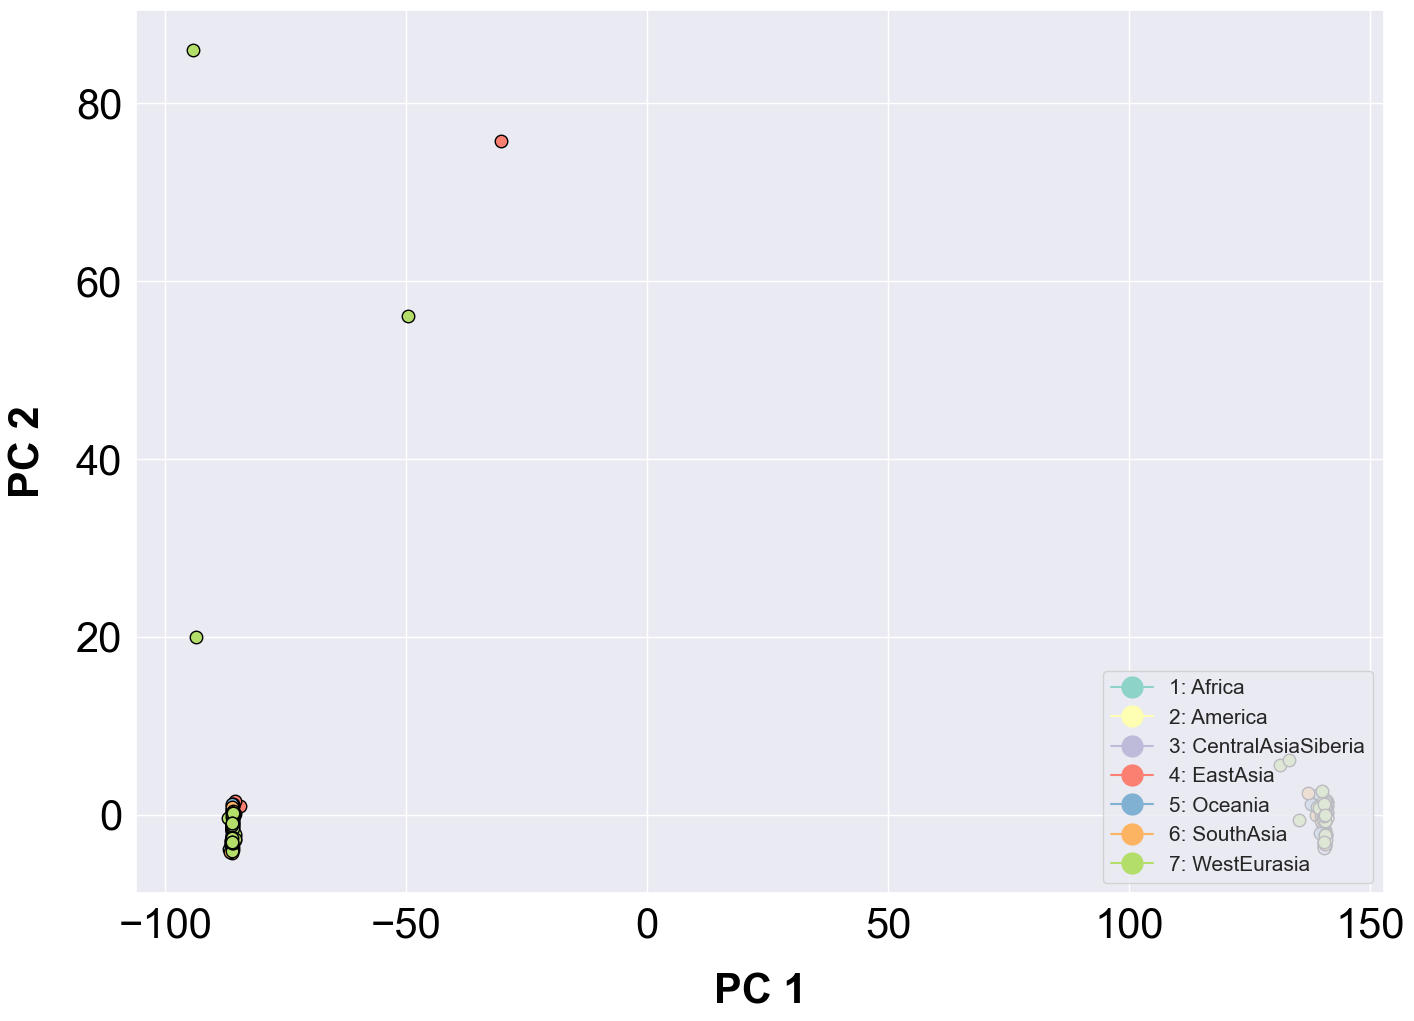

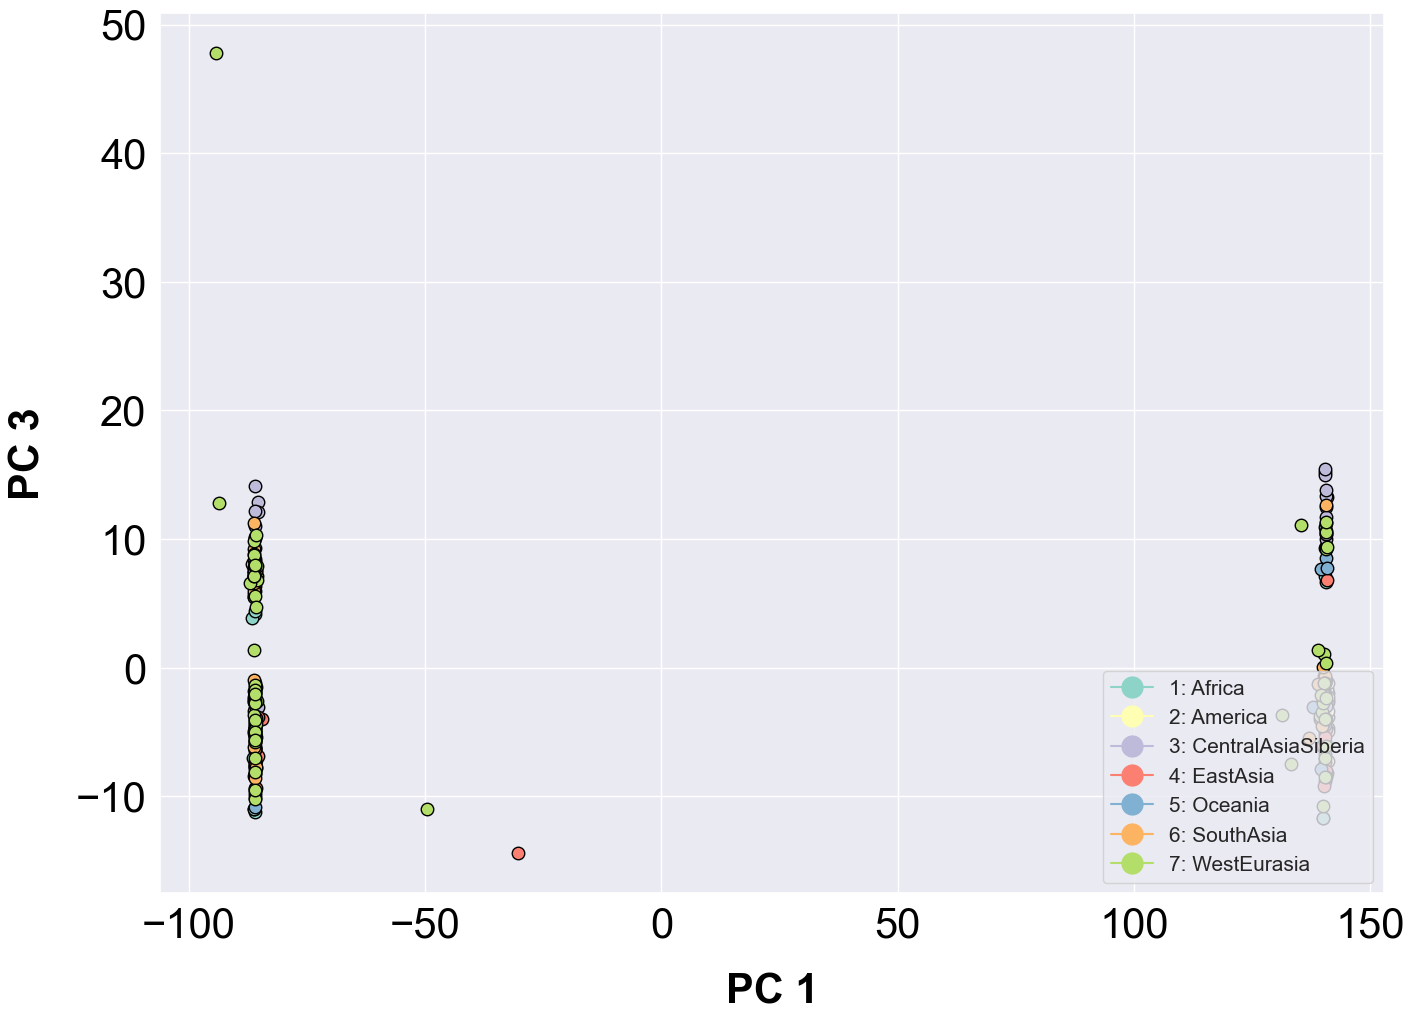

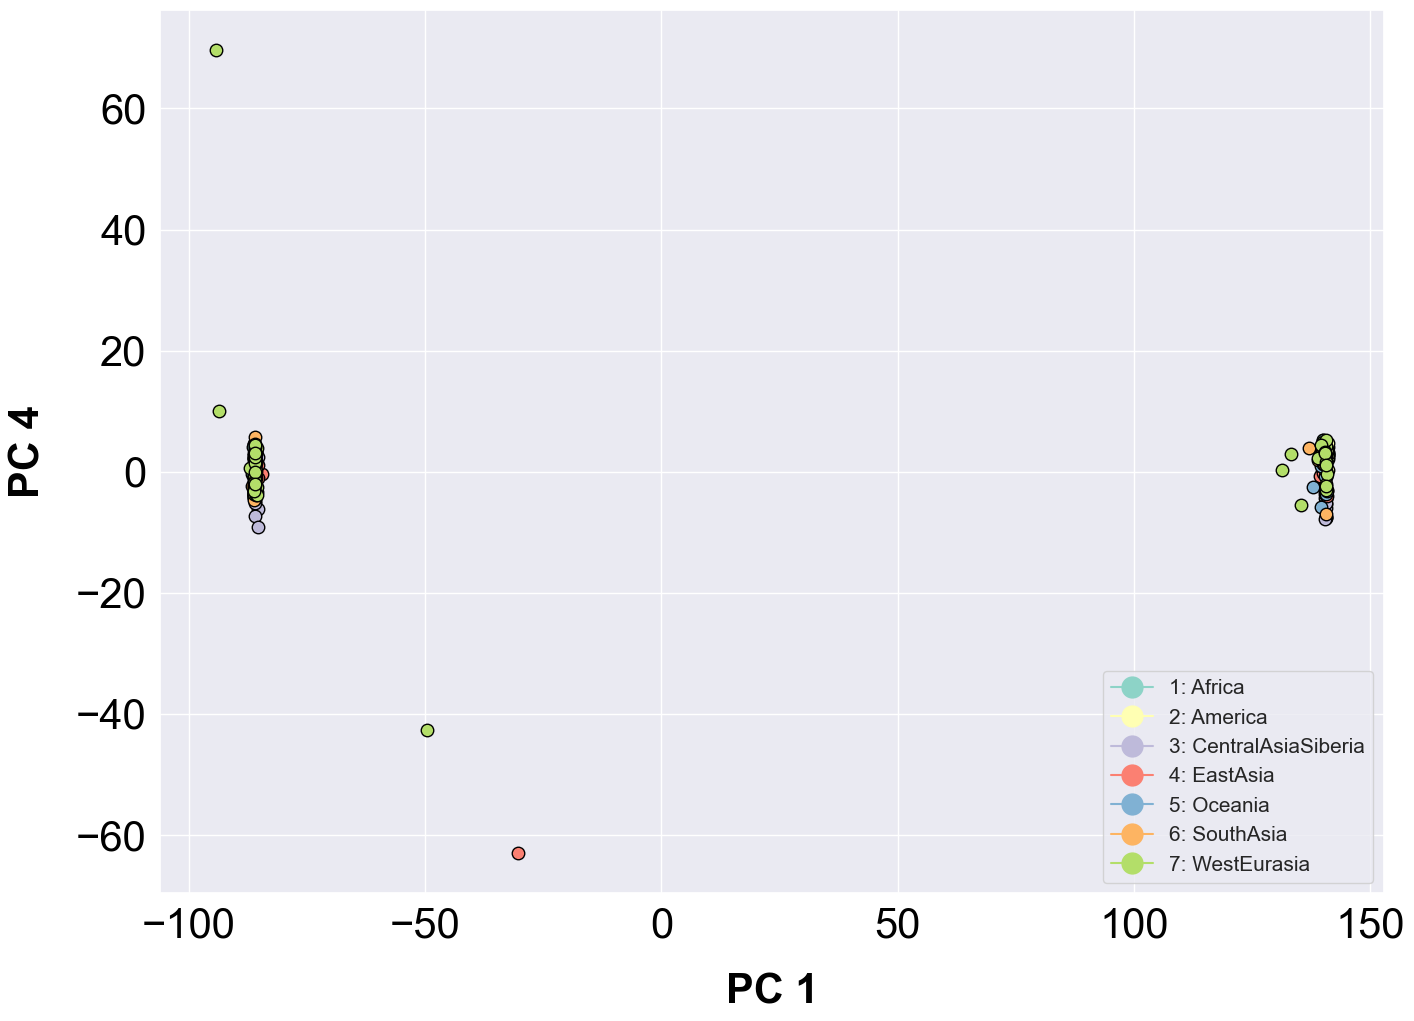

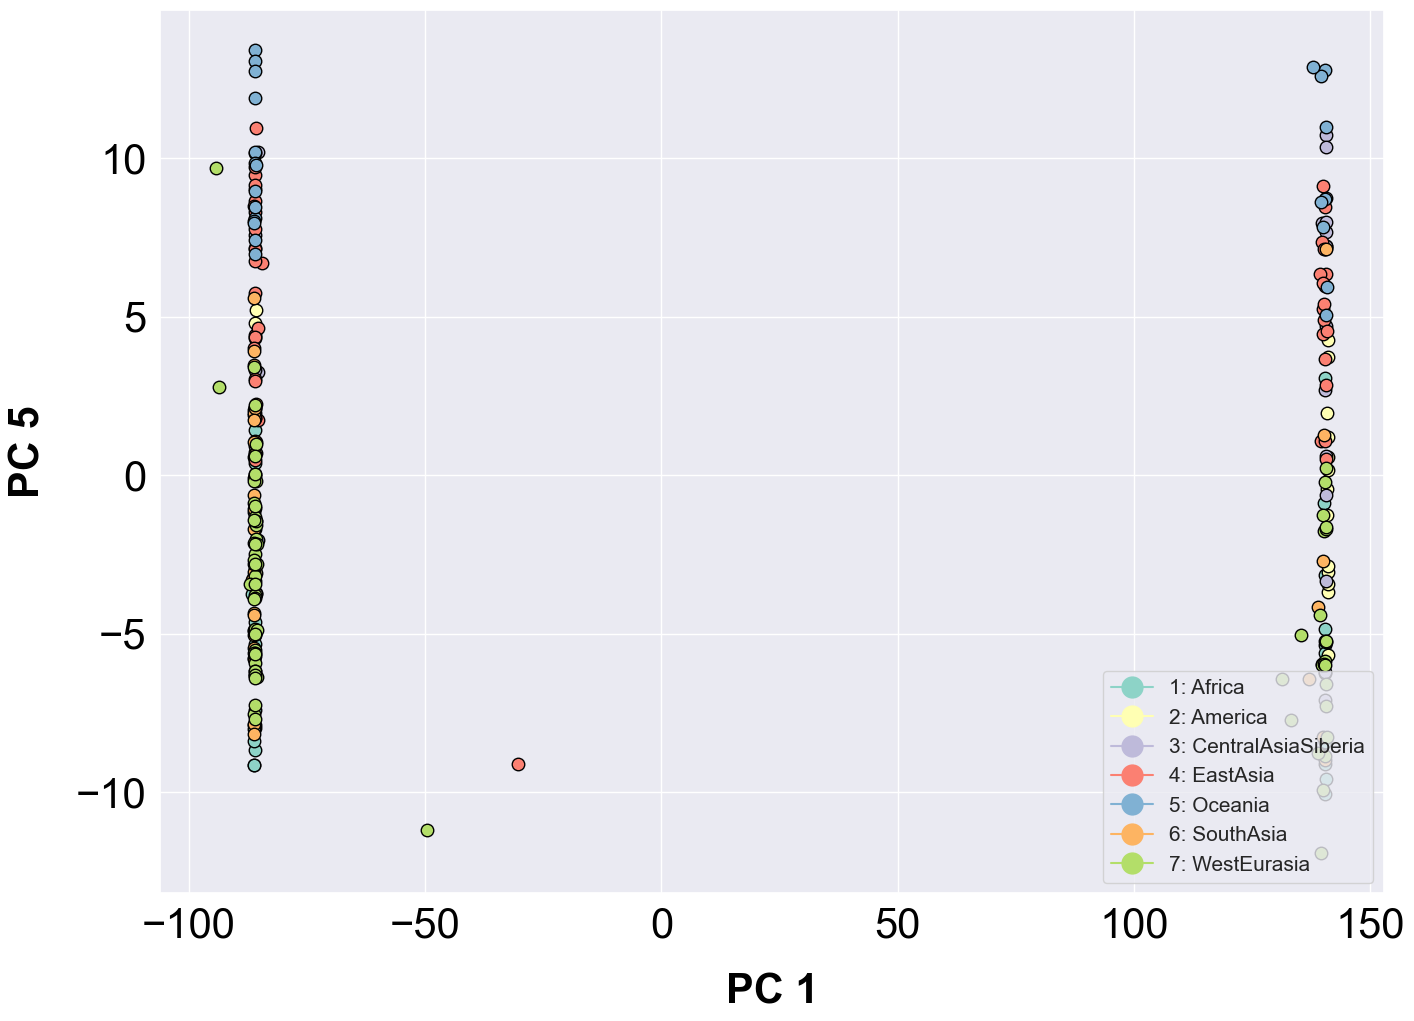

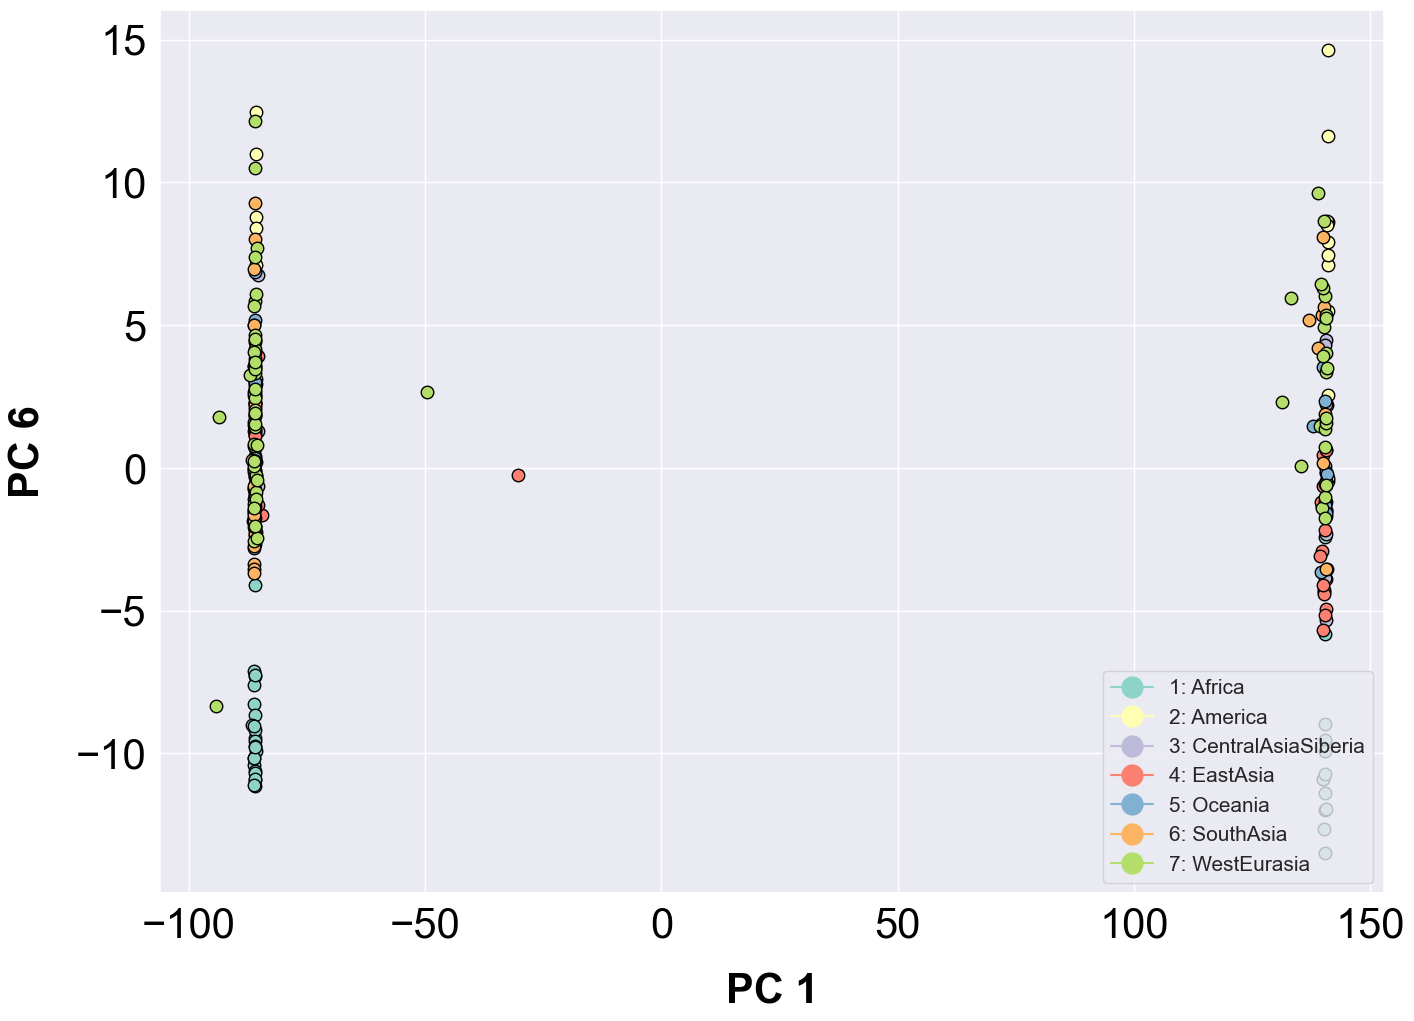

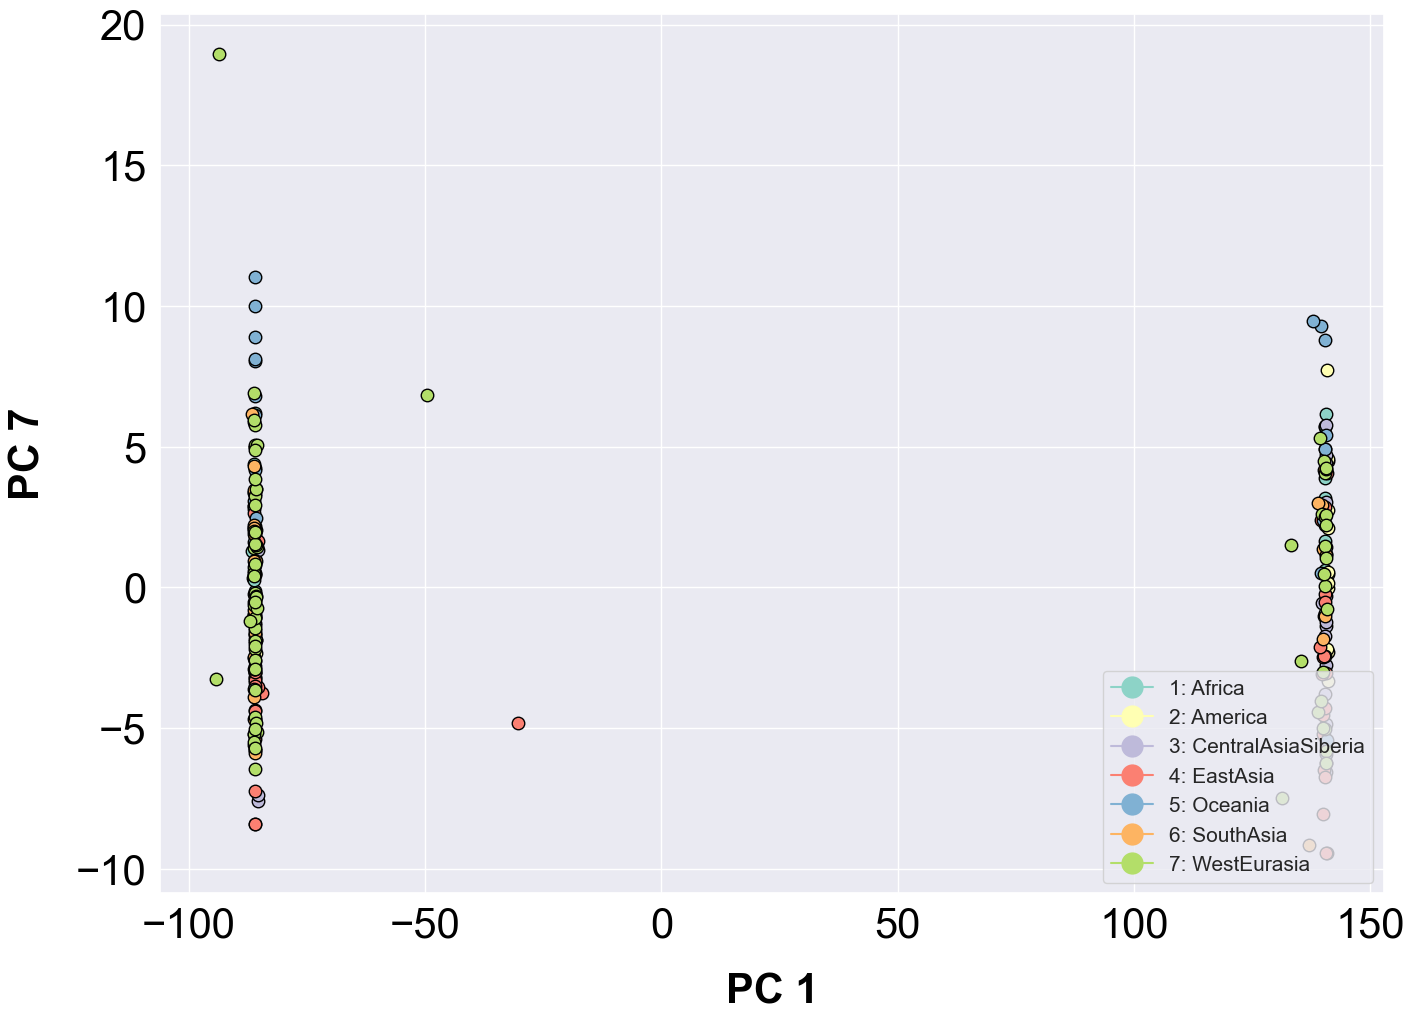

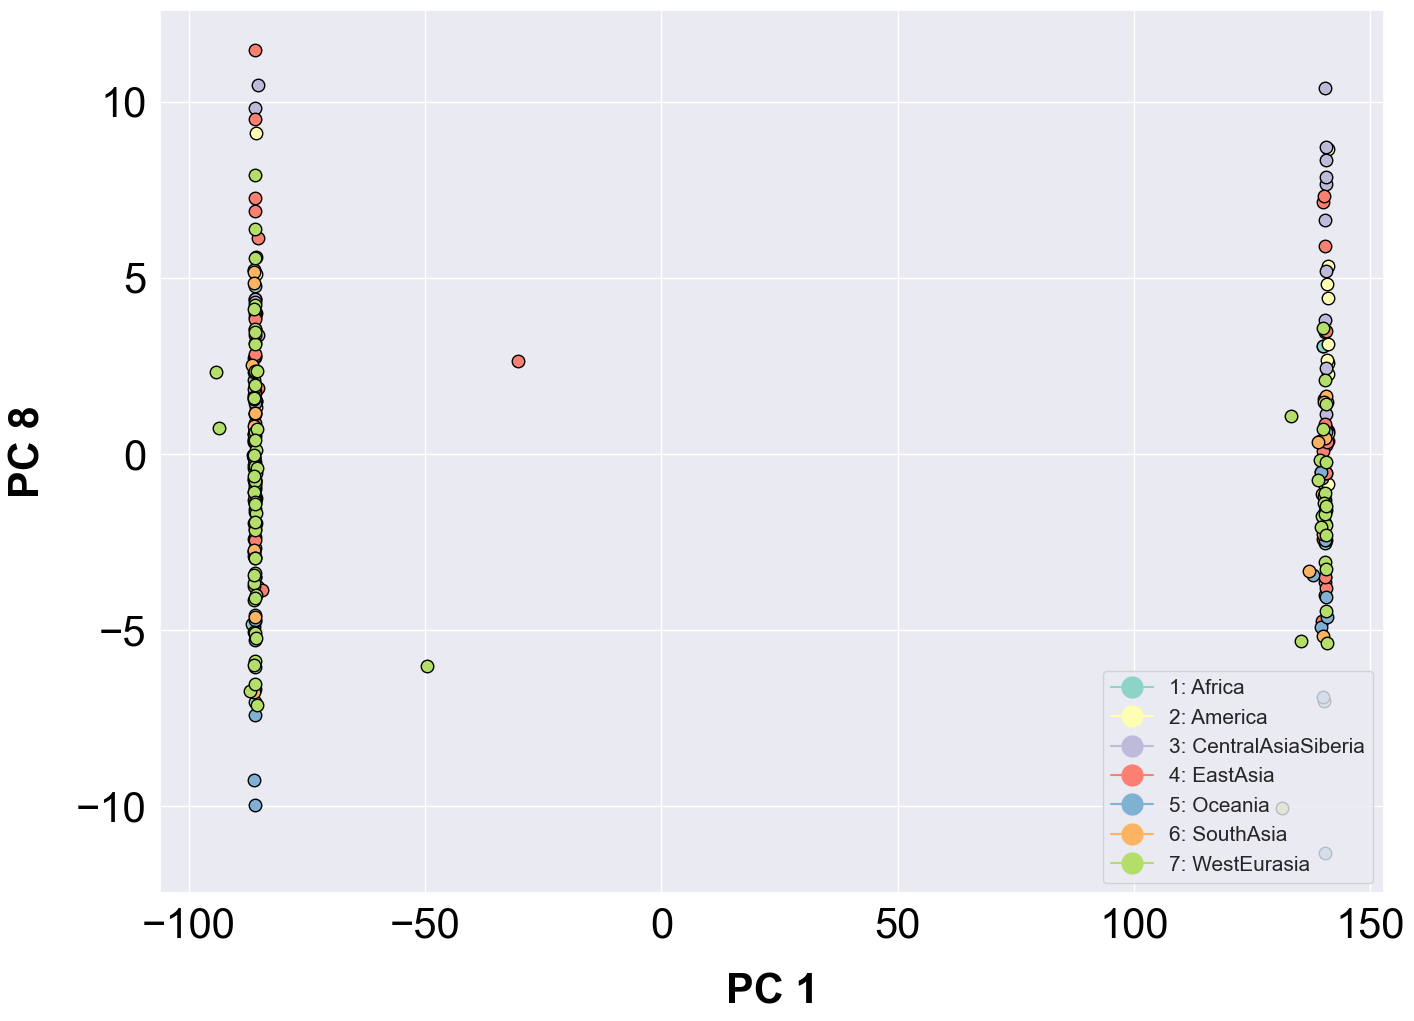

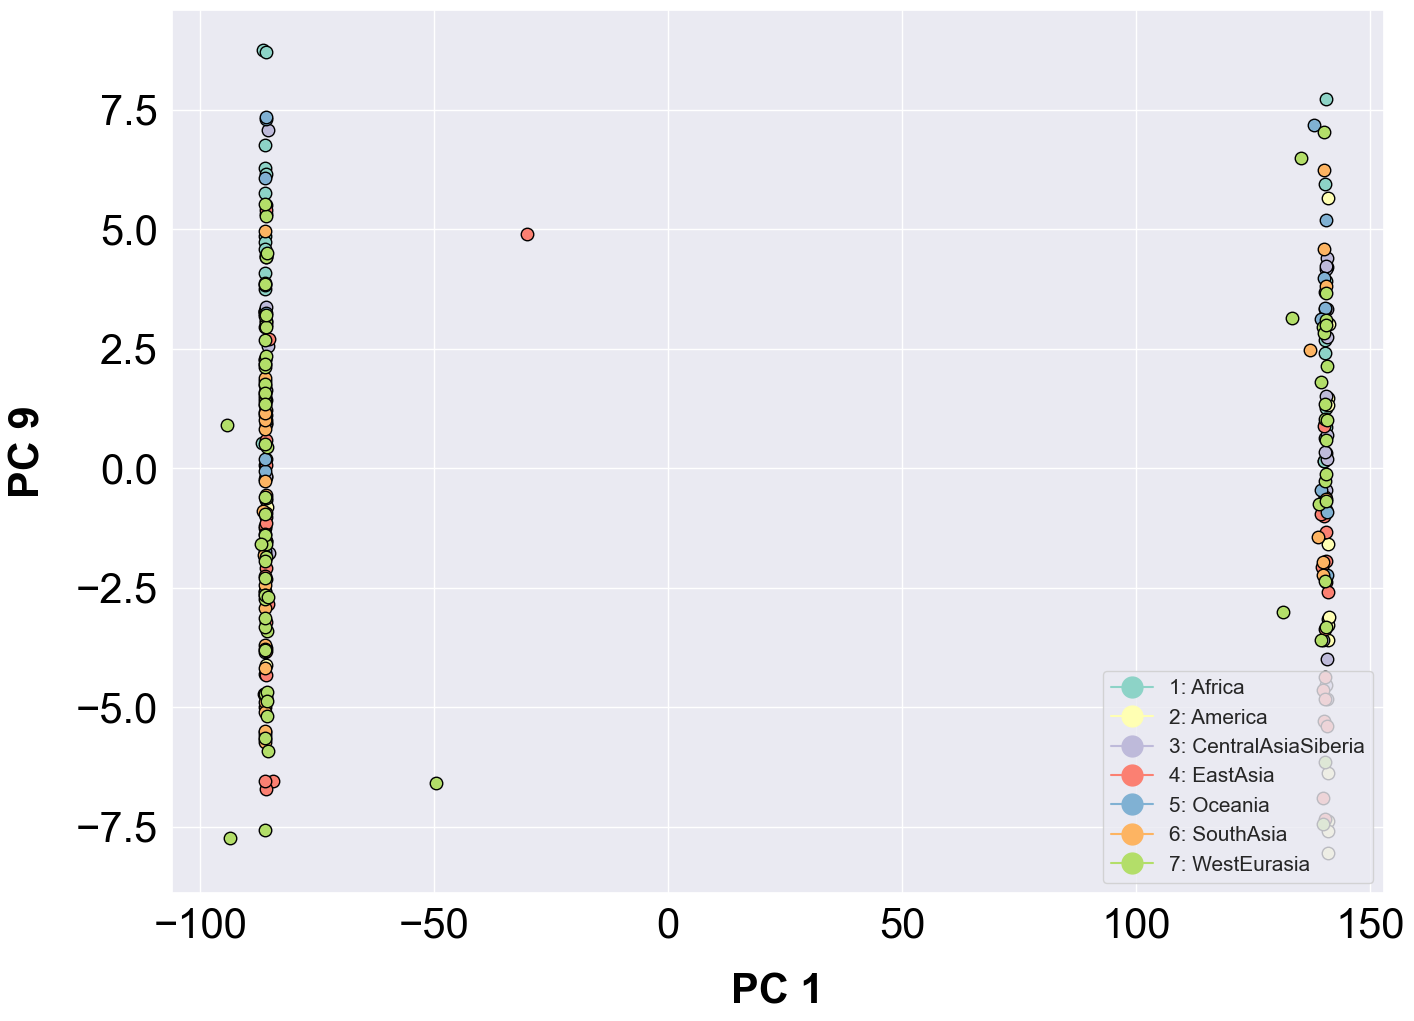

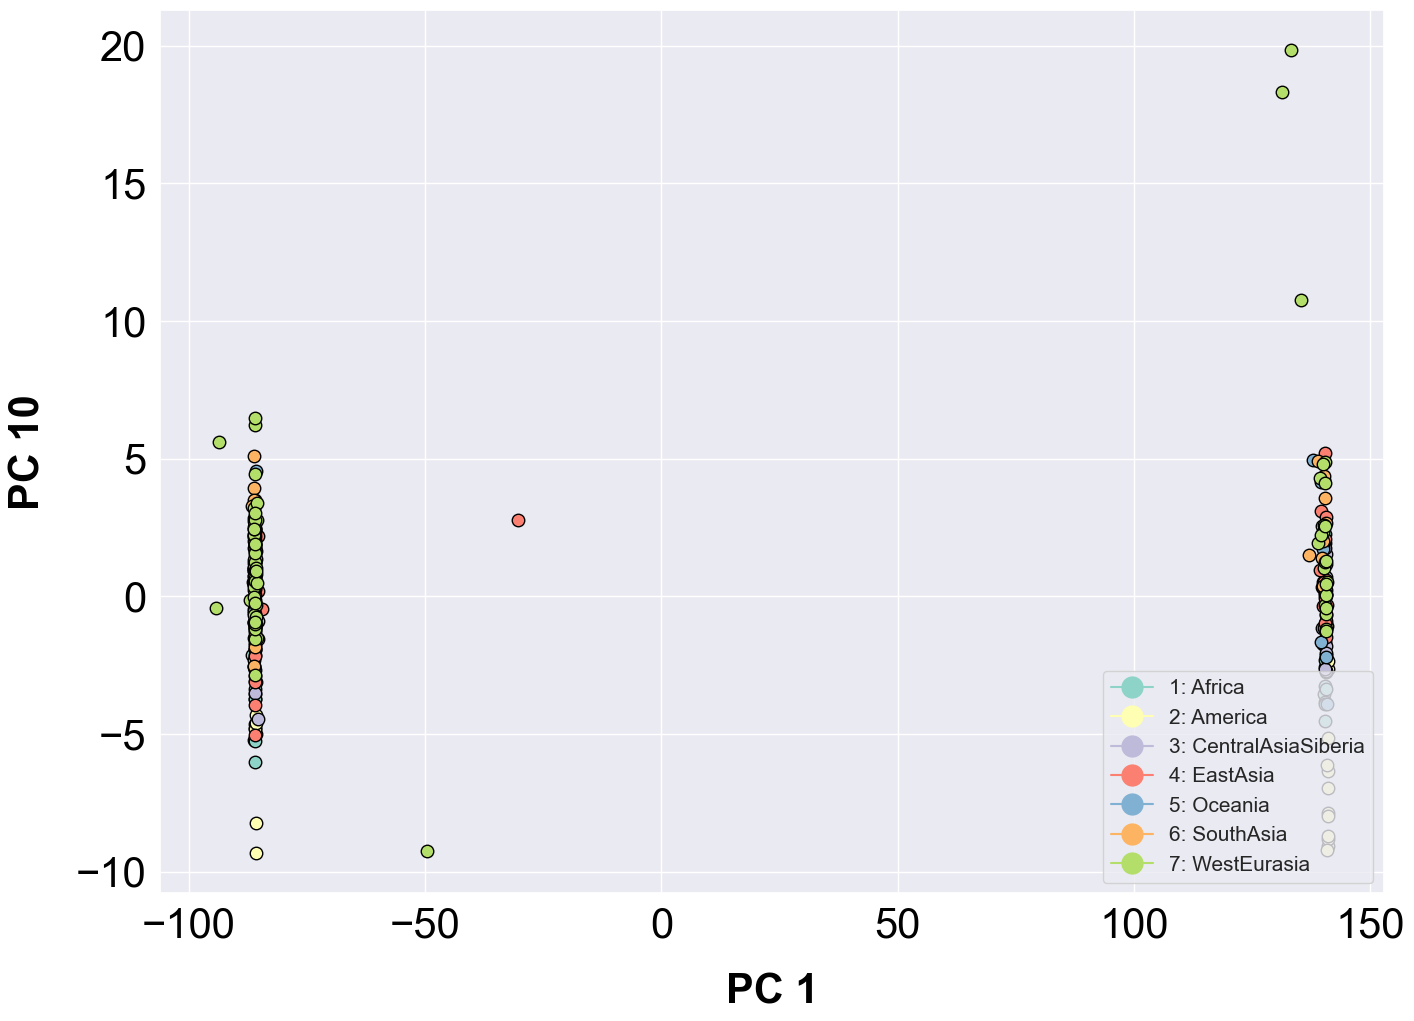

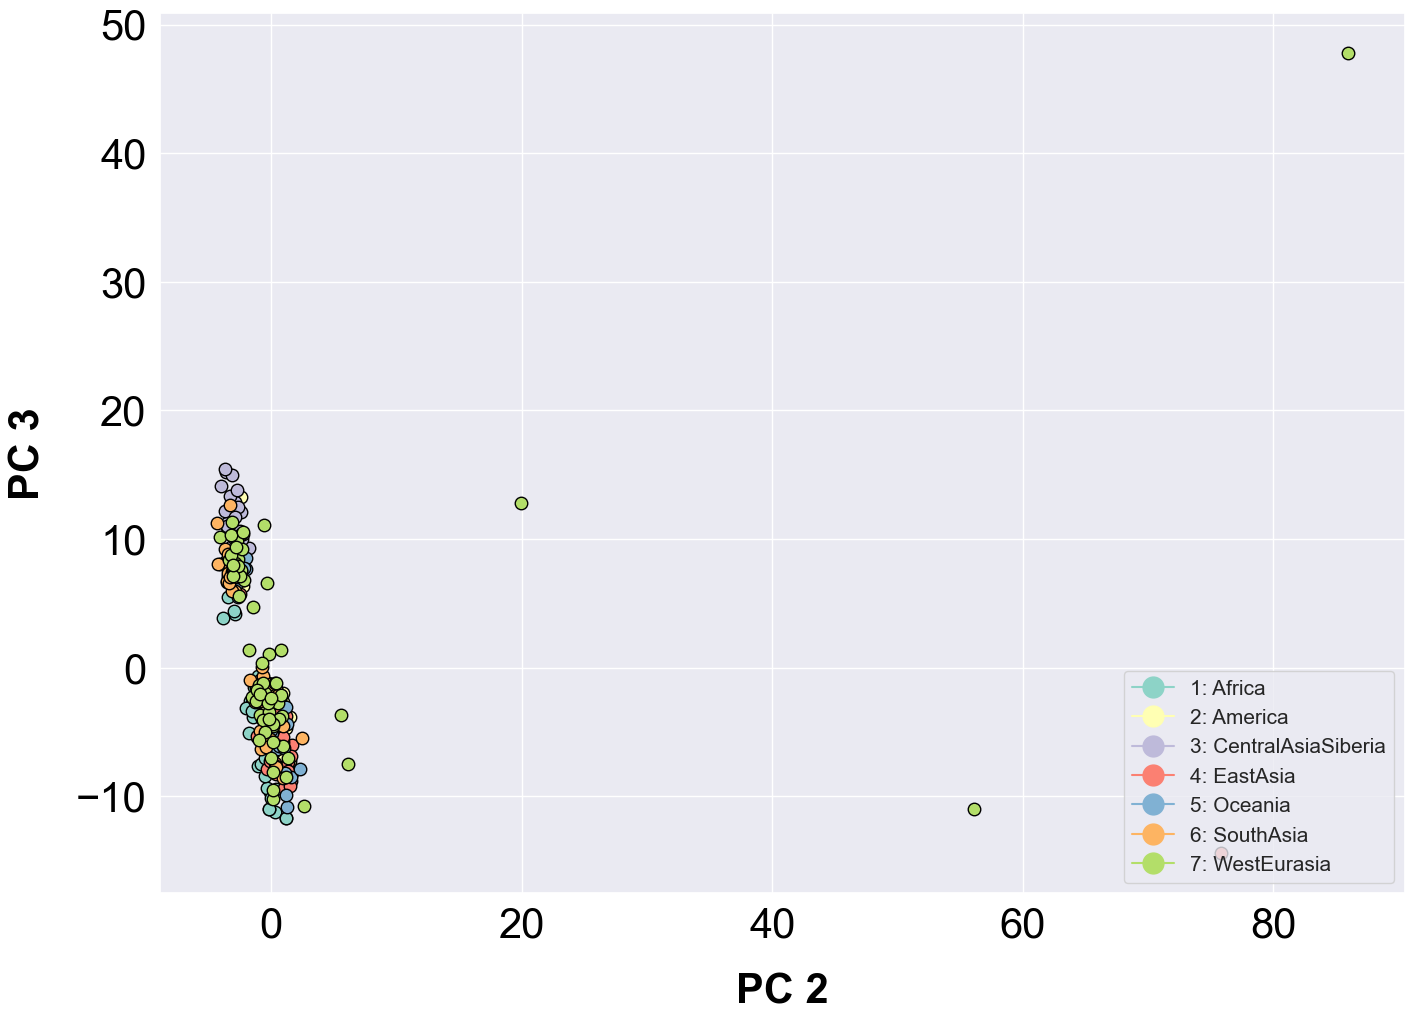

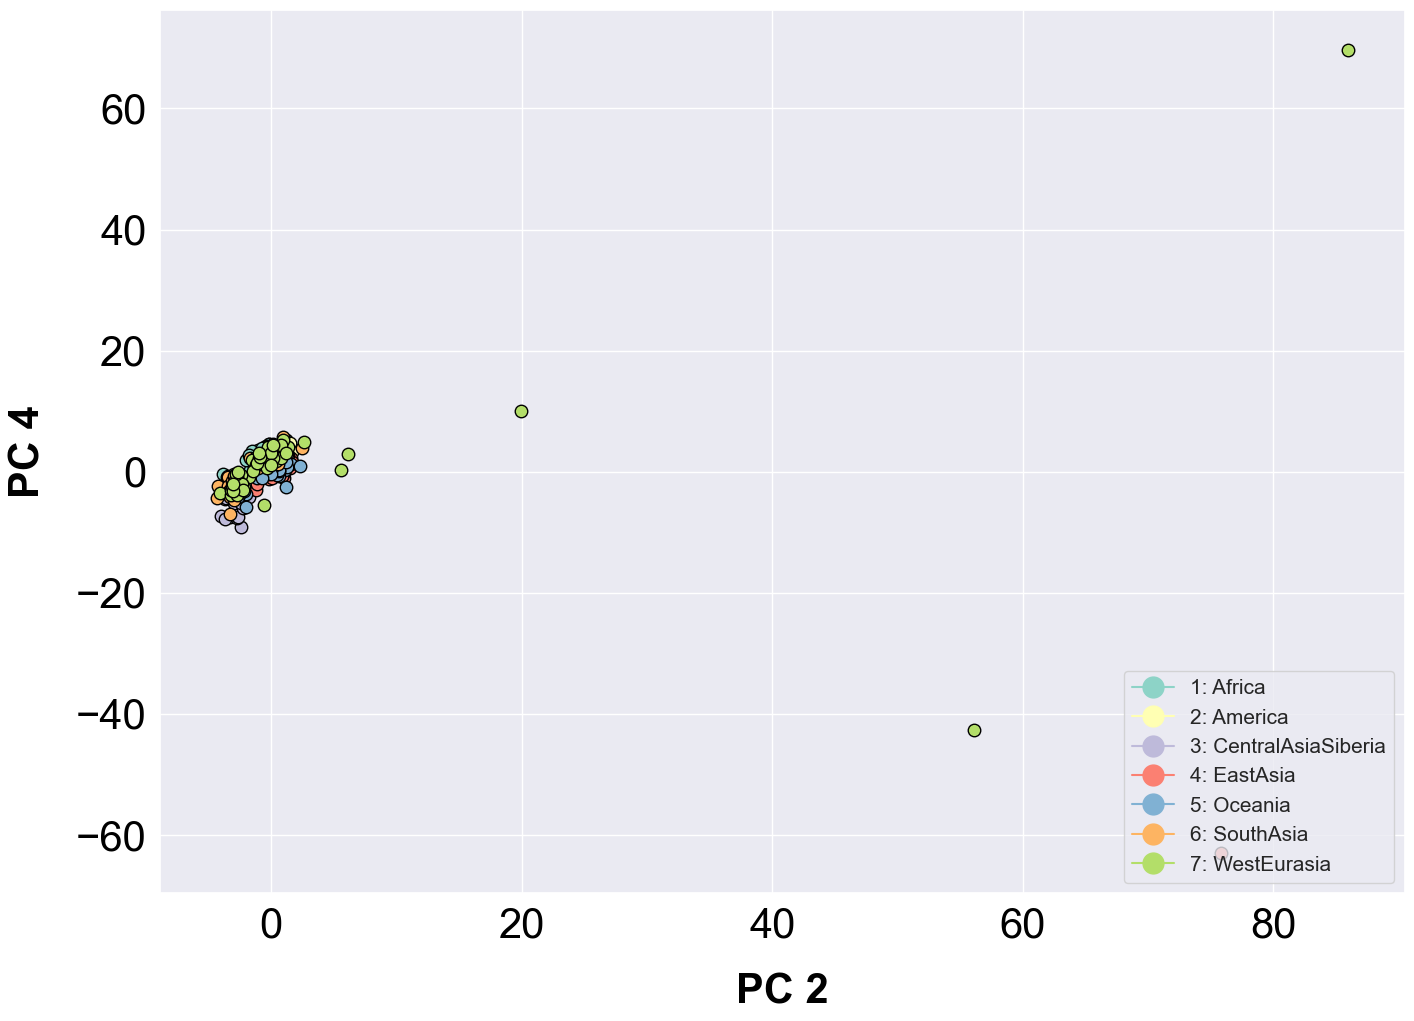

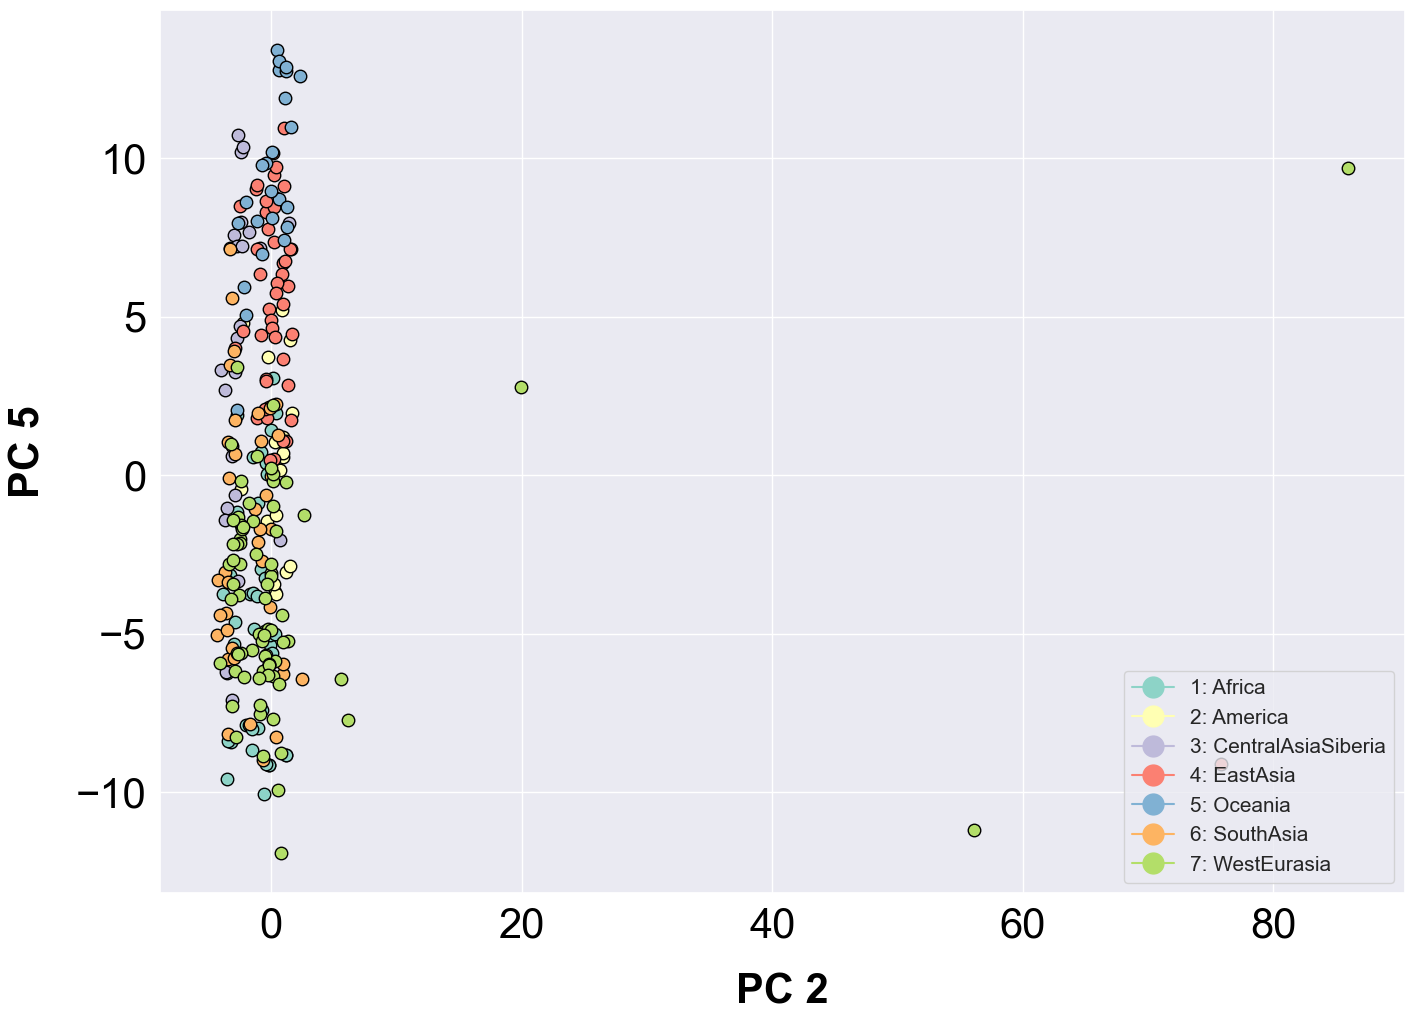

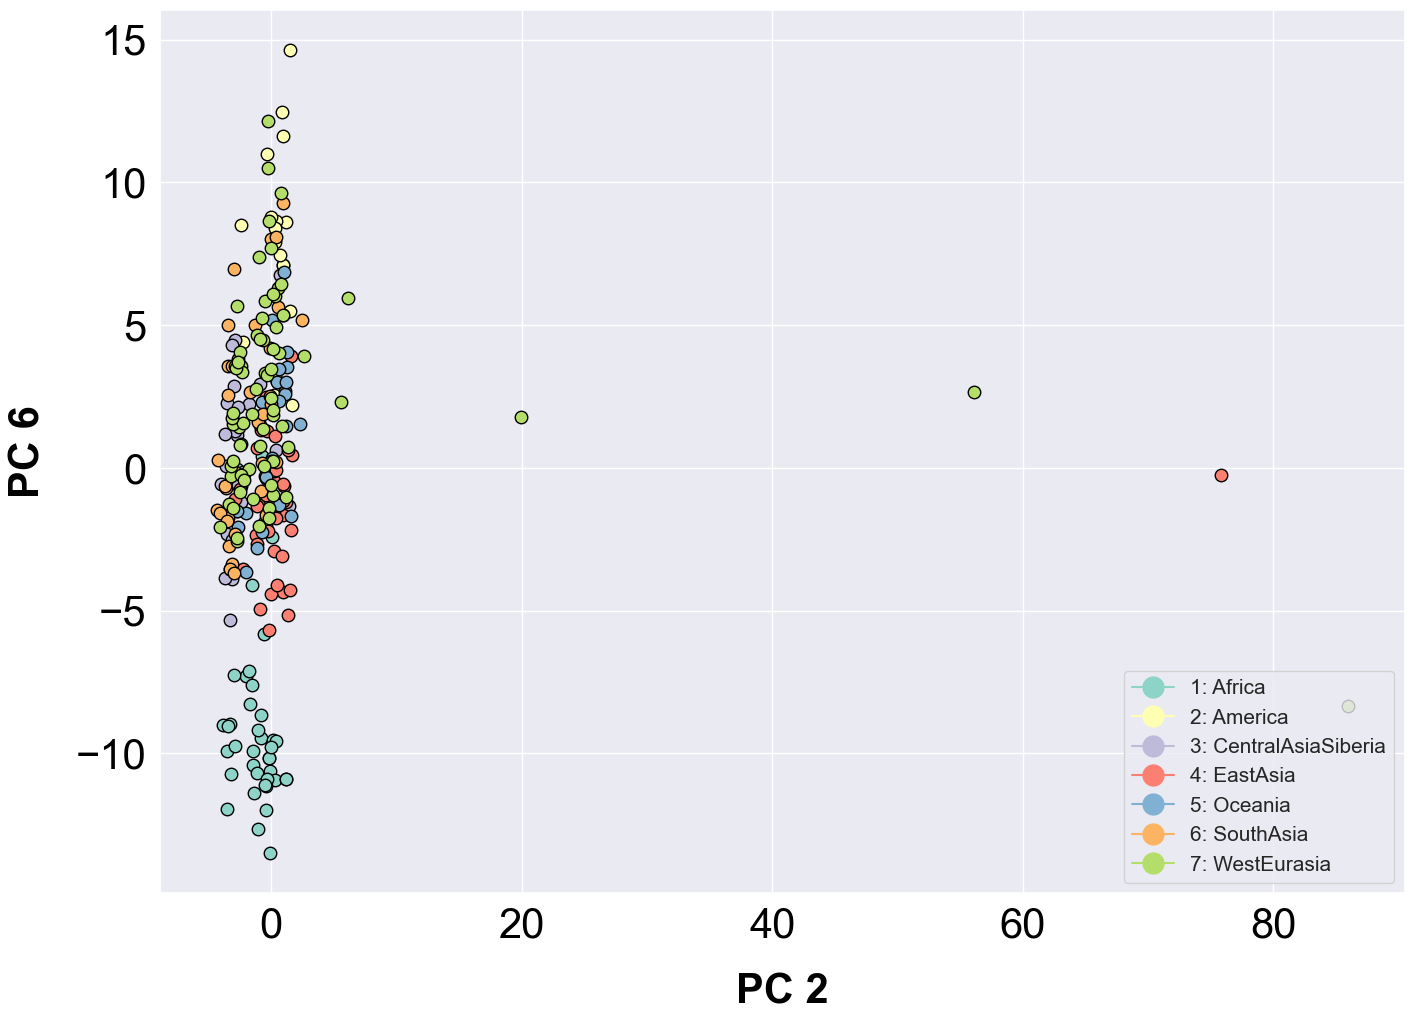

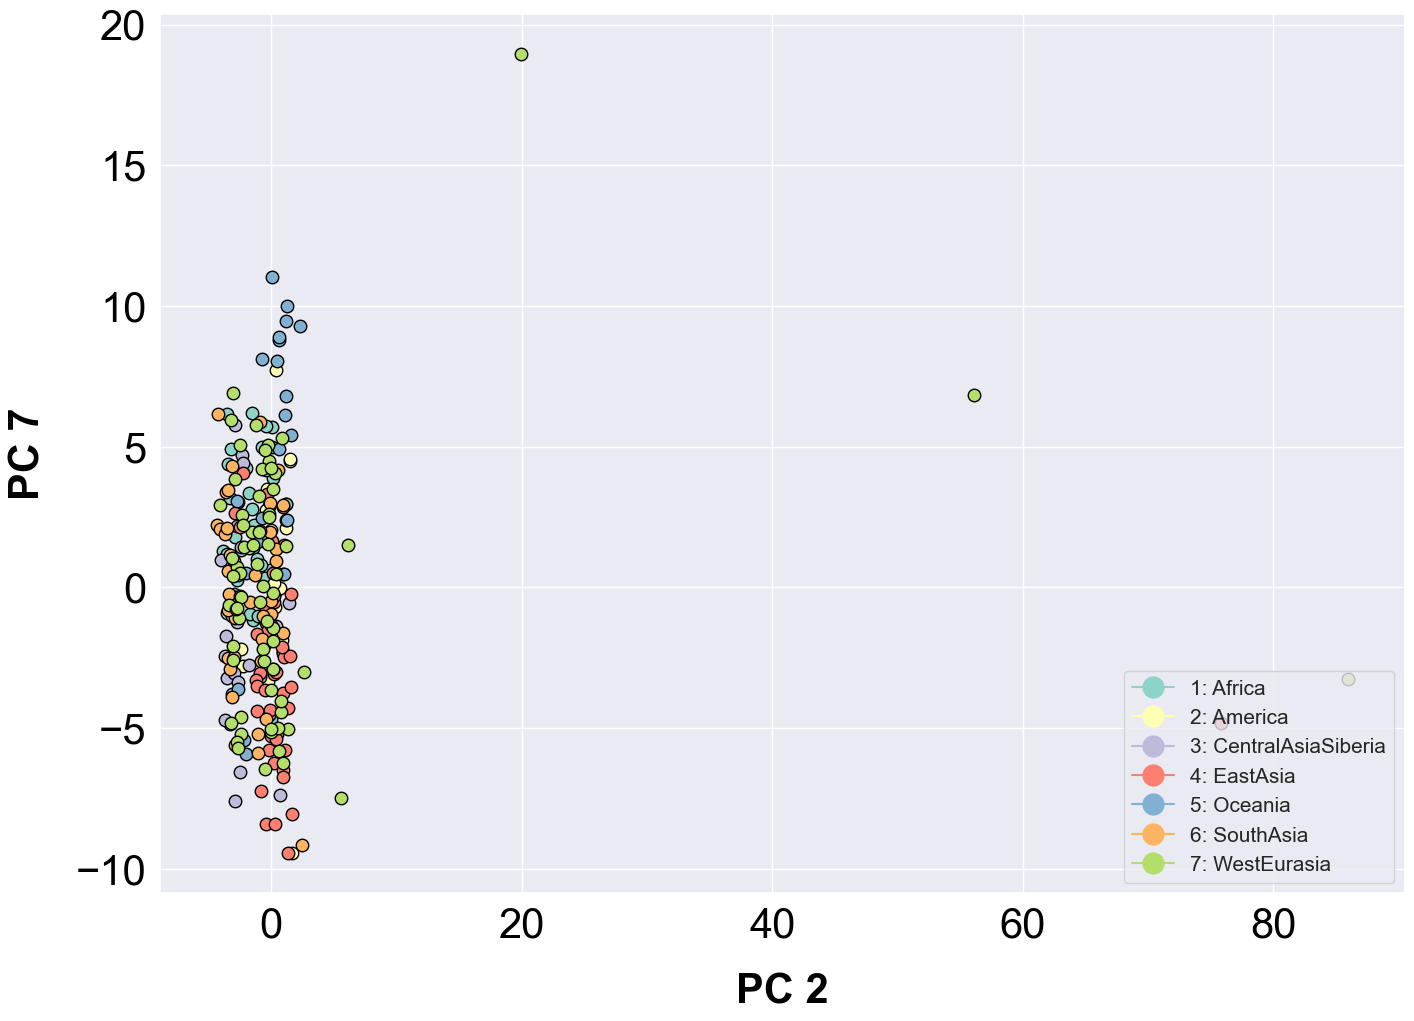

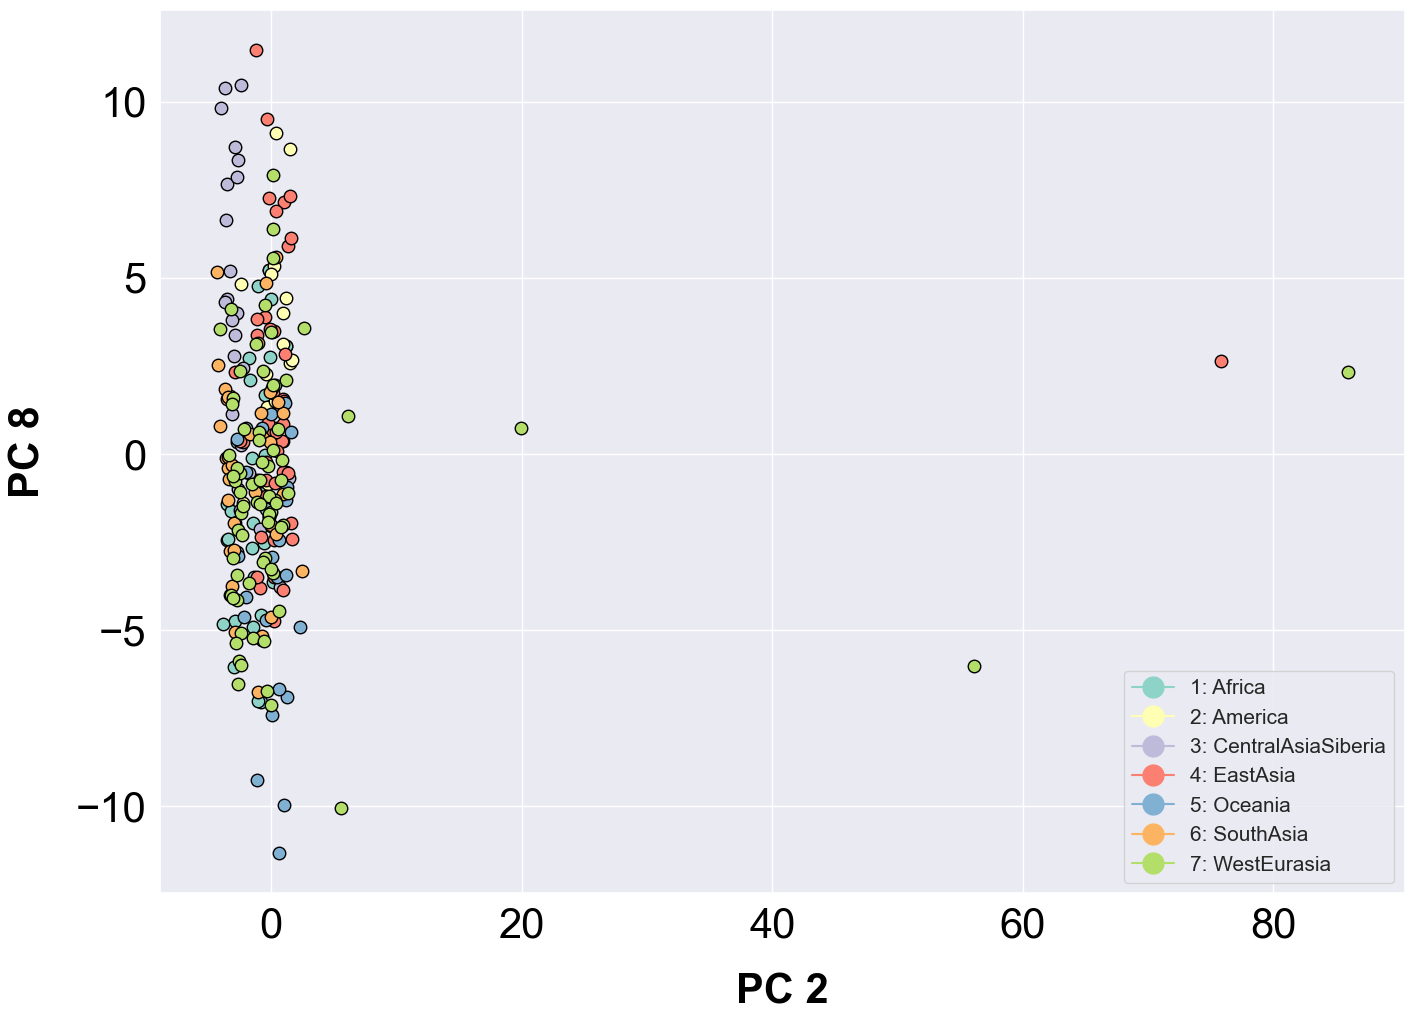

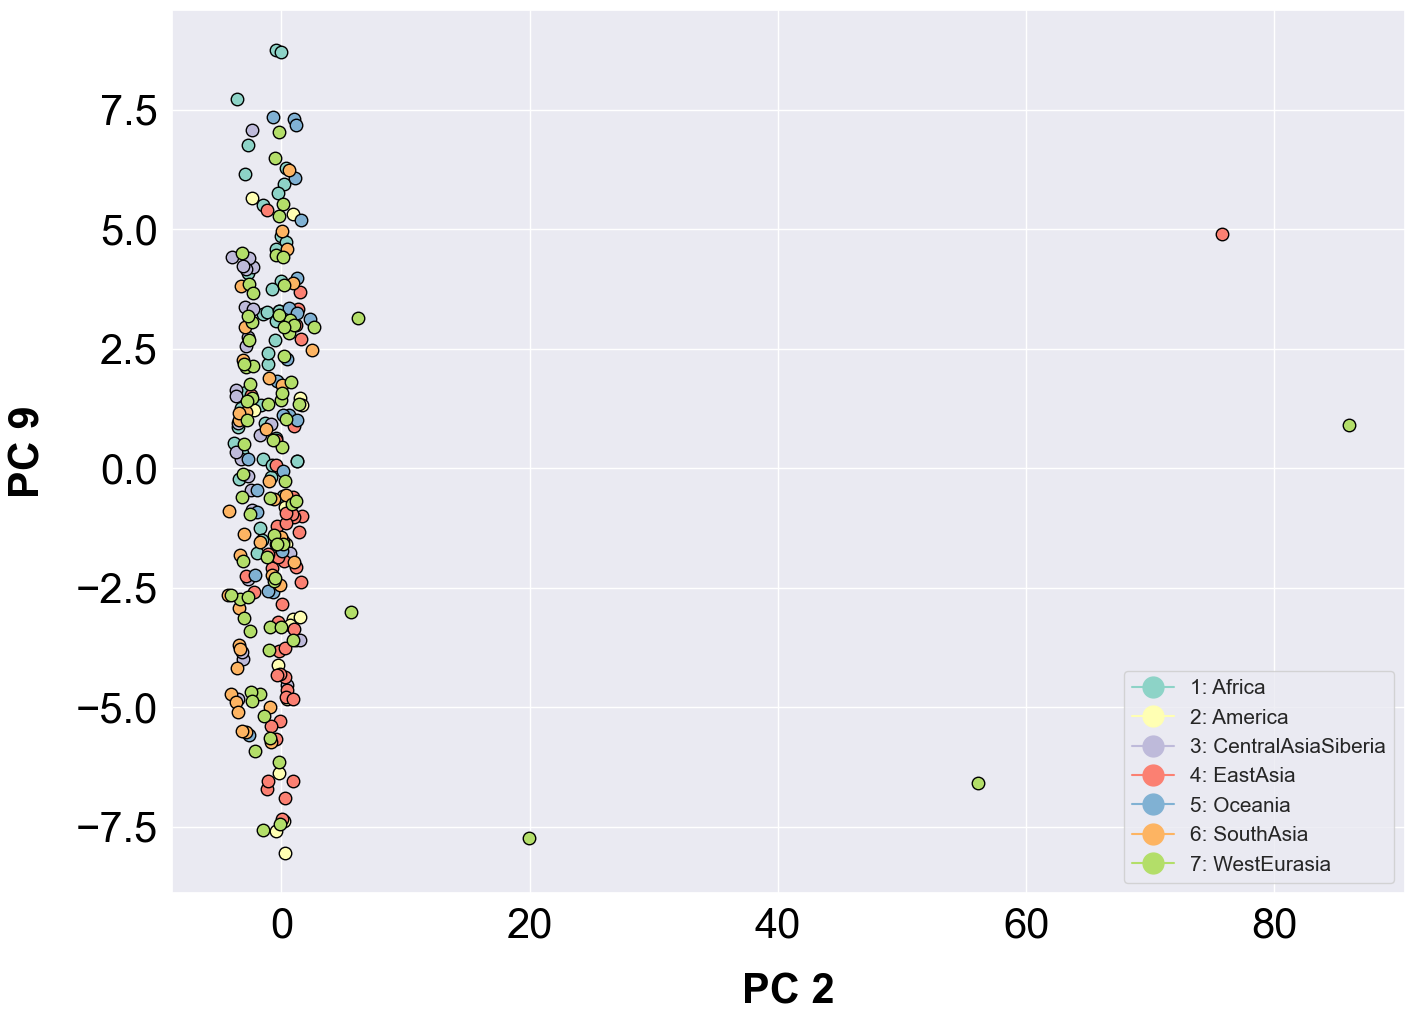

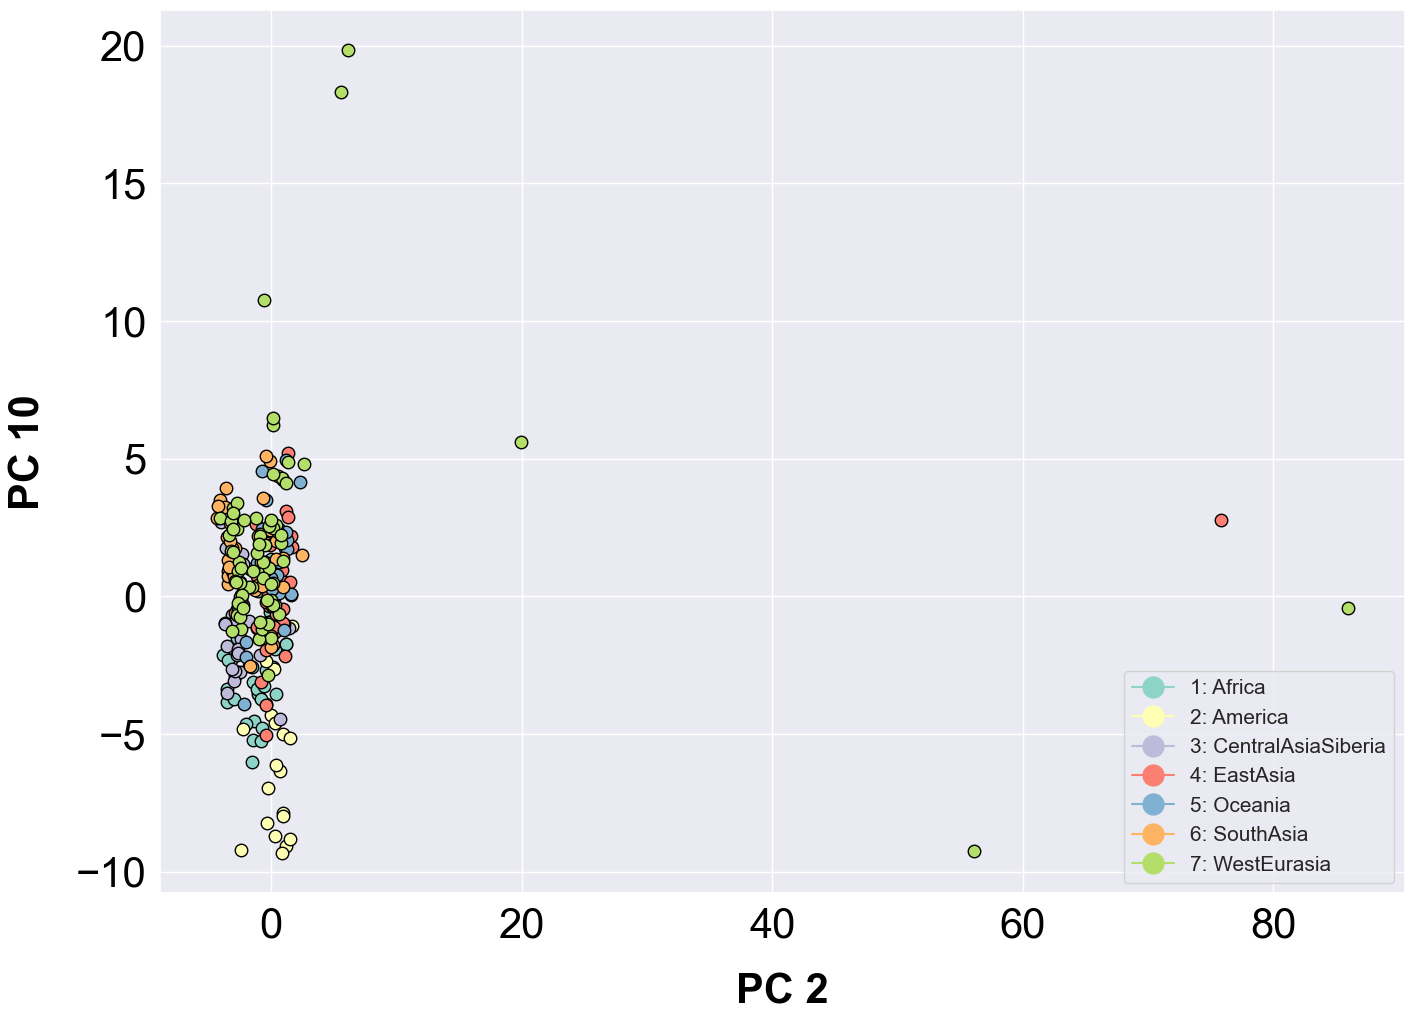

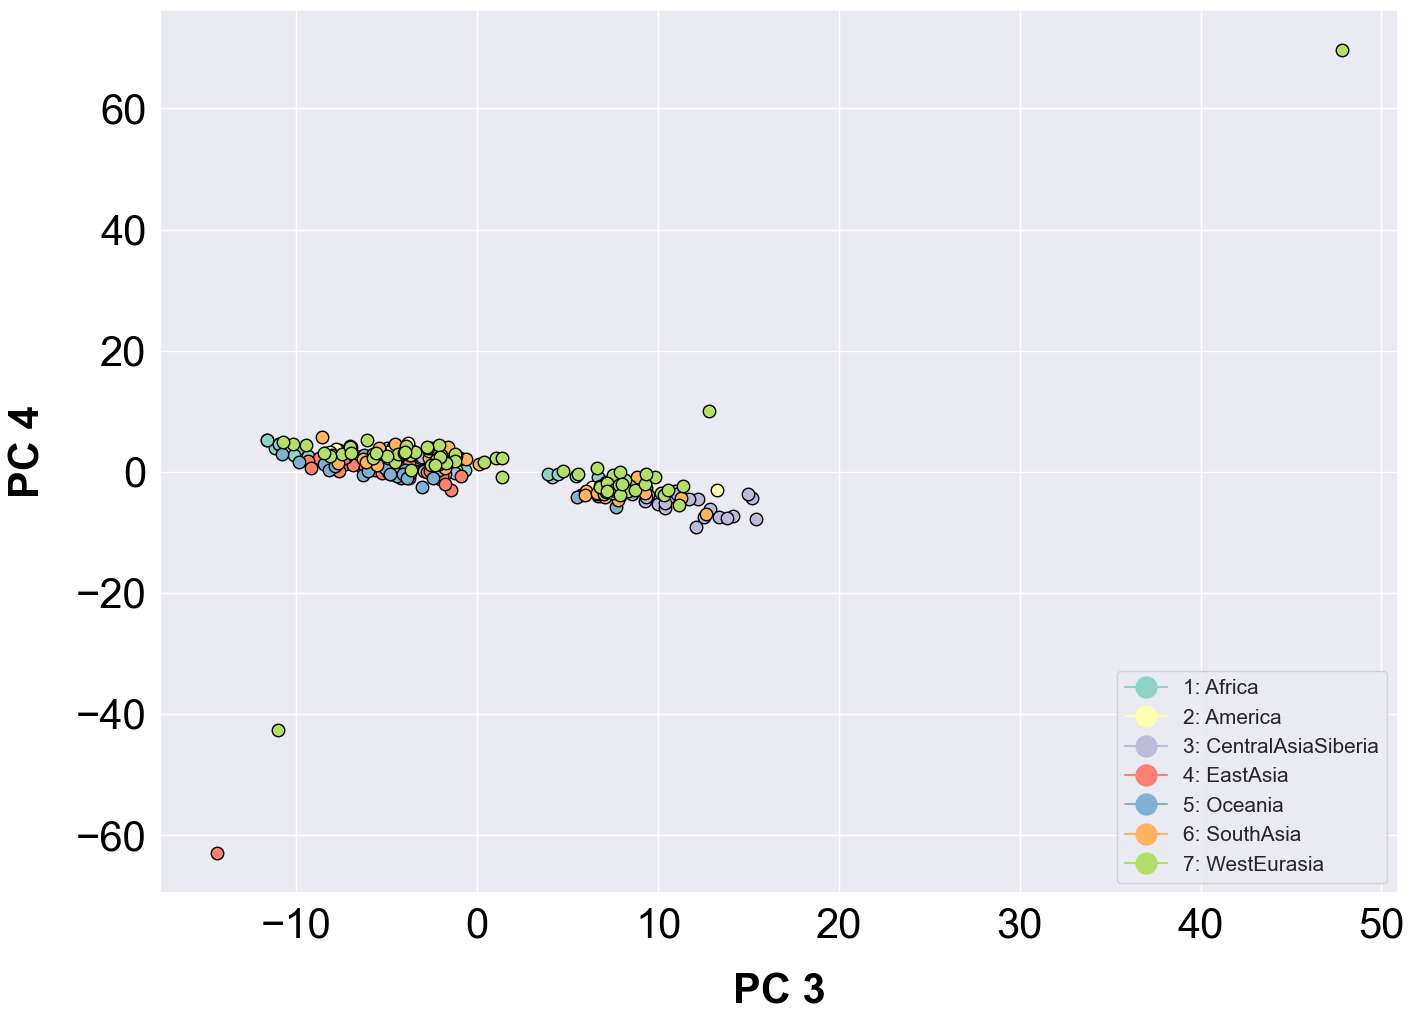

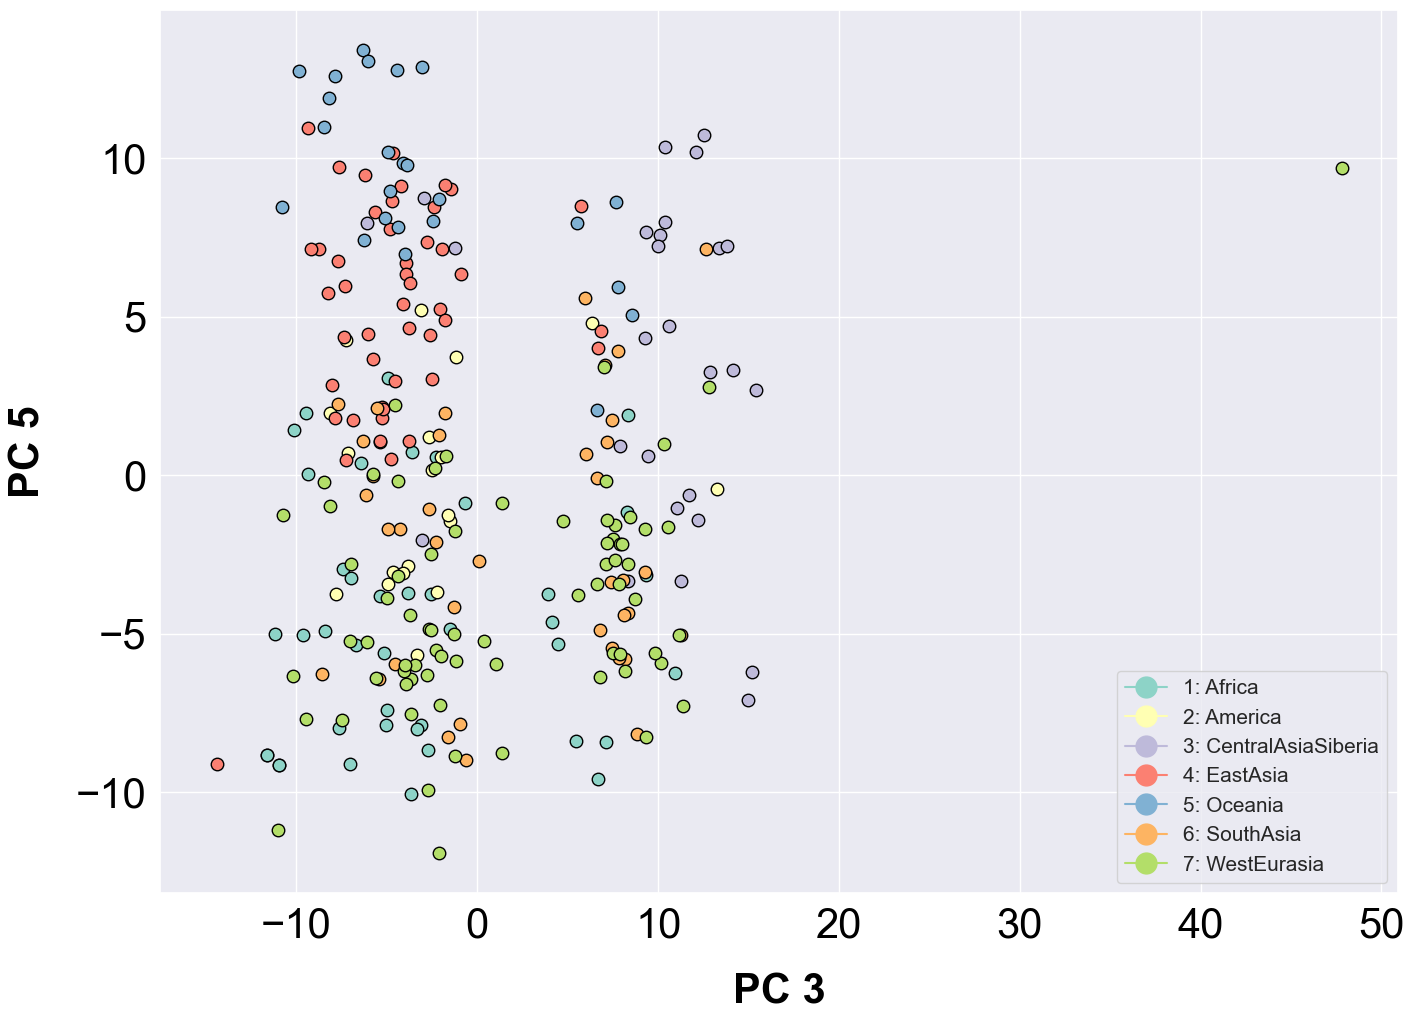

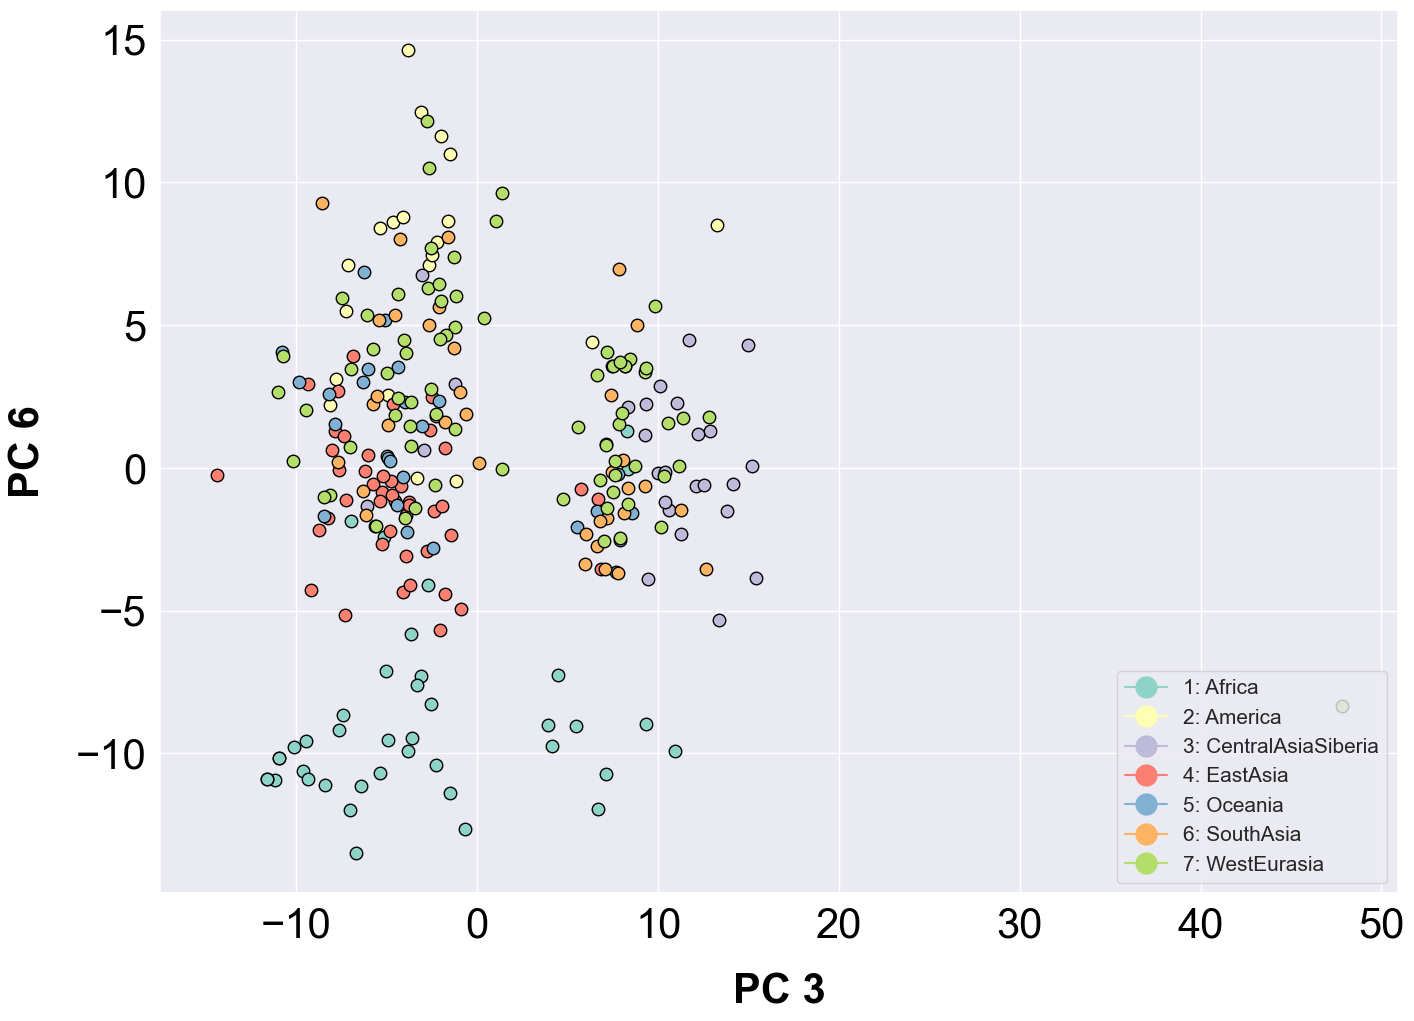

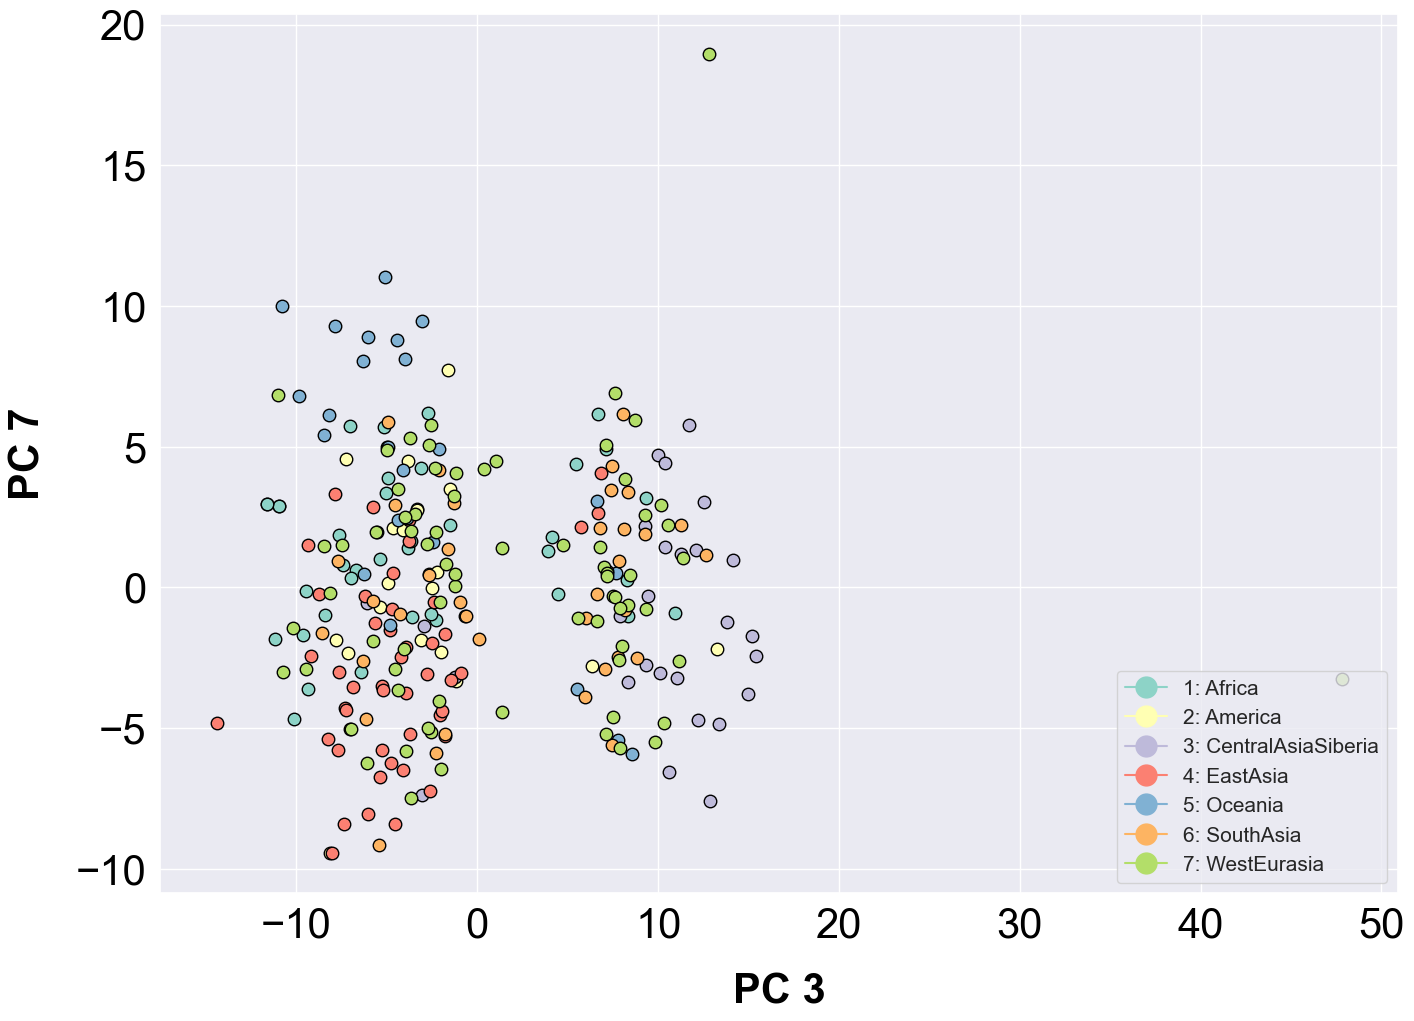

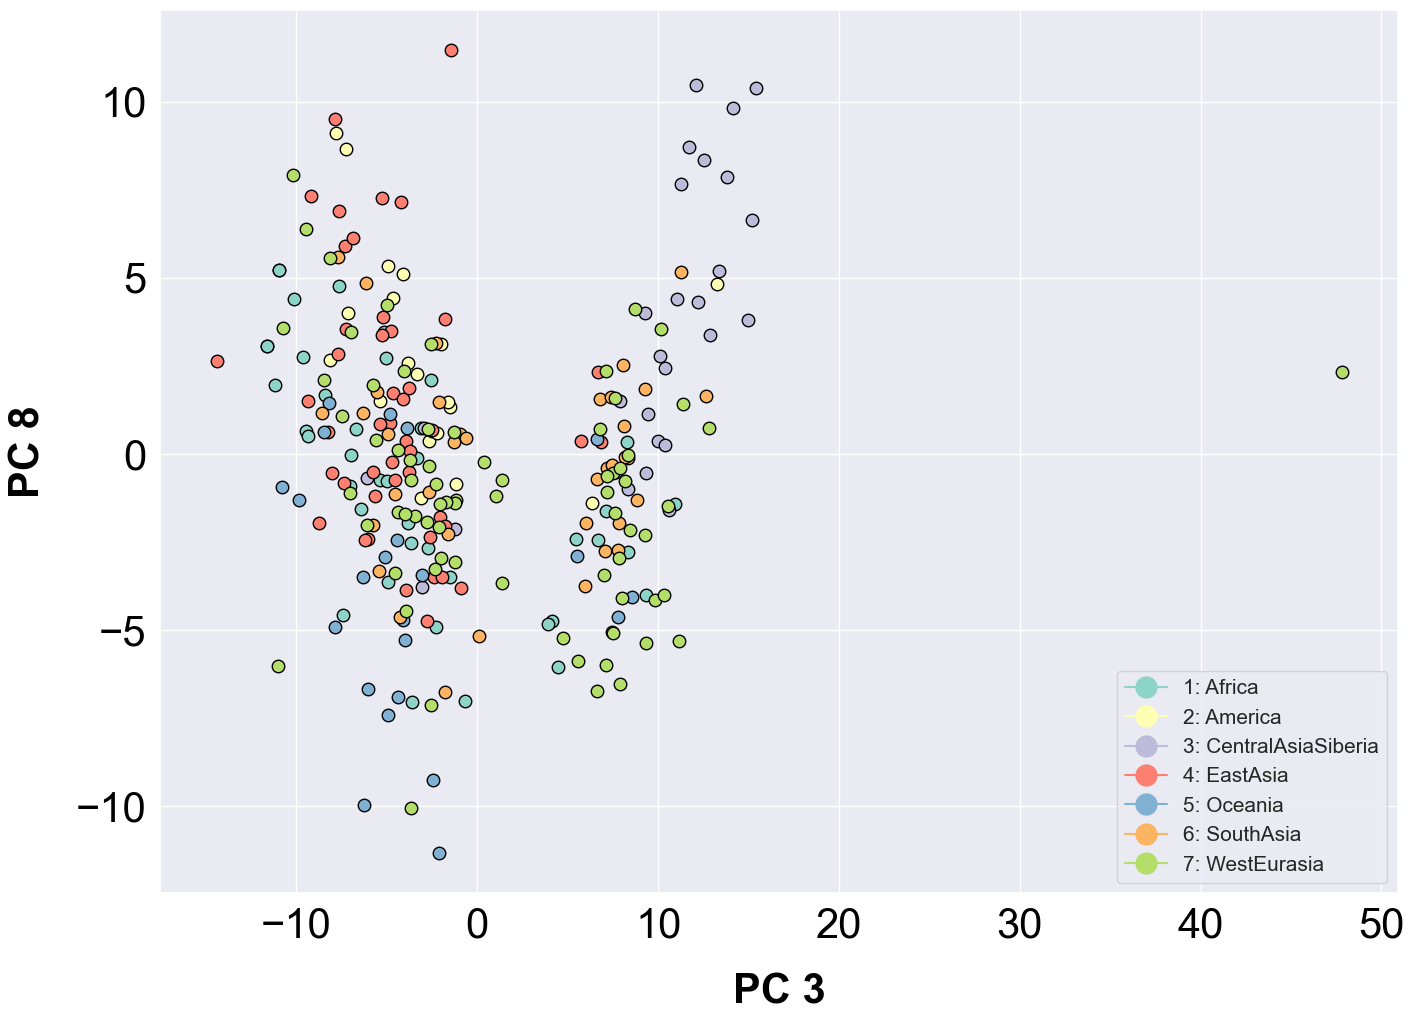

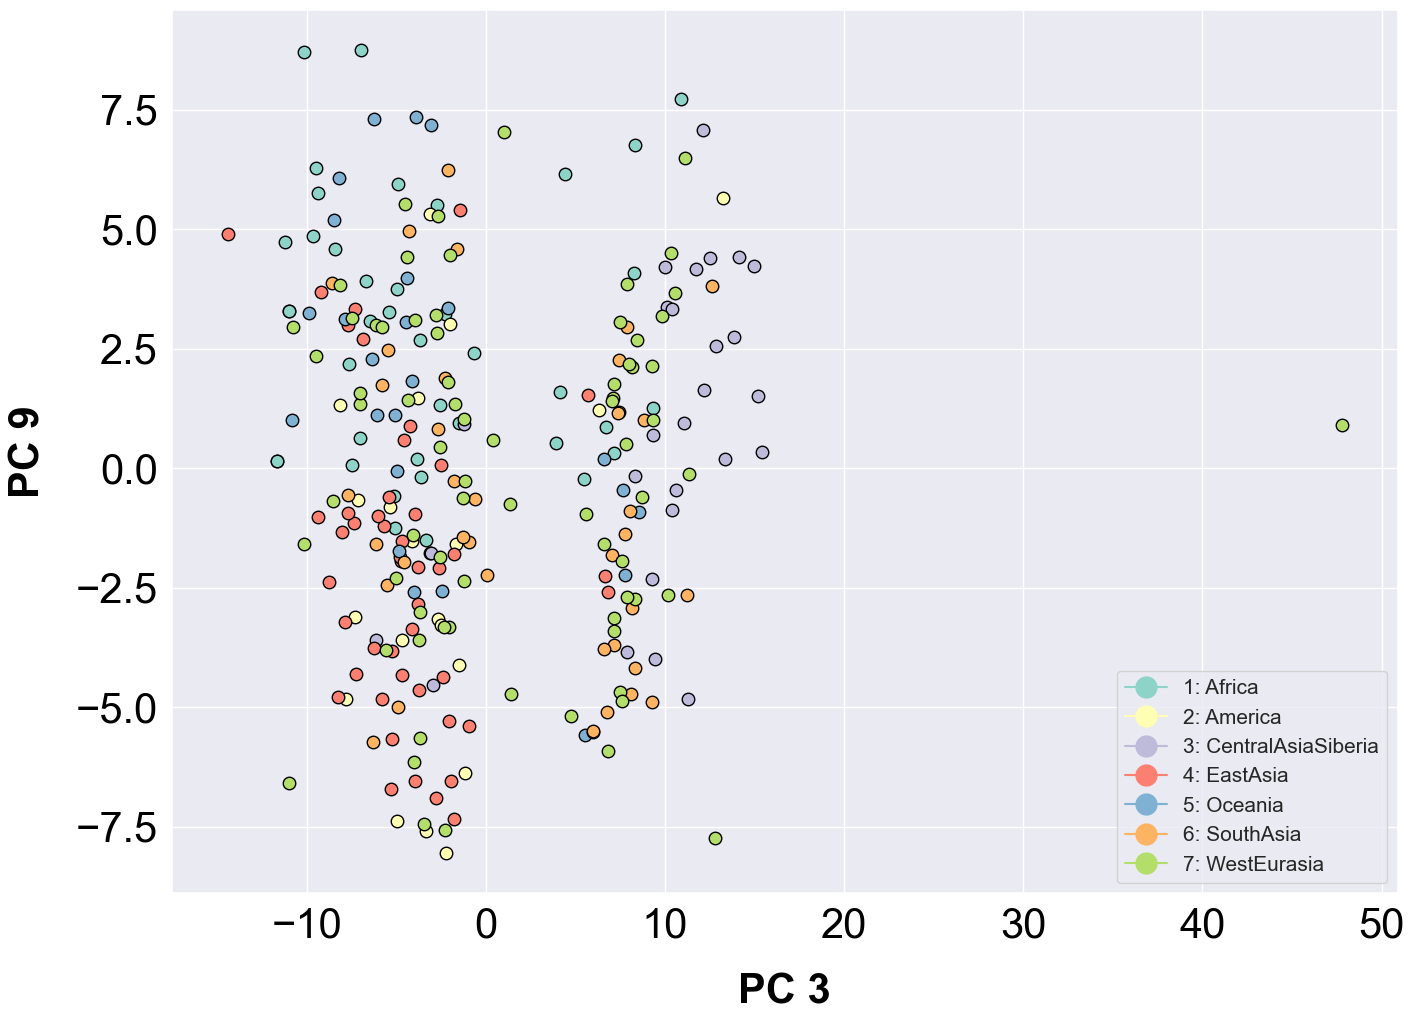

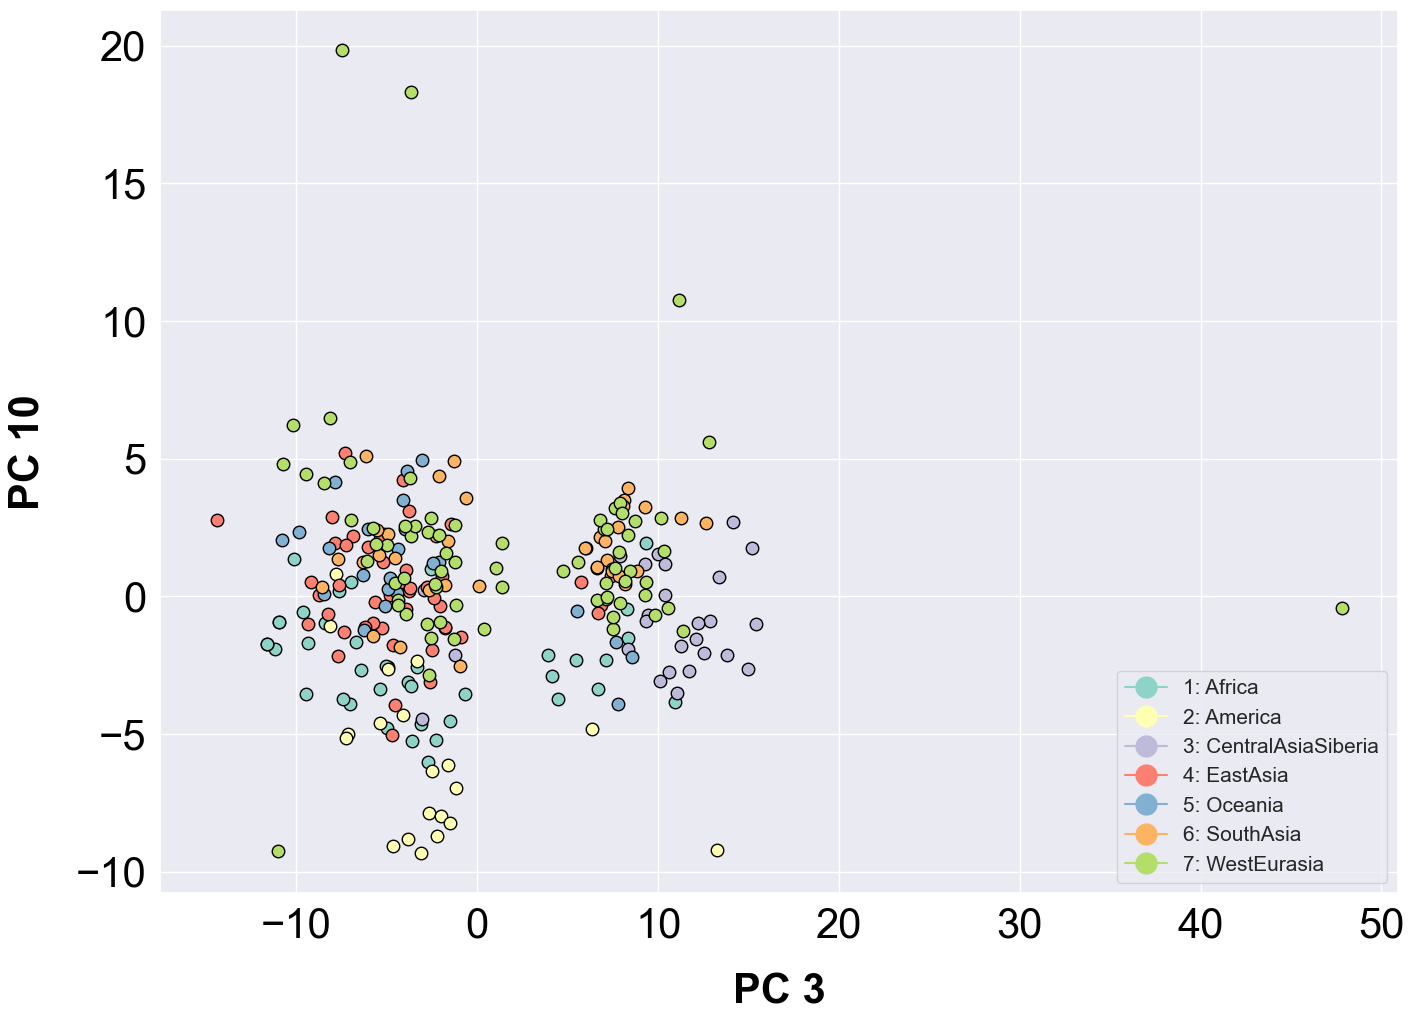

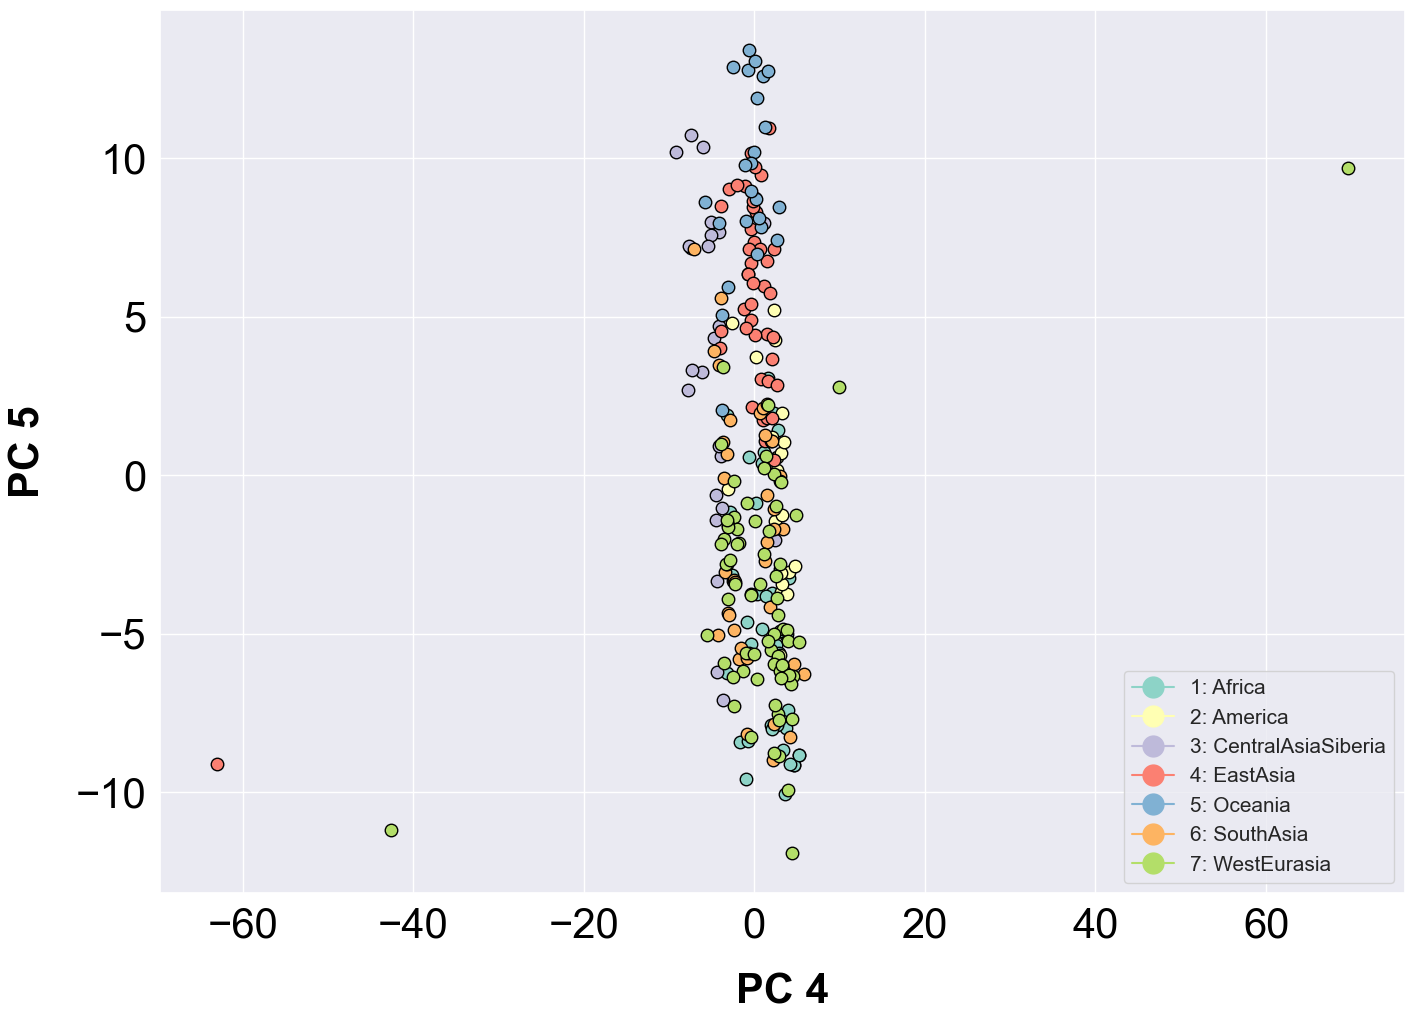

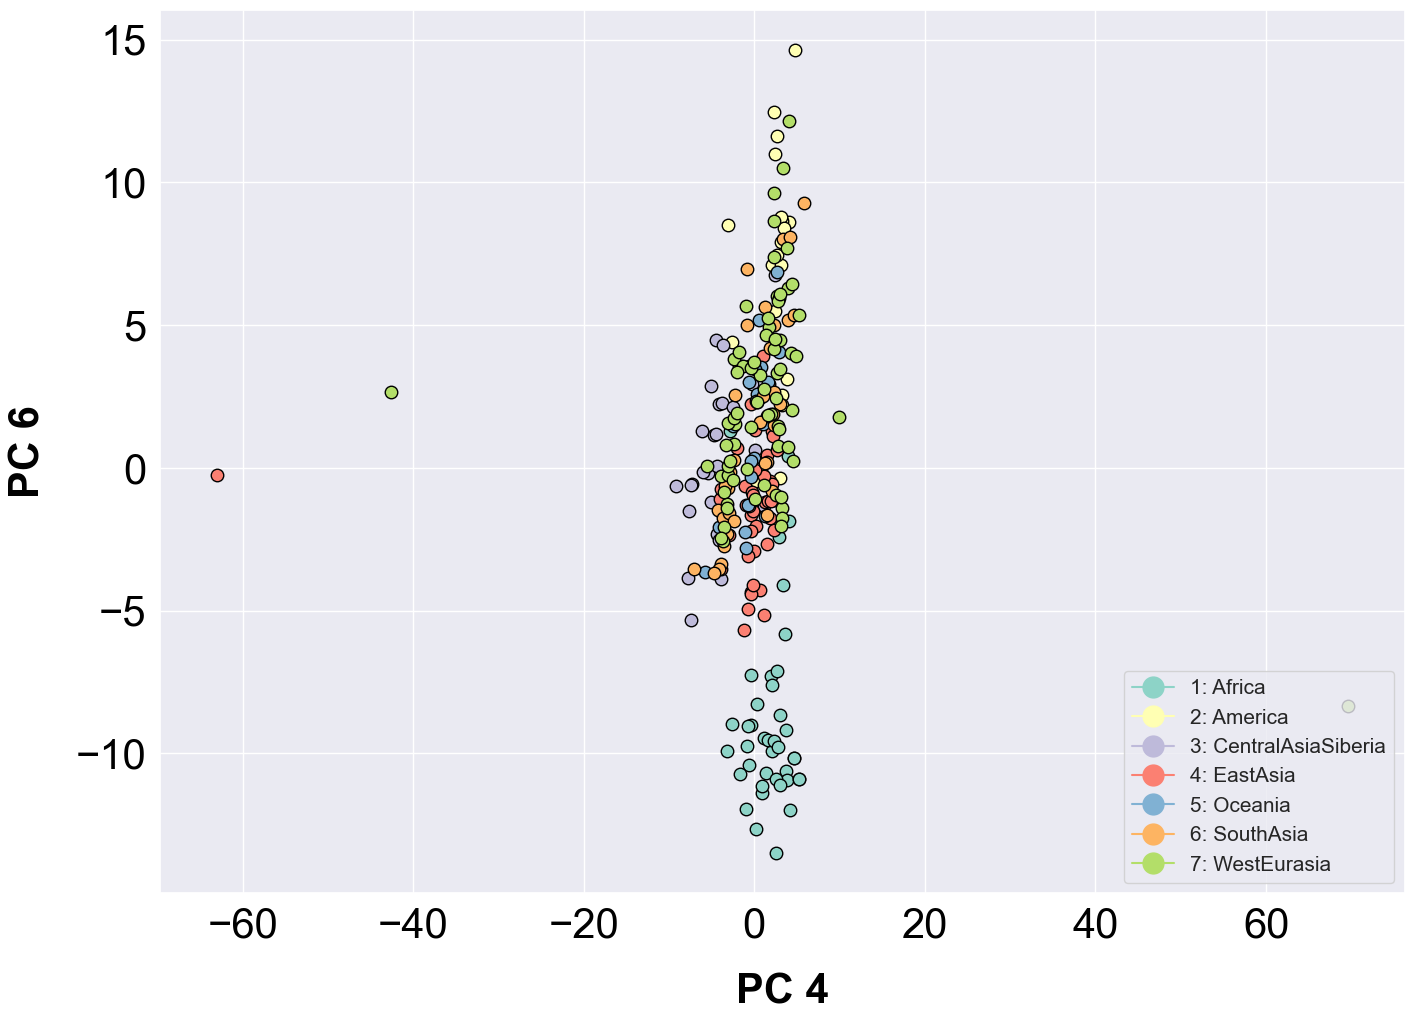

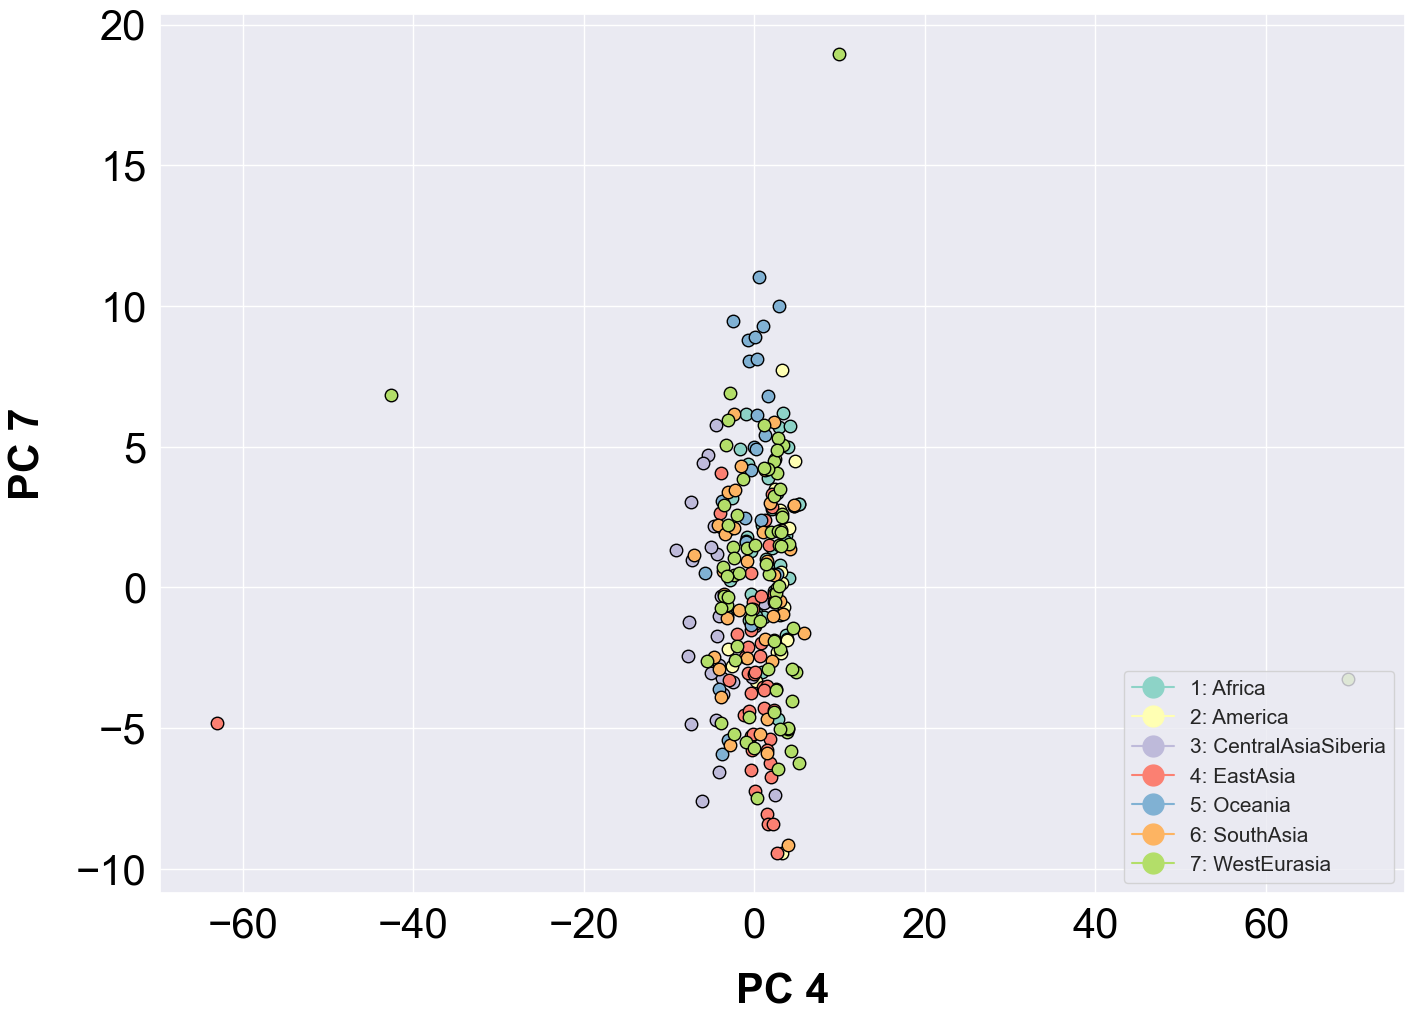

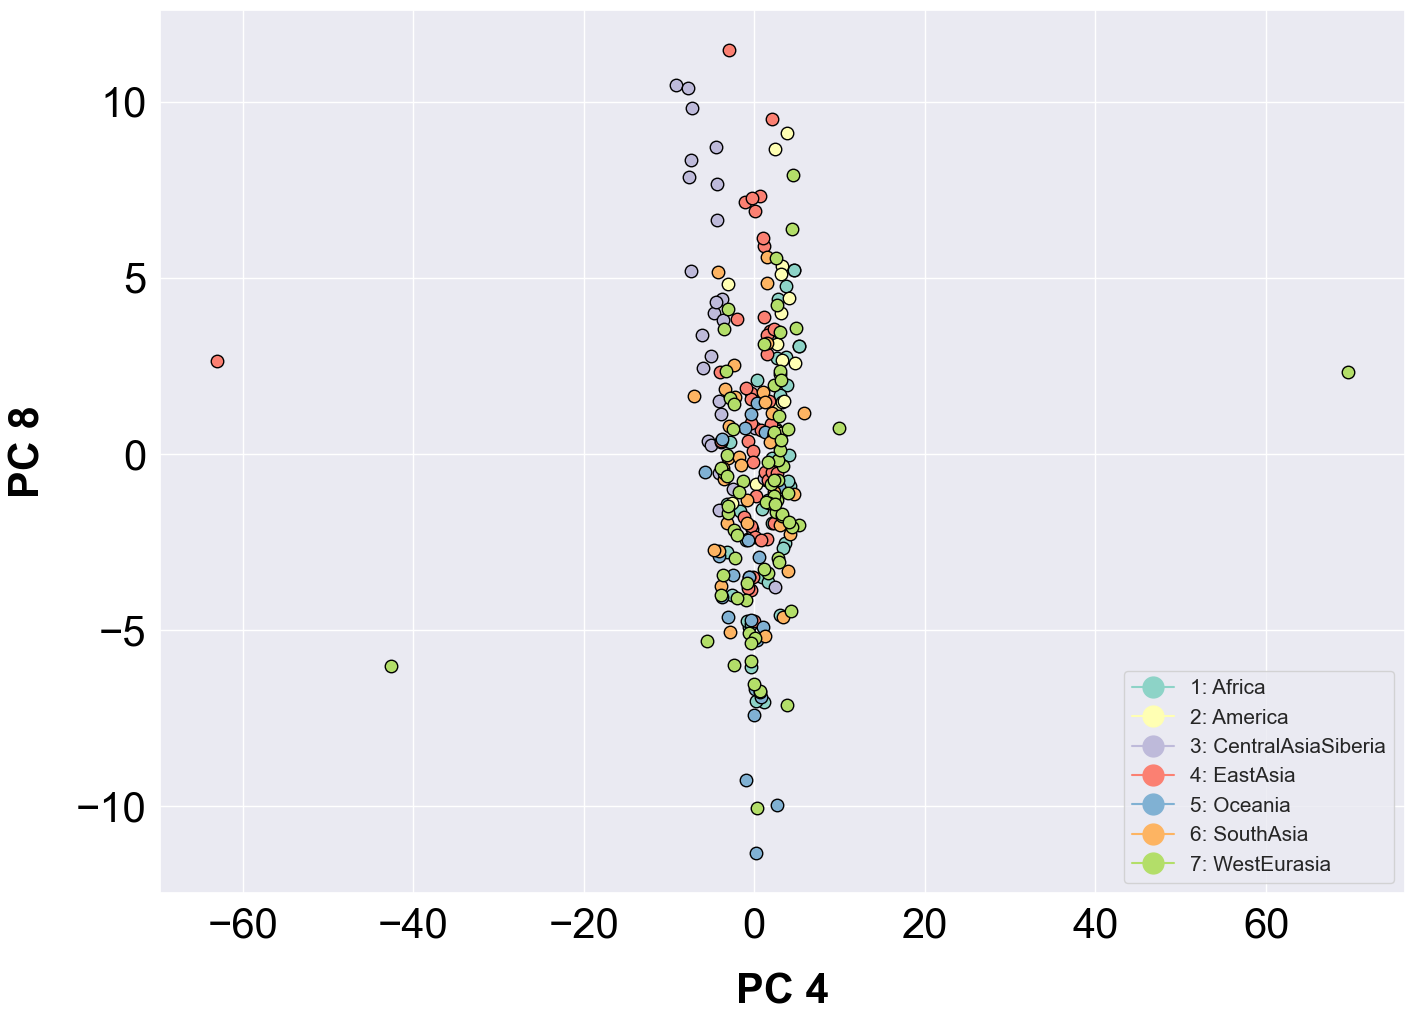

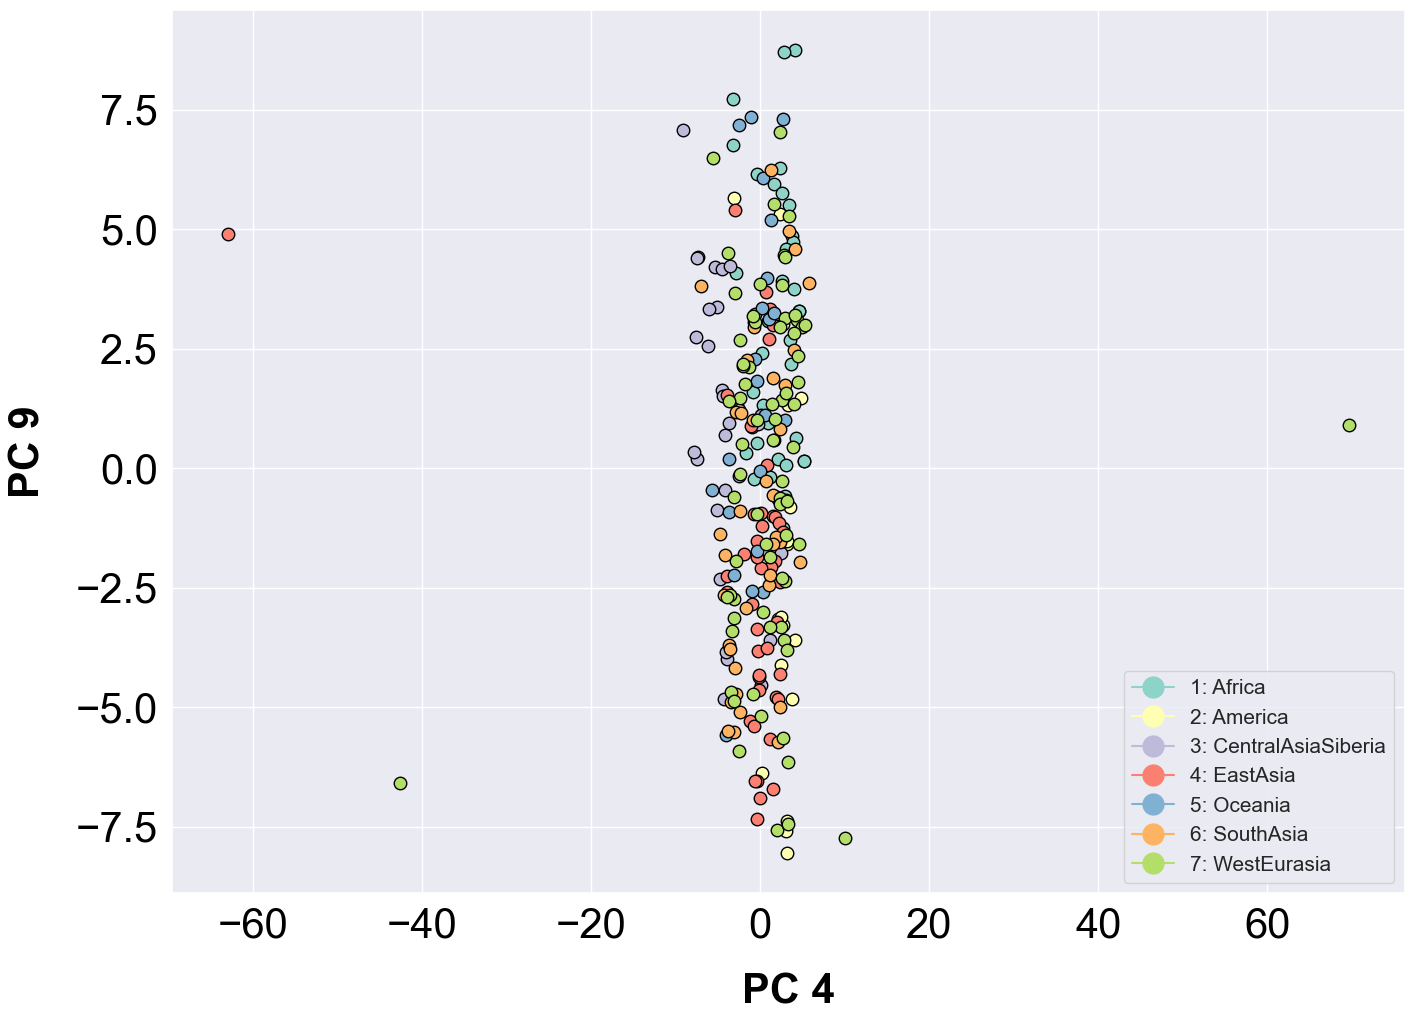

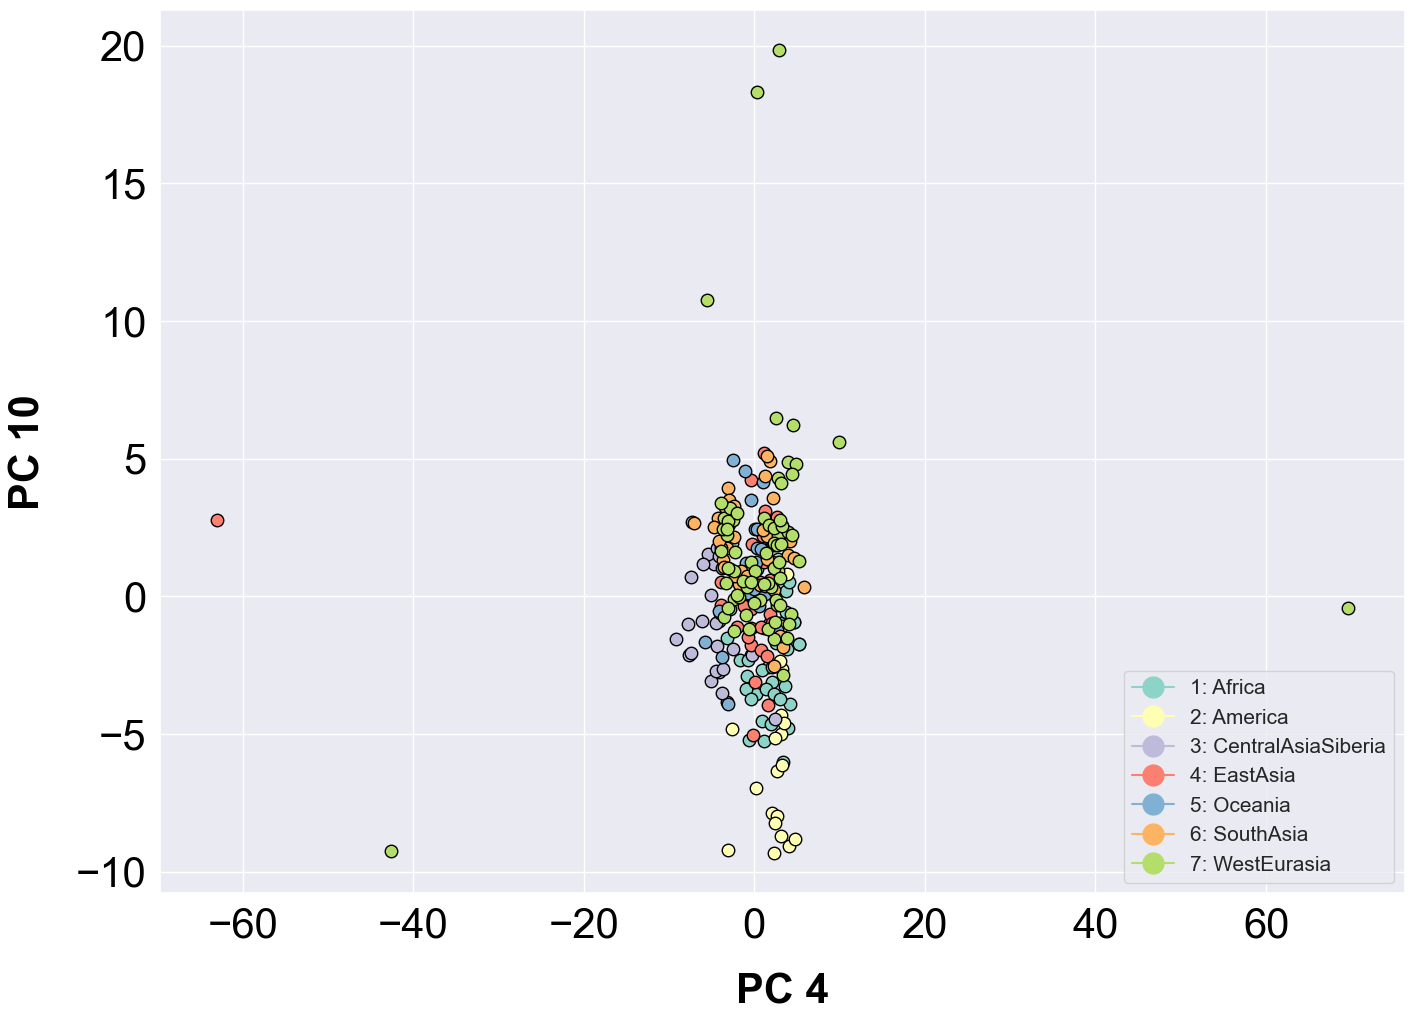

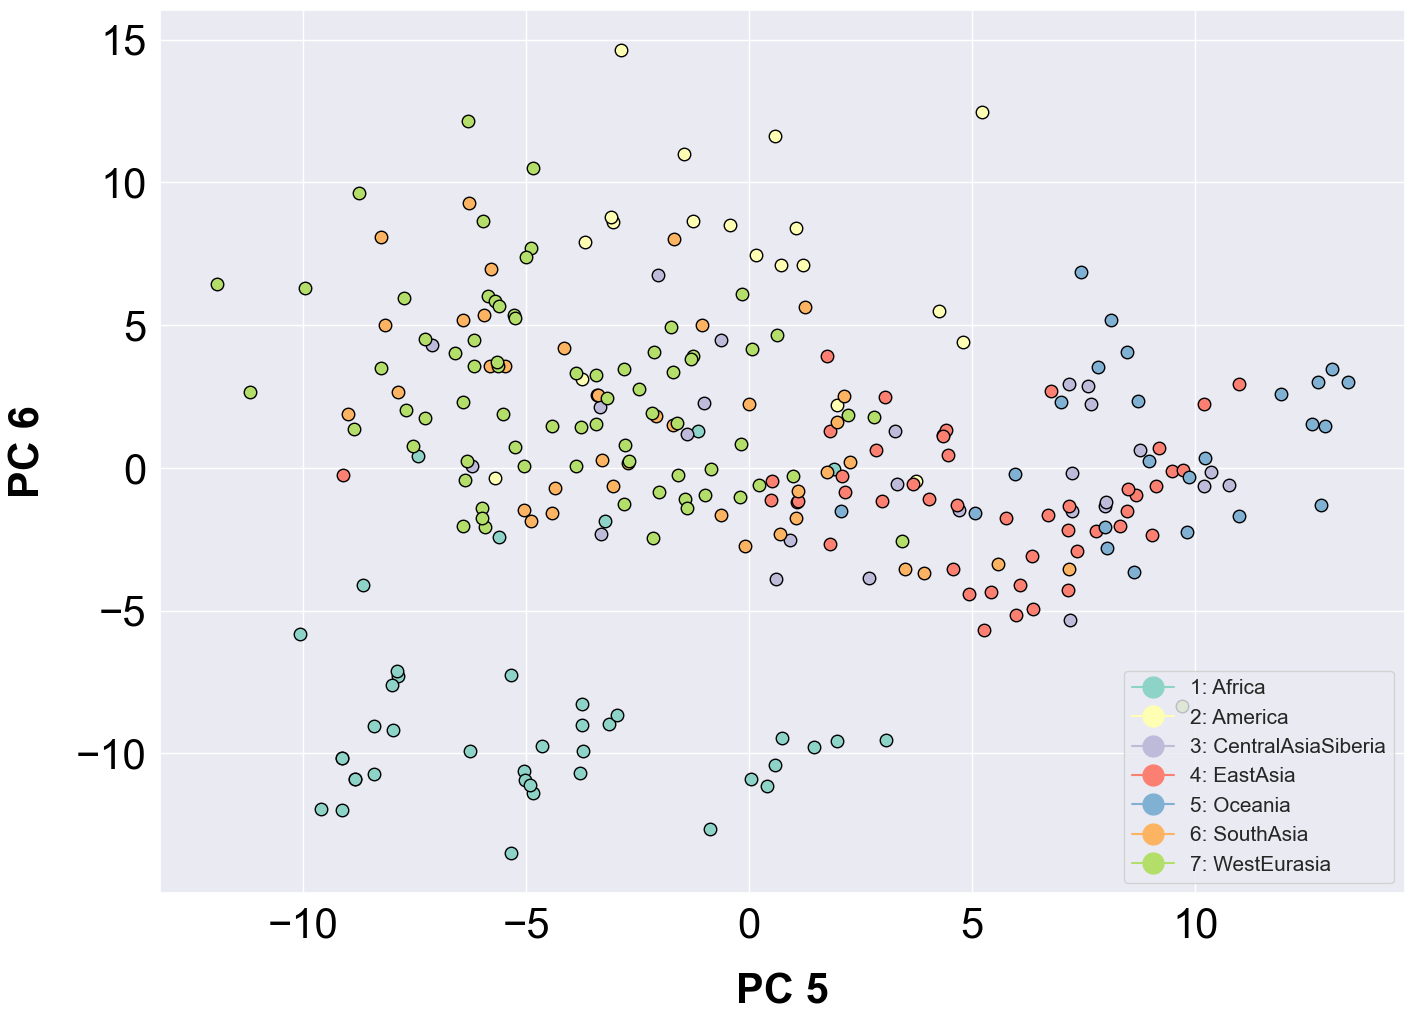

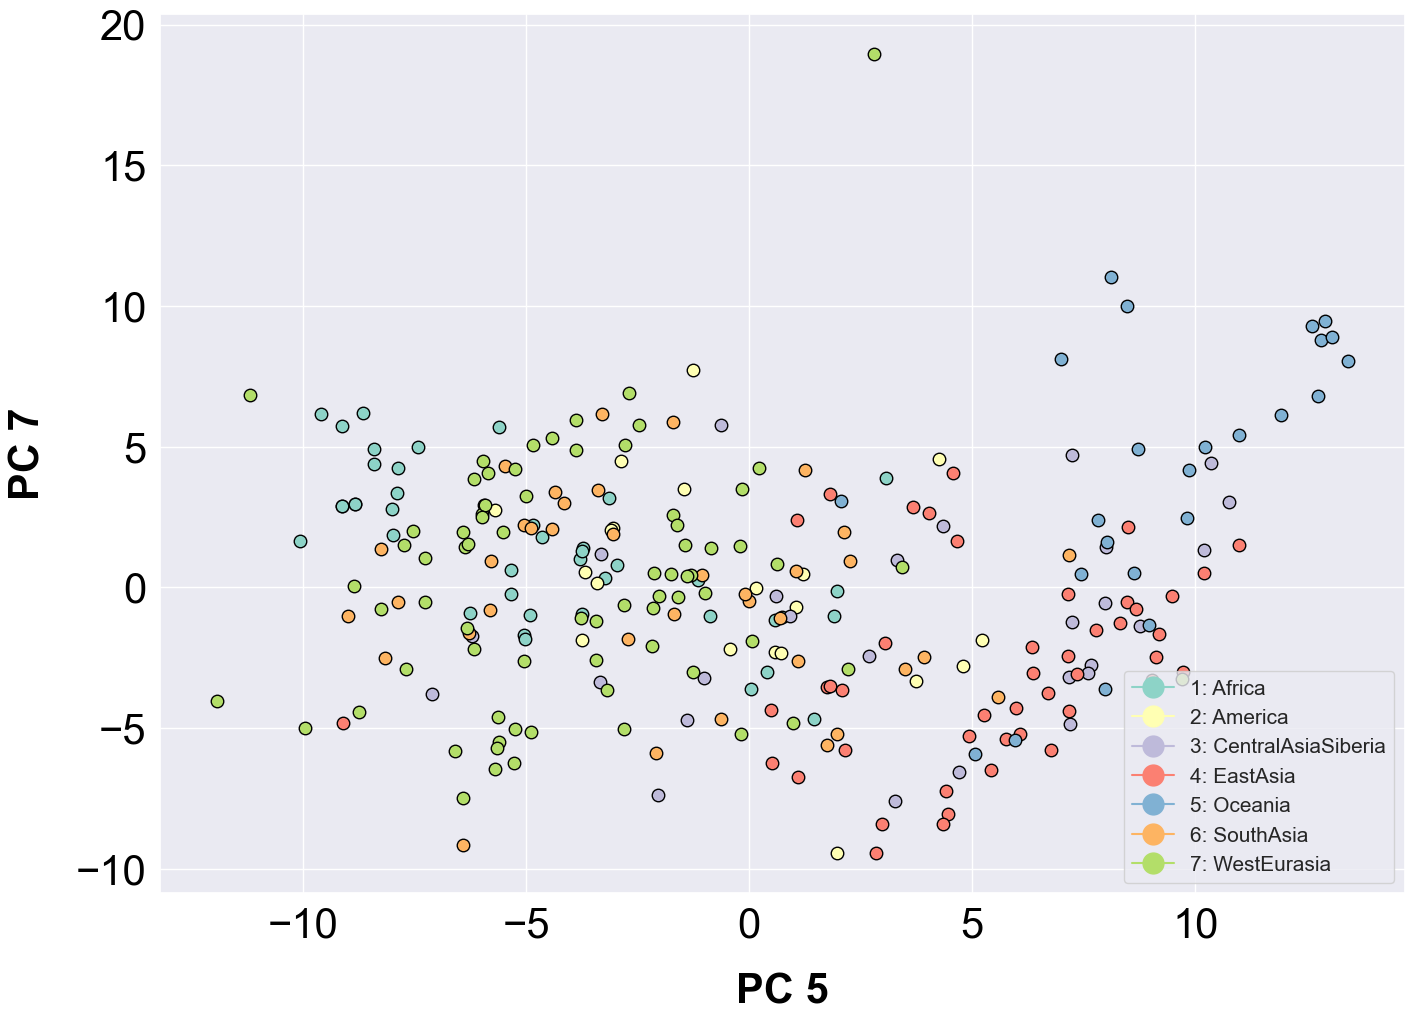

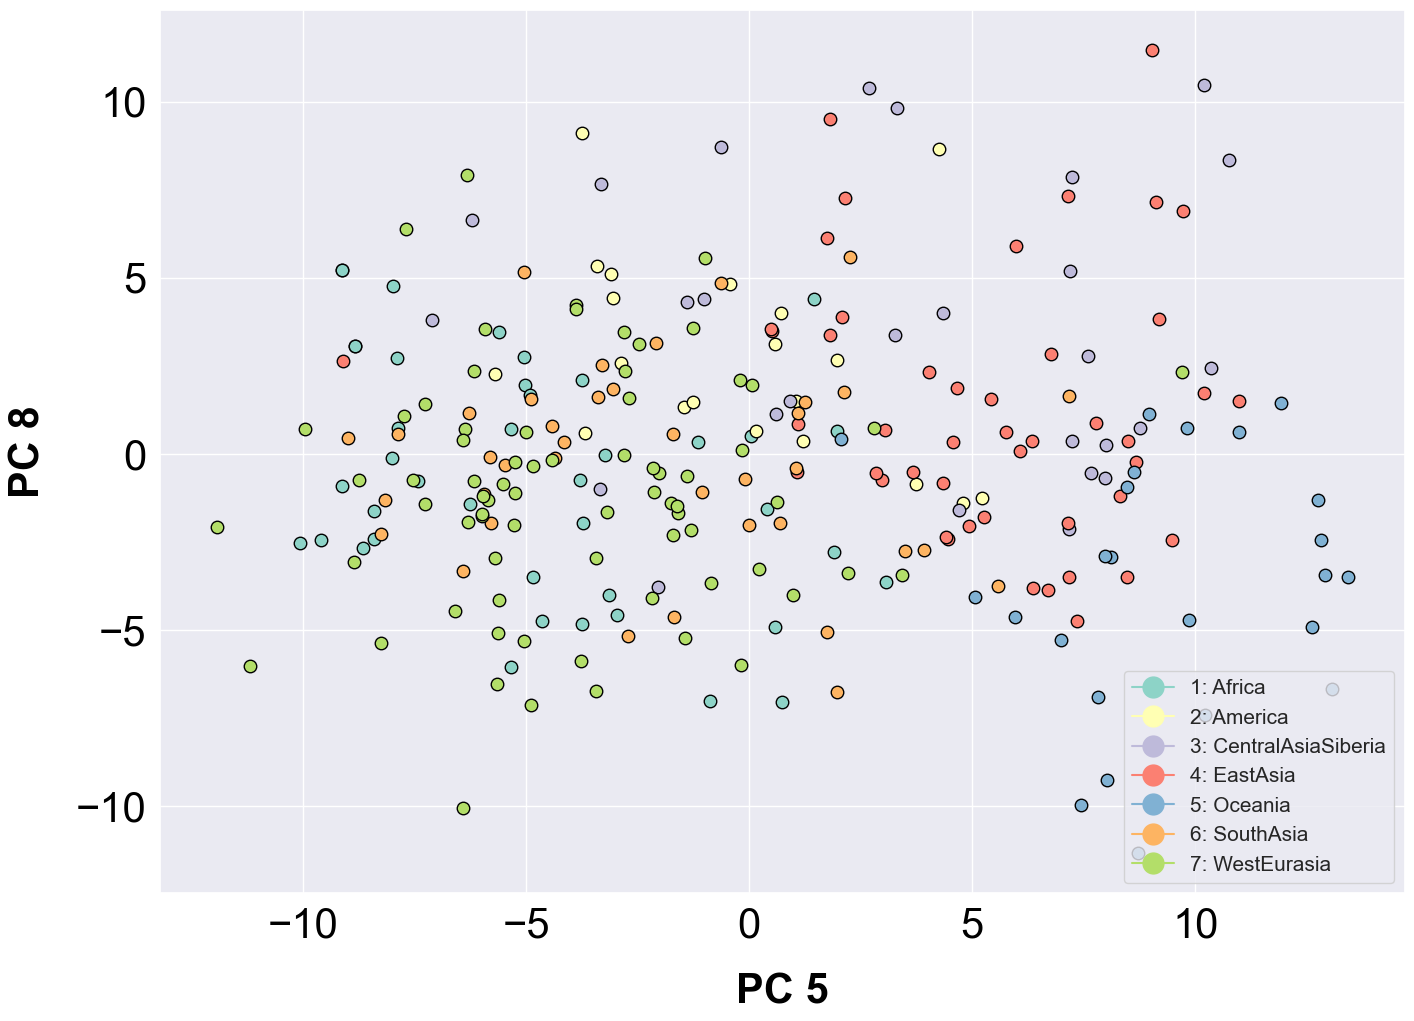

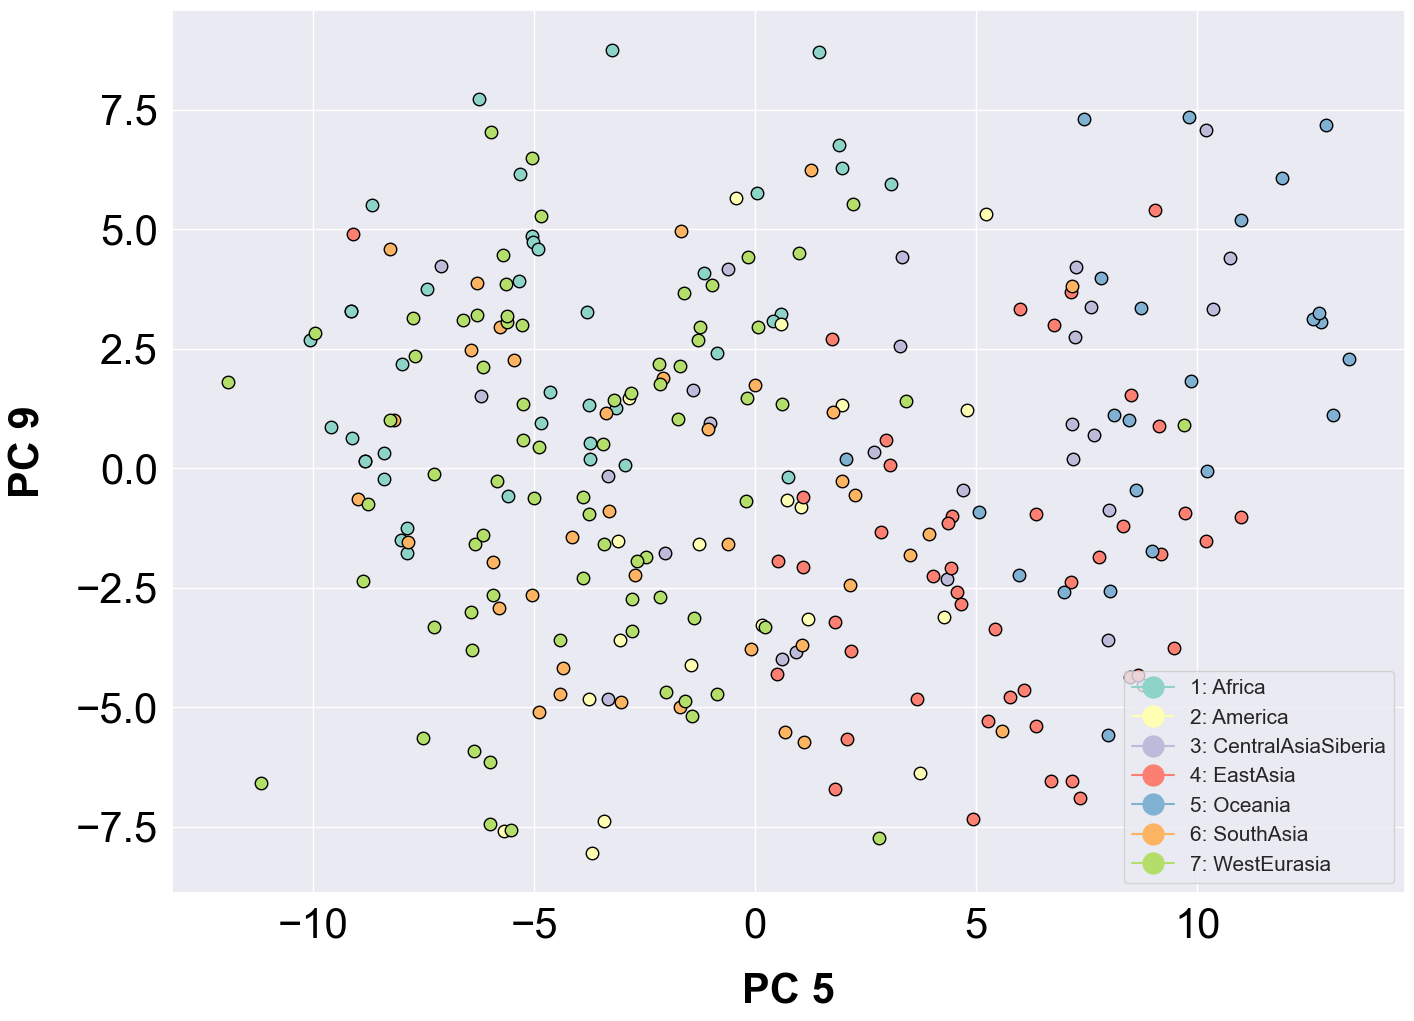

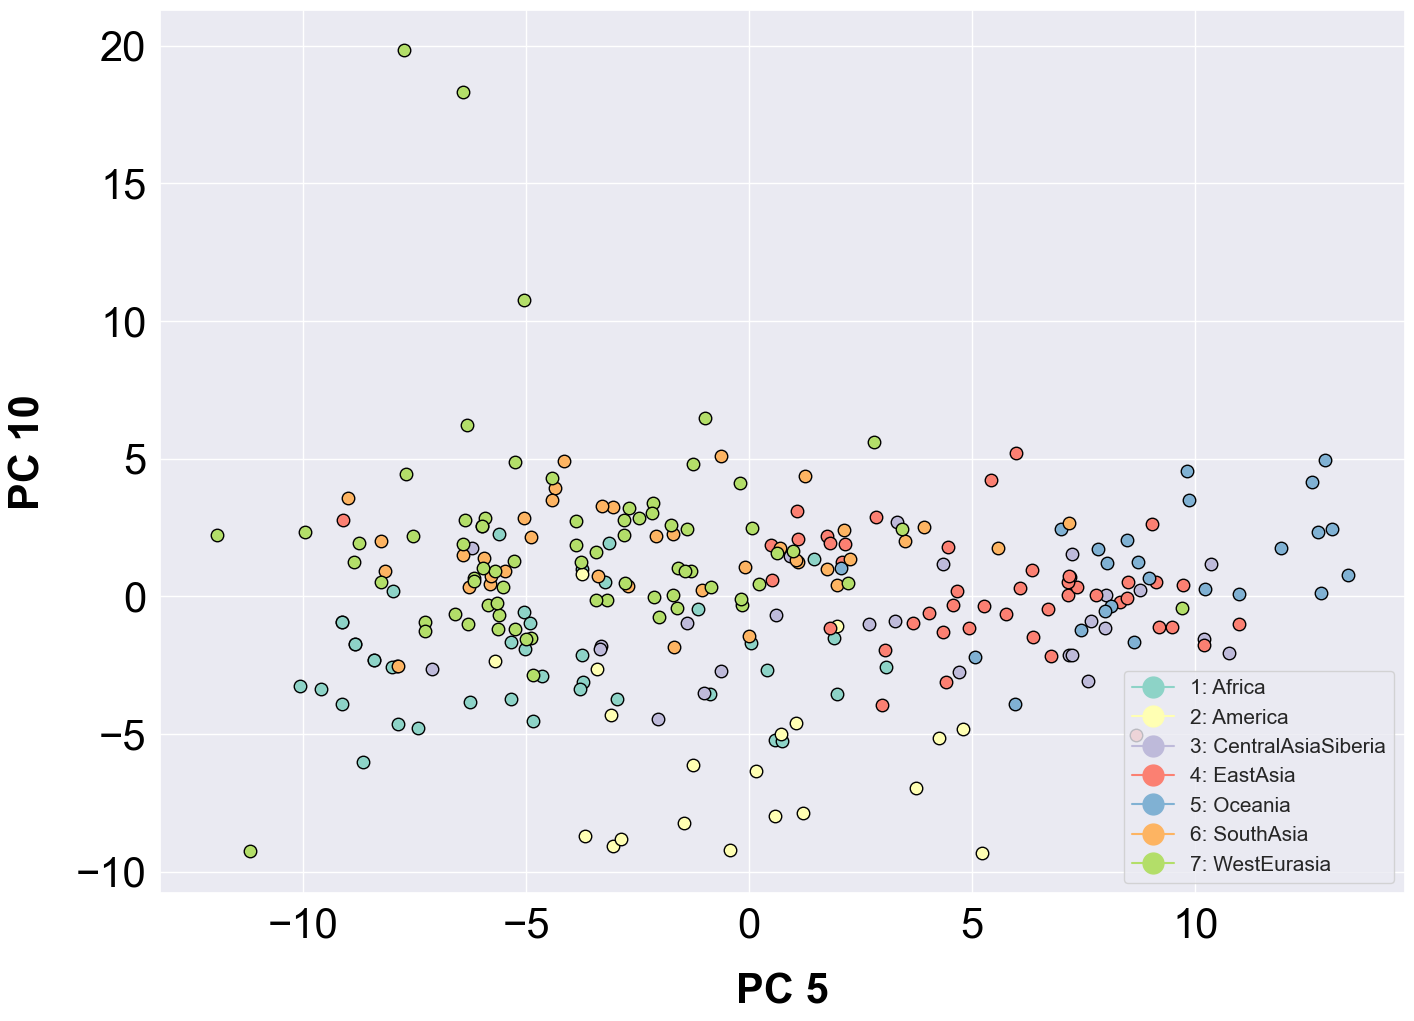

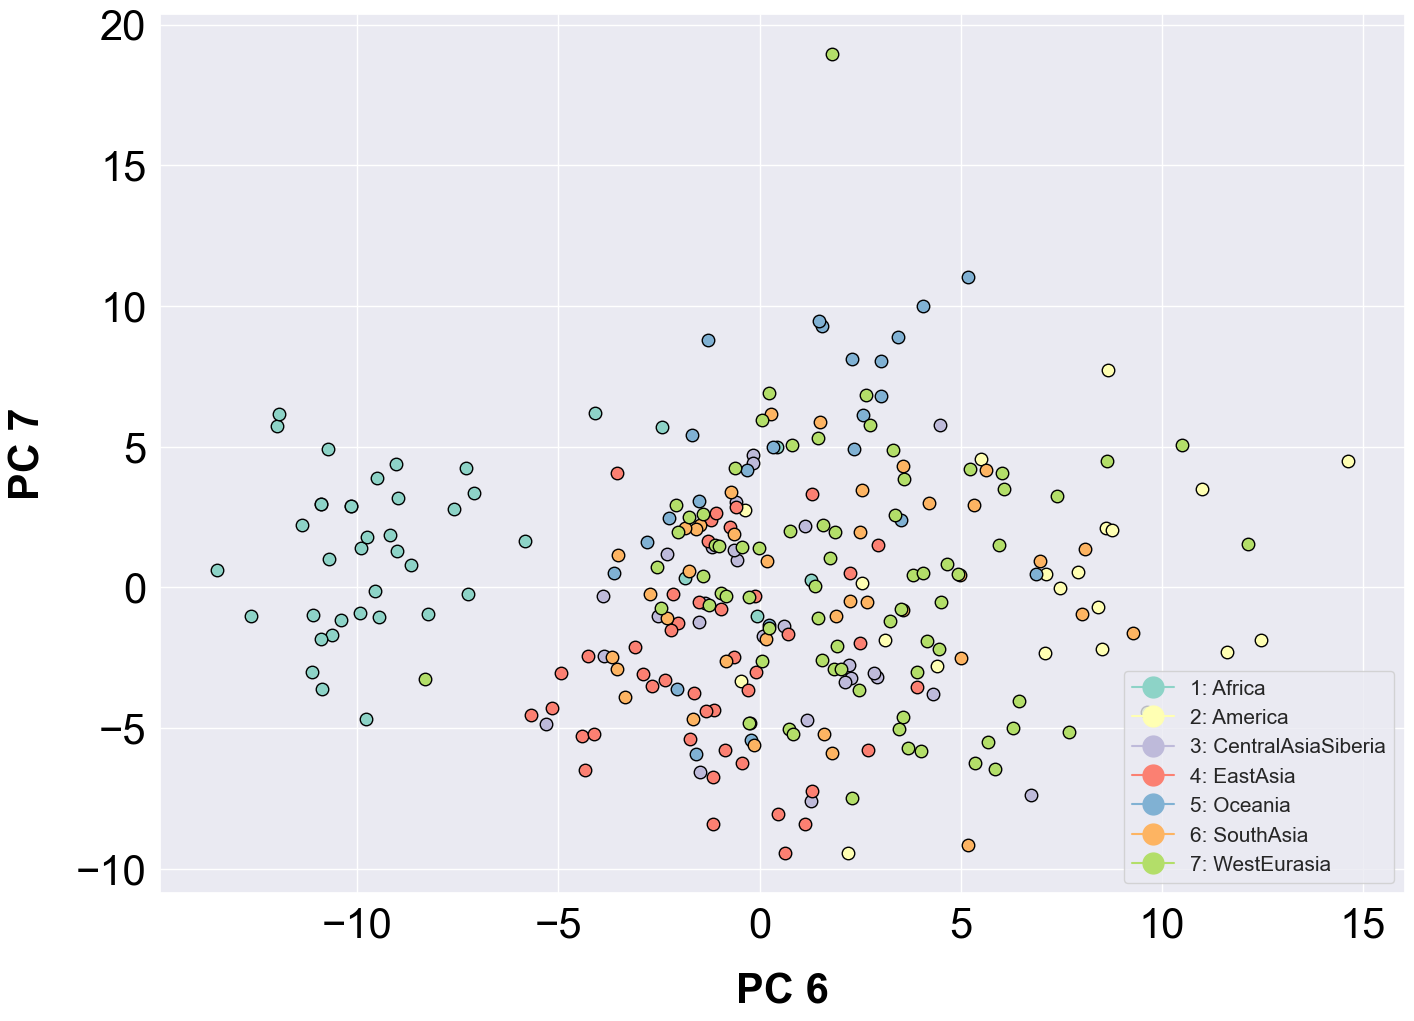

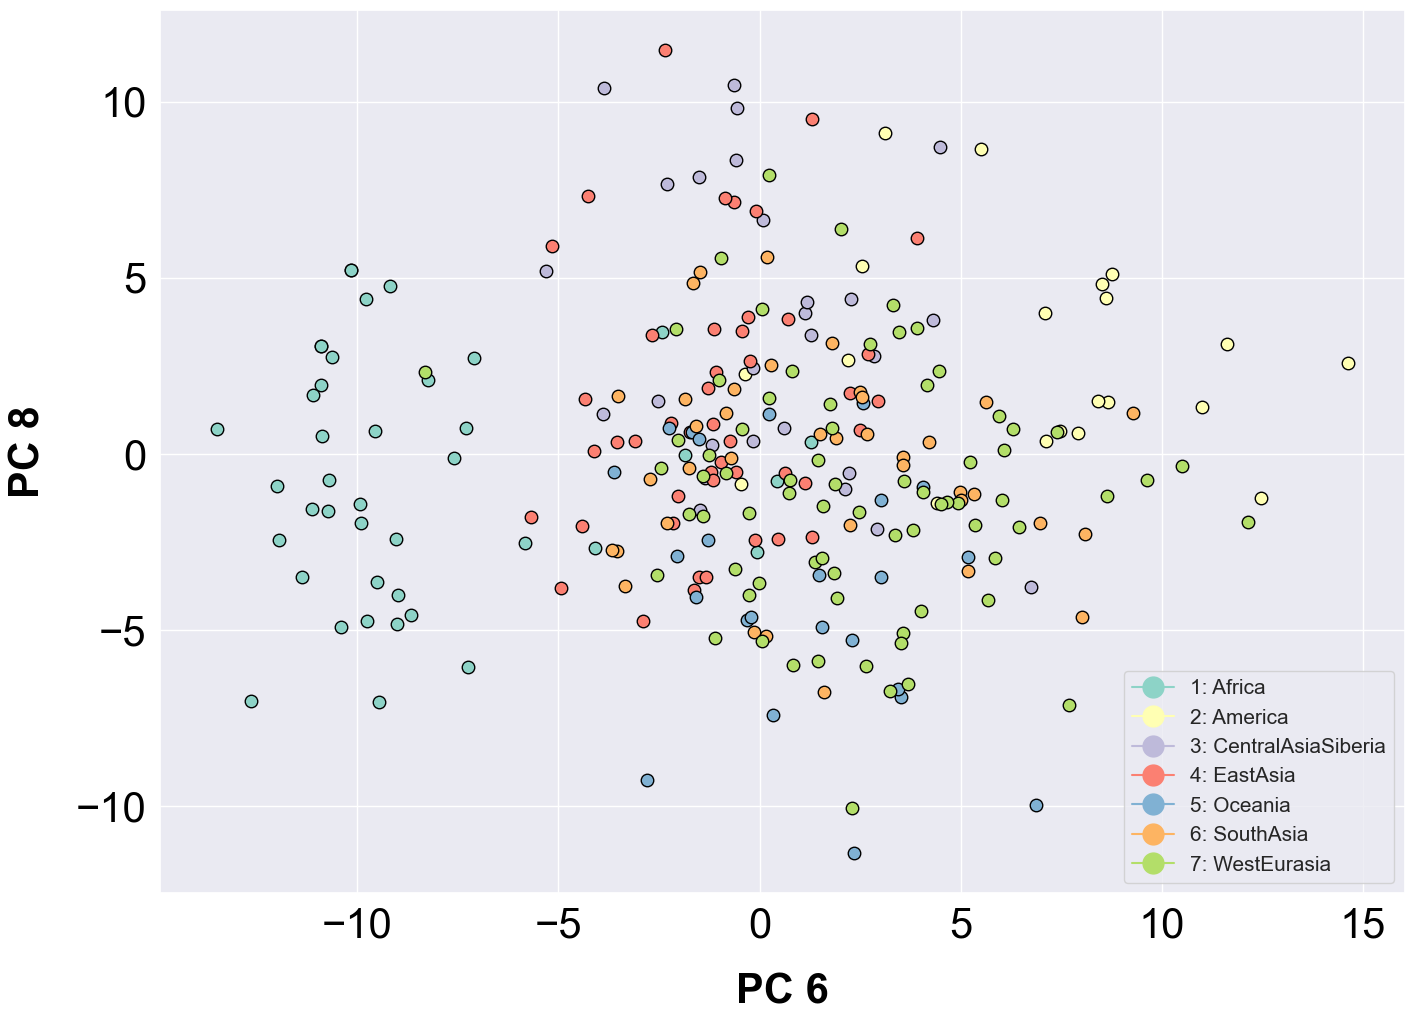

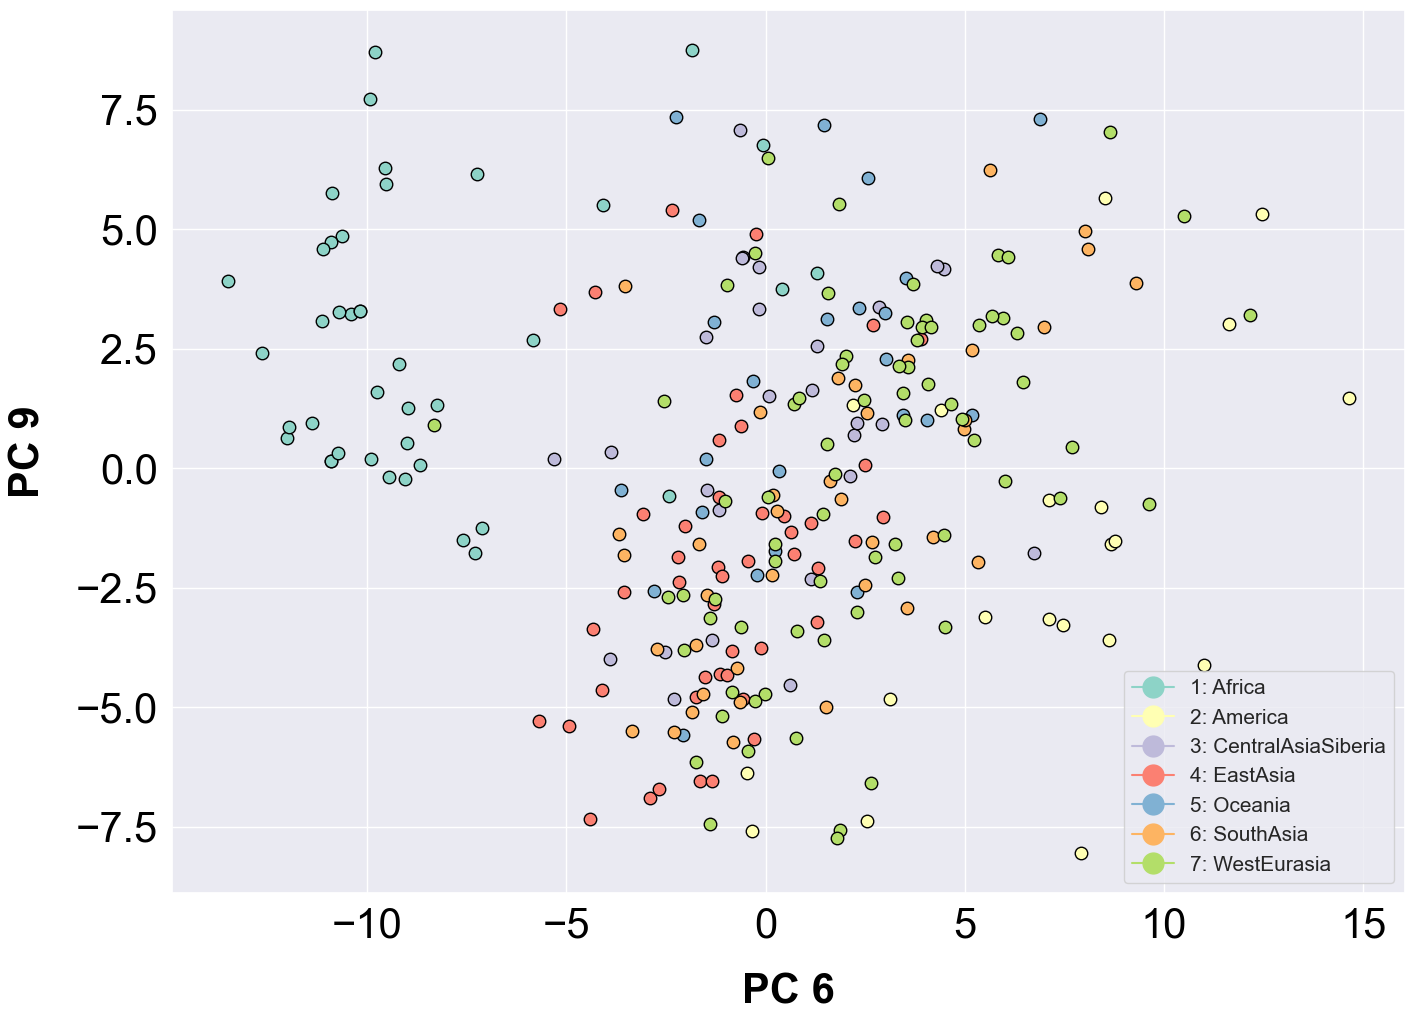

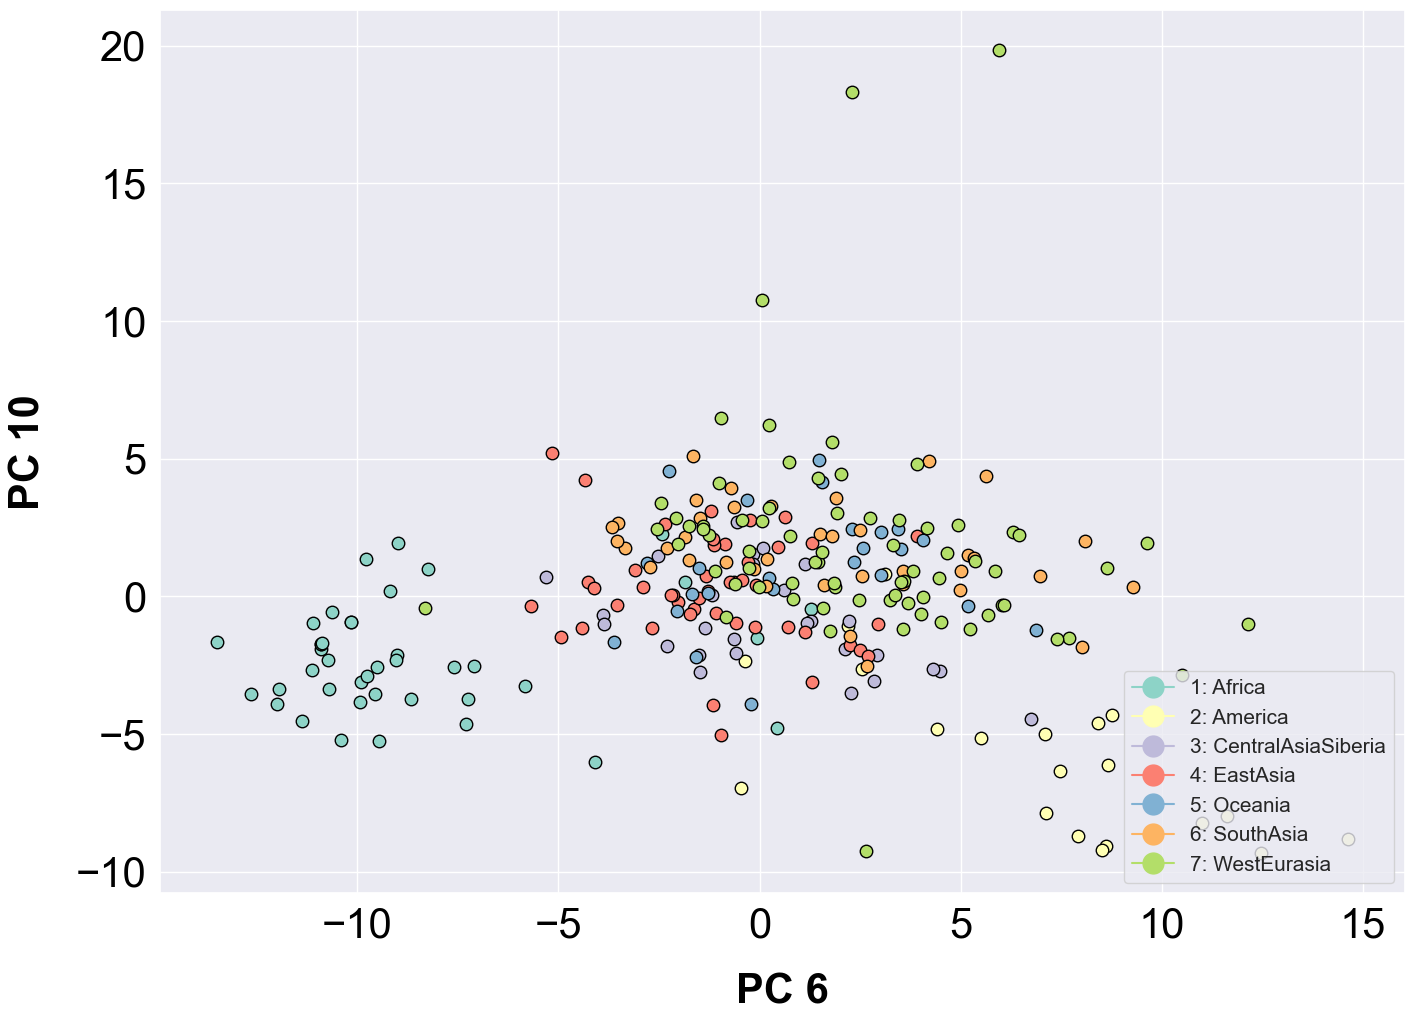

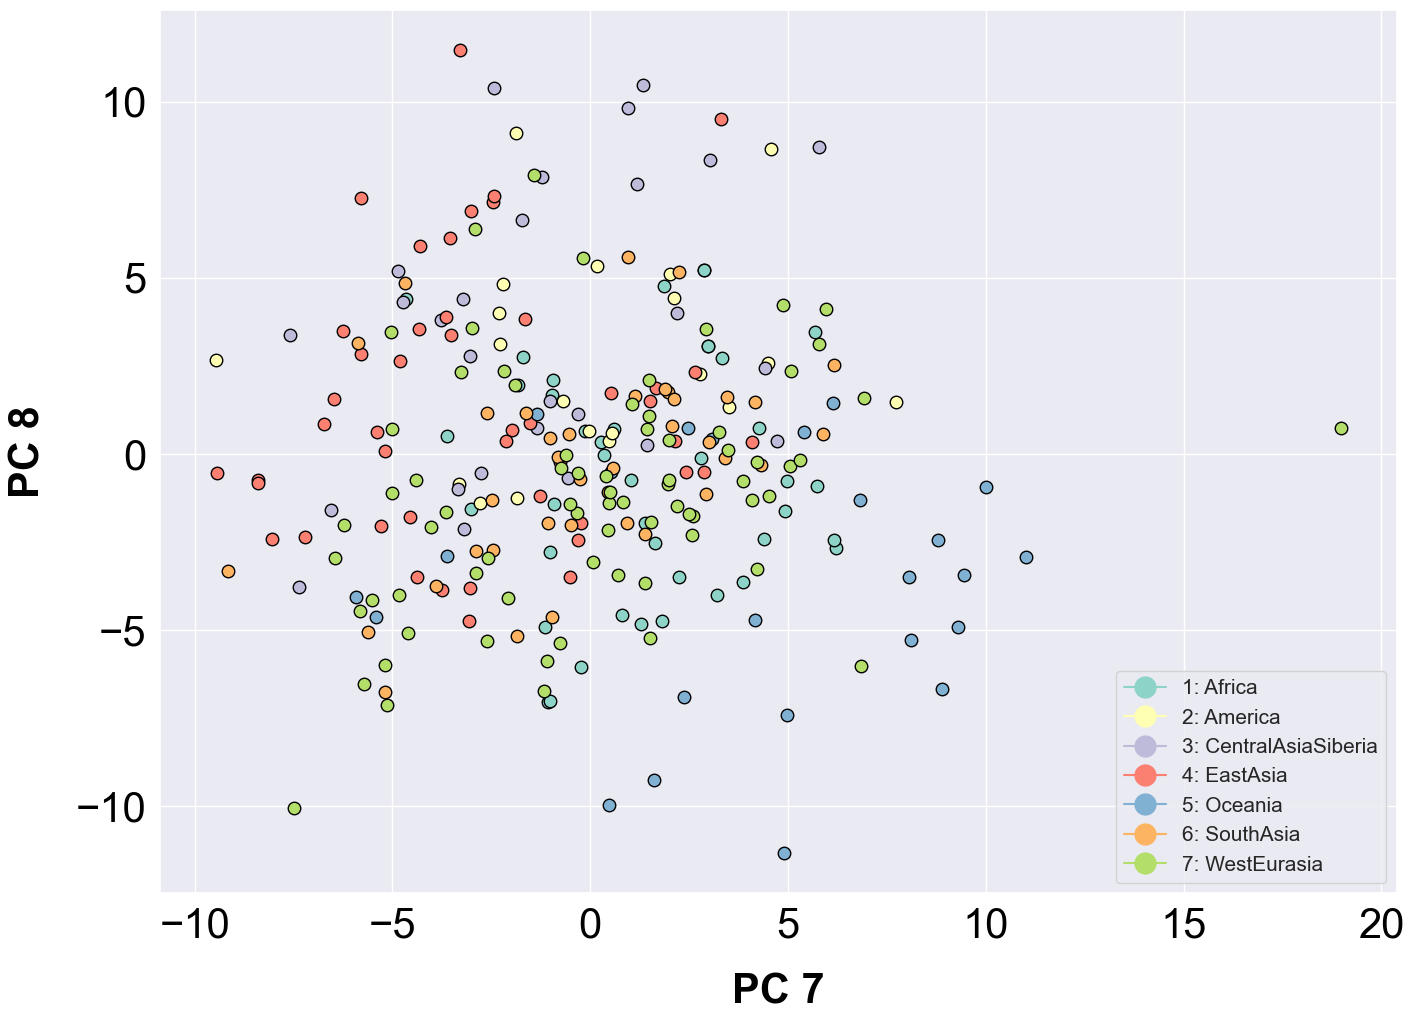

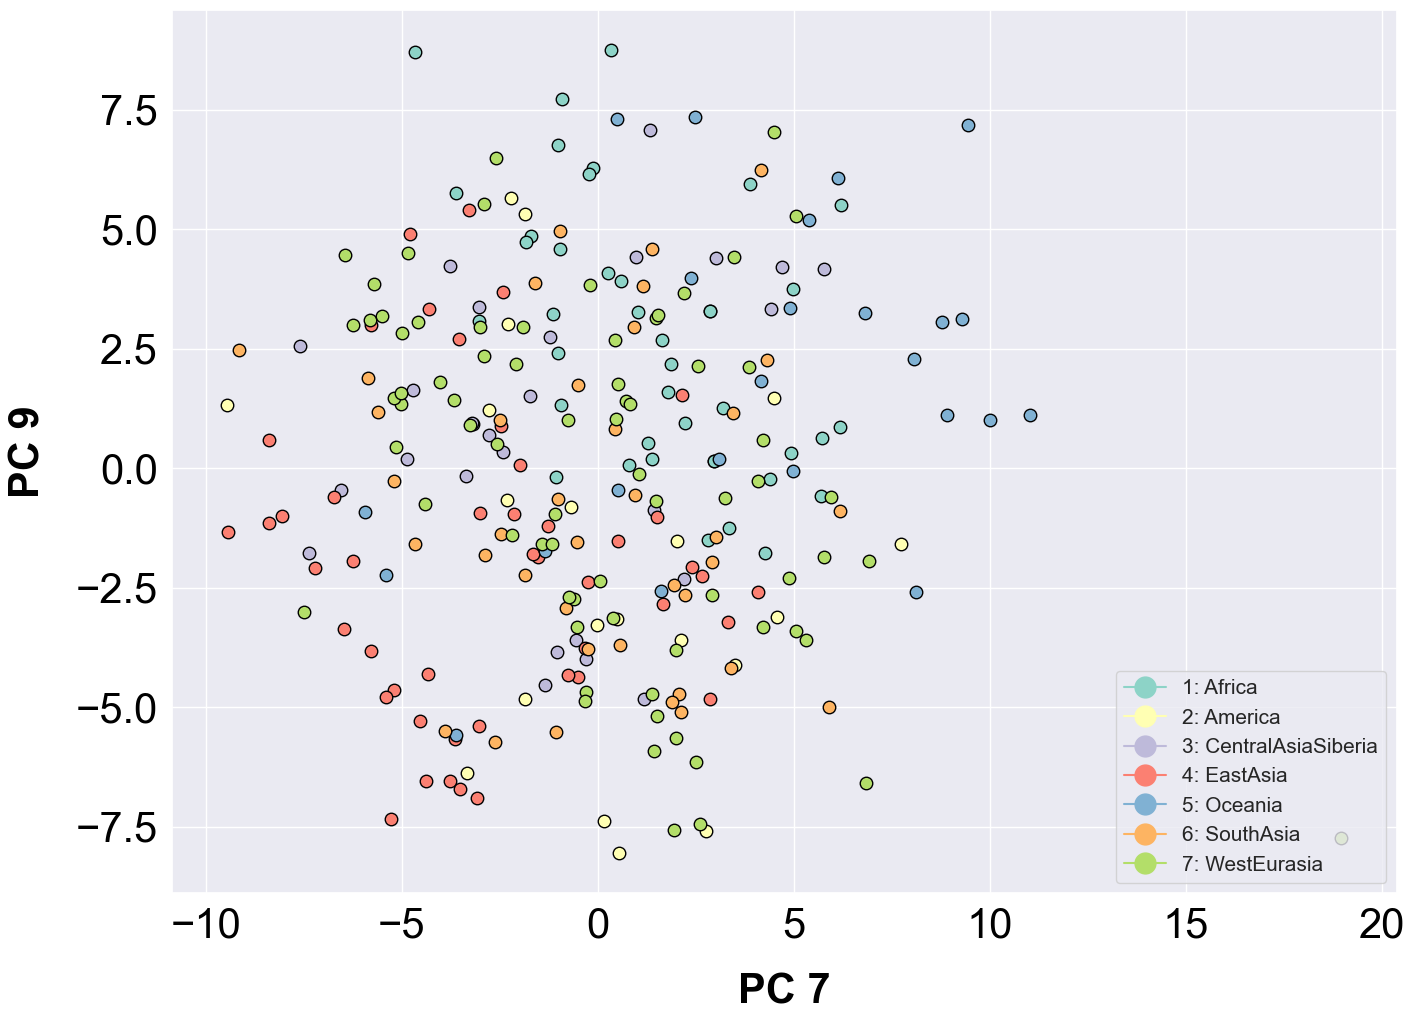

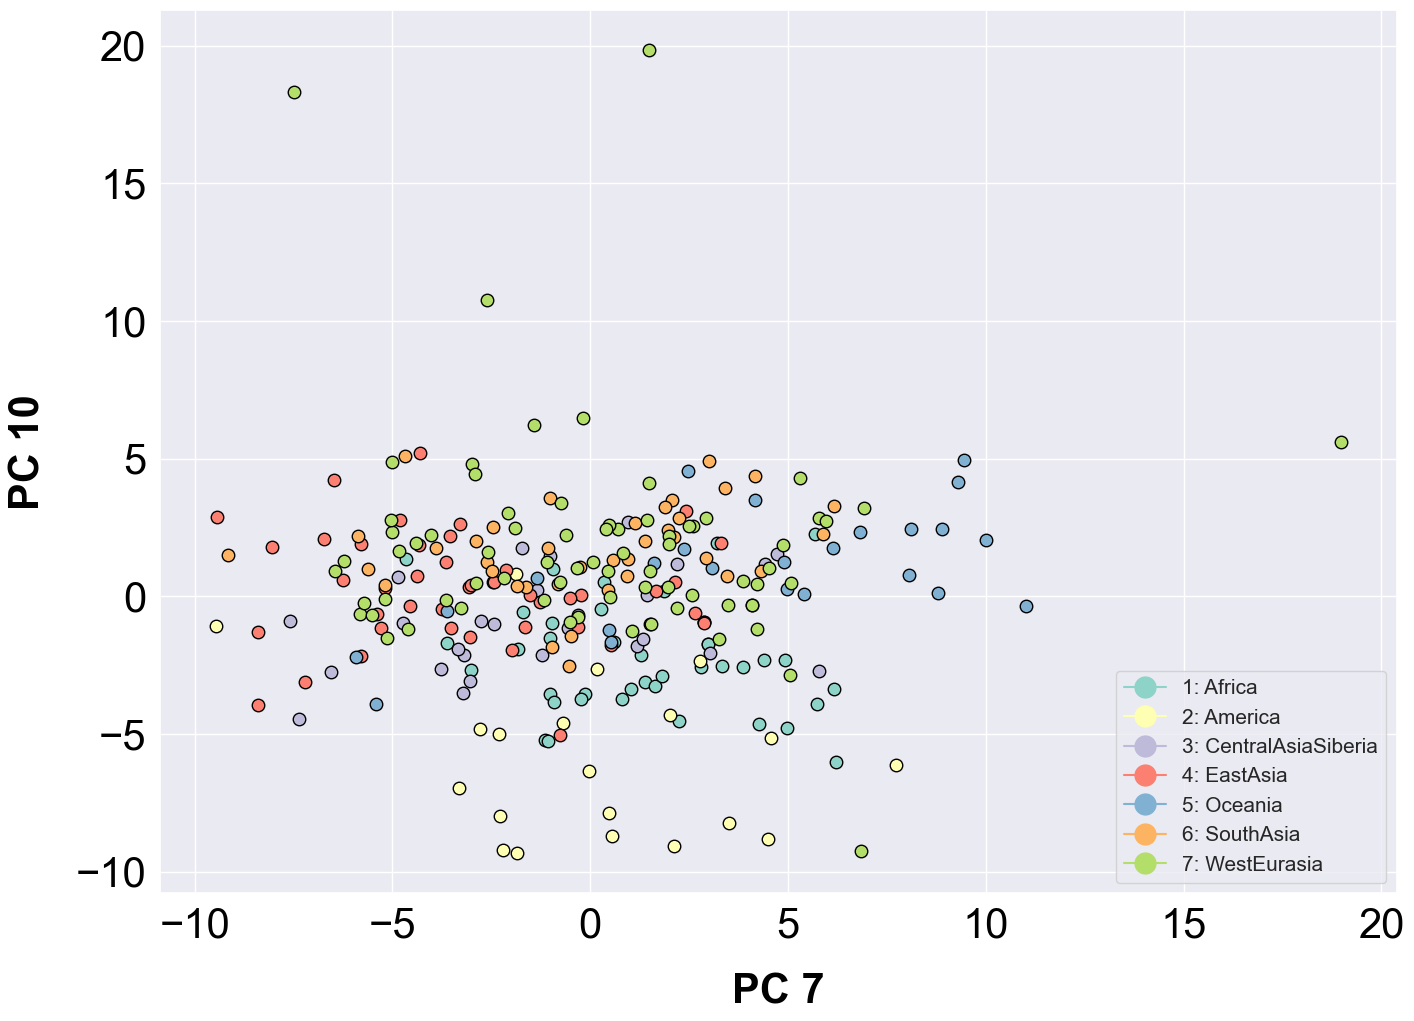

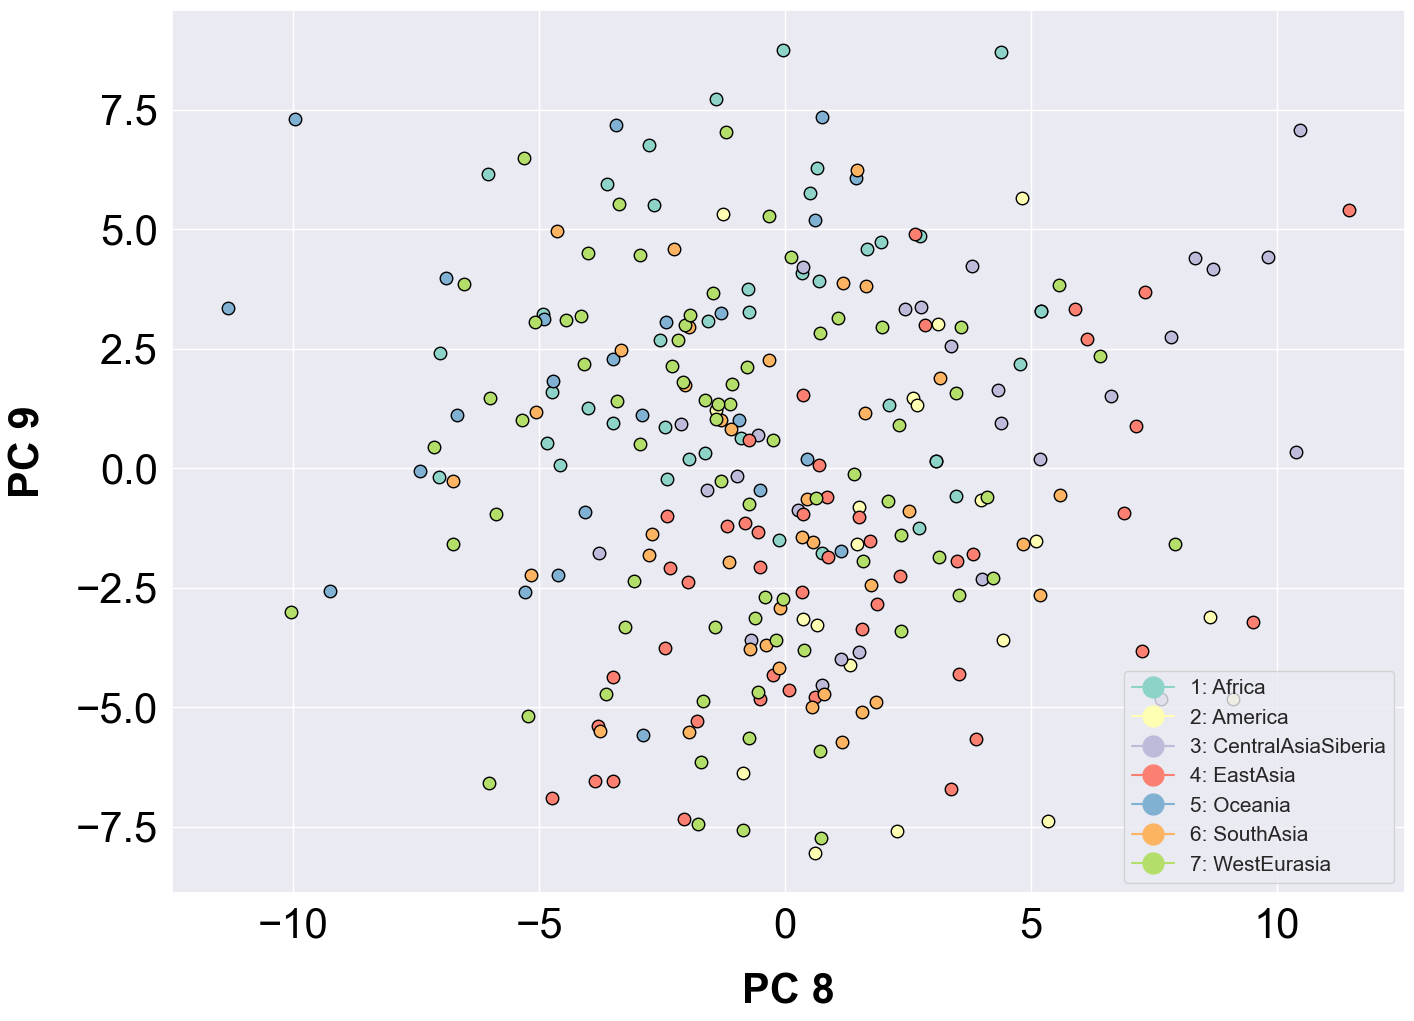

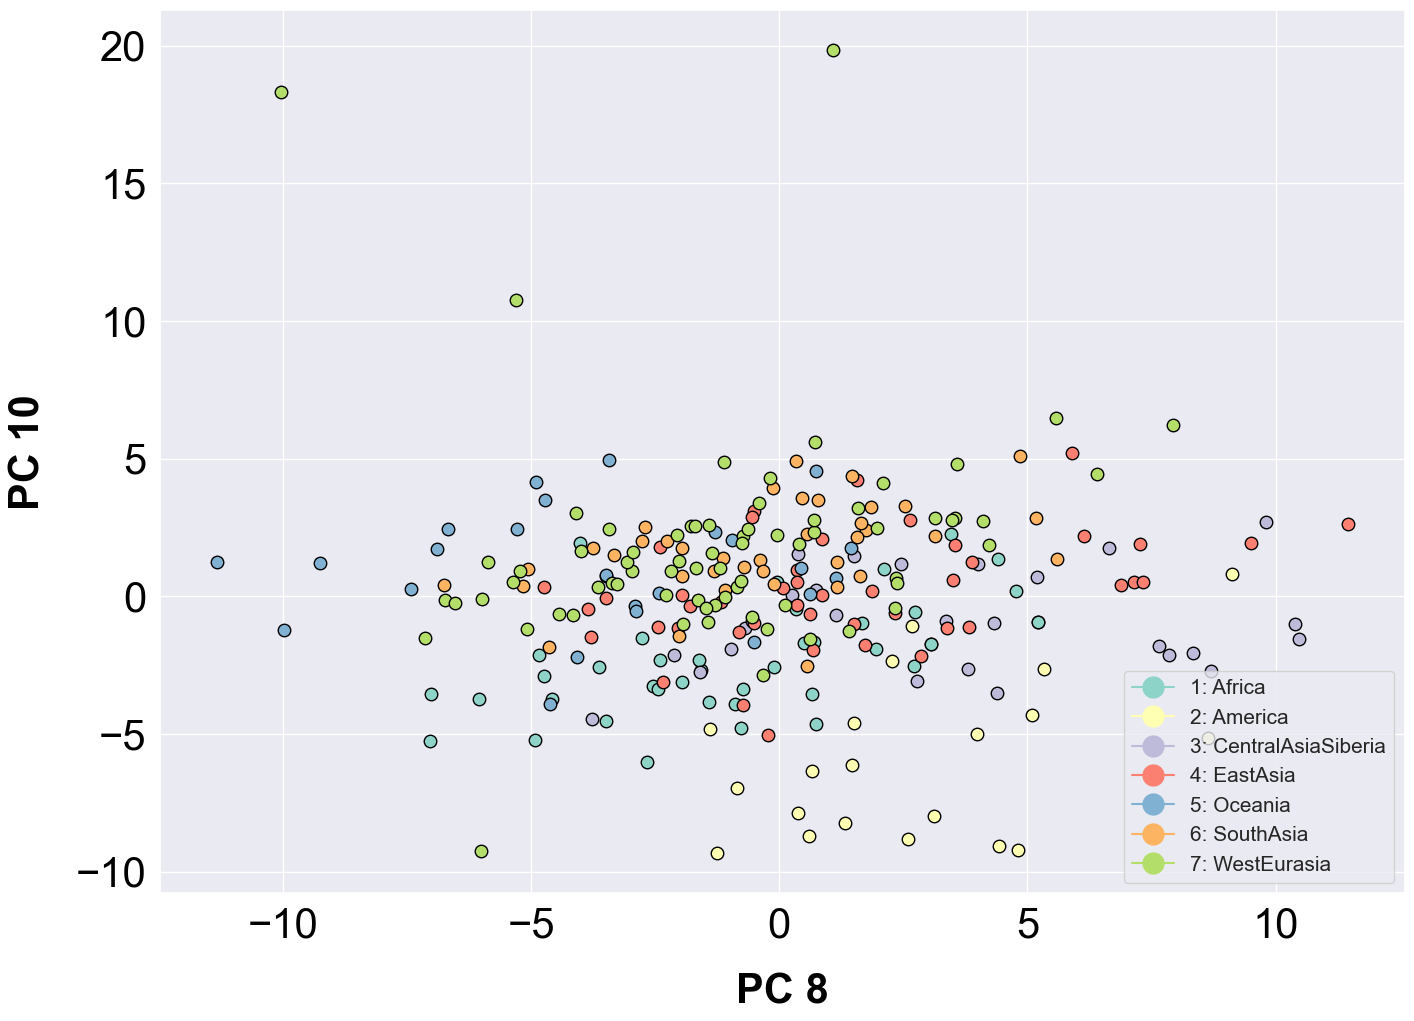

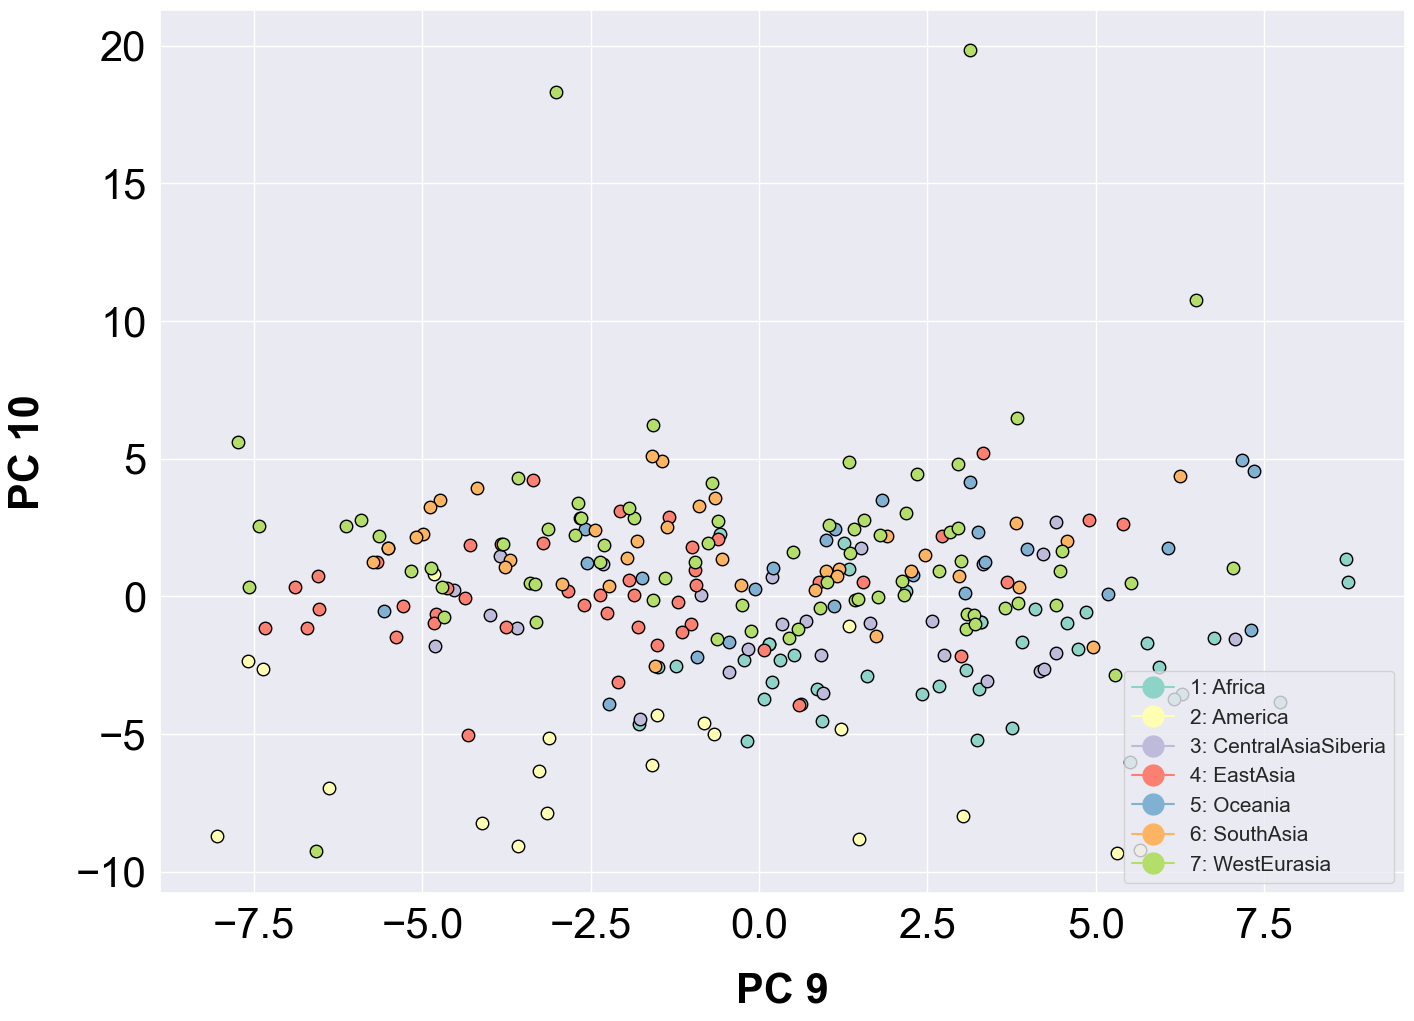

In [32]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='REGION', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))

<h1> Permutation

In [33]:
p_value_permutation = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2)) 
for region in combination_regions:
    p_value= []
    p_value_permutation.append(p_value)
    
    for i in range(623957):
        permutation = PermutationTest(dt_groupped[region[0]][i], dt_groupped[region[1]][i], stat=vst, n_perm=9999)#mean_gt
        p_value.append(permutation.p_value())

/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/vst_function.py:44: RuntimeWarning: invalid value encountered in double_scalars
  vst = (vt-vs)/vt


KeyboardInterrupt: 

In [7]:
## PERMUTATION #####
p_value_permutation = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2))


def permutation(lenght_cnvs):
    p_value_permutation = []
    combination_regions = list(combinations([0,1,2,3,4,5,6],2))
    for region in combination_regions:
        p_value= []
        p_value_permutation.append(p_value)
        
        for i in lenght_cnvs:
            permutation = PermutationTest(dt_groupped[region[0]][i], dt_groupped[region[1]][i], stat=vst, n_perm=9999)#mean_gt
            p_value.append(permutation.p_value())
    permutation_vst_chm13_deletions_gene_regions = pd.DataFrame(p_value_permutation).set_axis(combination_names)

    return permutation_vst_chm13_deletions_gene_regions
    

total_cnvs = range(1014257)

# create a process pool that uses all cpus
with multiprocessing.Pool() as pool:
    for result in pool.map(permutation, total_cnvs):
        result.to_csv('permutation_vst_chm13_all_cnvs.csv')



Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'permutation' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  

Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'permutation' on <module '__main__' (built-in)>
Process SpawnPoolWorker-15:
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


Process SpawnPoolWorker-27:
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'permutation' on <module '__main__' (built-in)>
Process SpawnPoolWorker-28:
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

In [6]:
import multiprocessing

In [10]:
permutation(range(5))

NameError: name 'dt_groupped' is not defined

In [43]:
with multiprocessing.Pool() as pool:
    for result in pool.map(permutation, range(10)):
        result.to_csv('permutation_vst_chm13_all_cnvs.csv')

Process SpawnPoolWorker-17:
Process SpawnPoolWorker-18:
Process SpawnPoolWorker-19:
Process SpawnPoolWorker-21:
Process SpawnPoolWorker-20:
Process SpawnPoolWorker-23:
Process SpawnPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()


KeyboardInterrupt: 

In [46]:
from multiprocessing import Pool

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(permutation, range(10)))

Process SpawnPoolWorker-50:
Process SpawnPoolWorker-51:
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'permutation' on <module '__main__' (built-in)>
Process SpawnPoolWorker-52:
Process SpawnPoolWorker-53:
Traceback (most recent call last):
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luciabazan/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 10

KeyboardInterrupt: 

In [ ]:
def cube(x):
    return x**3
 
if __name__ == "__main__":
    # this does not work
    processes = [multiprocessing.Process(target=cube, args=(x,)) for x in range(1,1000)]
    [p.start() for p in processes]
    result = [p.join() for p in processes]
    print(result)

In [54]:
processes = [multiprocessing.Process(target=vst_function.permutation, args=(lenght_cnvs,)) for lenght_cnvs in range(5)]
[p.start() for p in processes]
result = [p.join() for p in processes]
print(result)

AttributeError: module 'vst_function' has no attribute 'permutation'

In [15]:
import permutation_chm13

In [18]:
permutation_chm13(4)

TypeError: 'module' object is not callable